# Load data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
import os
from pathlib import Path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.refinement import knowledge

# Bypass issues with invoking notebook with server arguments
sys.argv.clear()
sys.argv.append("")

%run utils/attention_graph.py
%run utils/mlflow_query.py
%run utils/percentiles.py
%run utils/loading.py
%run utils/comparison.py
%run utils/refinement.py
%run utils/boosting.py

2022-08-18 17:26:55.972970: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-08-18 17:26:55.973000: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_boosting_run_df.pkl"), local_mlflow_dir_prefix="../gsim01/mlruns/")
mlflow_helper.query_runs(pkl_file=Path("mlflow_boosting_run_df.pkl")) # This line can be commented out if the information is already cached locally

Initialized with 1283 MLFlow runs from pkl


In [3]:
runs_df = resolve_references(mlflow_helper)

In [4]:
import pickle
import pandas as pd
import re

# Loads overall accuracy information, which is used for almost all analysis functions
# This might take some time on the first run, but will cache results locally for any subsequent runs

def _type_to_order(type: str):
    if type == "reference":
        return 0

    if type == "original":
        return 1

    match = re.search("^refinement_(\d+)$", type)

    if match:
        return int(match.group(1)) + 2
    
    return -1

if not Path("accuracy_df.pkl").is_file():
    accuracy_df = pd.DataFrame(columns=["refinement_run"])
else:
    with open("accuracy_df.pkl", "rb") as f:
        accuracy_df = pickle.load(f)

new_runs = set(runs_df["refinement_run"]).difference(set(accuracy_df["refinement_run"]))
new_run_ids = set(runs_df[runs_df["refinement_run"].isin(new_runs)]["info_run_id"])

if len(new_run_ids) > 0:
    new_accuracy_df = mlflow_helper.load_best_metrics_for_ids(run_ids=new_run_ids)
    new_accuracy_df = new_accuracy_df.merge(runs_df[runs_df["refinement_run"].isin(new_runs)], on="info_run_id")
    accuracy_df = accuracy_df.append(new_accuracy_df)

    accuracy_df["refinement_type_order"] = accuracy_df["refinement_type"].apply(_type_to_order)

    with open("accuracy_df.pkl", "wb") as f:
        pickle.dump(accuracy_df, f)

In [5]:
# Loads per-percentile accuracy information, which is used for more specific analysis
# This might take even longer than the overall accuracy, so only run this if you need the results

if not Path("accuracy_df_p.pkl").is_file():
    accuracy_df_p = pd.DataFrame(columns=["refinement_run"])
else:
    with open("accuracy_df_p.pkl", "rb") as f:
        accuracy_df_p = pickle.load(f)

new_runs = set(runs_df["refinement_run"]).difference(set(accuracy_df_p["refinement_run"]))
new_run_ids = set(runs_df[runs_df["refinement_run"].isin(new_runs)]["info_run_id"])

if len(new_run_ids) > 0:

    new_accuracy_df_p = calculate_accuracies_per_percentiles(
        relevant_run_df=runs_df[runs_df["info_run_id"].isin(new_run_ids)],
        k=20, num_percentiles=10, num_input_percentiles=10,
        percentile_names=[
            'avg_input_frequencies_percentile', 
            'median_input_frequencies_percentile', 
            'min_input_frequencies_percentile', 
            'p10_input_frequencies_percentile', 
            'unknown_inputs_percentile', 
            'output_frequency_percentile',
            'avg_input_frequencies_range', 
            'median_input_frequencies_range', 
            'min_input_frequencies_range', 
            'p10_input_frequencies_range', 
            'unknown_inputs_range', 
        ],
        local_mlflow_dir=mlflow_helper.local_mlflow_dir)

    new_accuracy_df_p["info_run_id"] = new_accuracy_df_p["run_id"]
    new_accuracy_df_p = new_accuracy_df_p.merge(runs_df[runs_df["refinement_run"].isin(new_runs)], on="info_run_id")
    accuracy_df_p = accuracy_df_p.append(new_accuracy_df_p)

    accuracy_df_p["refinement_type_order"] = accuracy_df_p["refinement_type"].apply(_type_to_order)

    with open("accuracy_df_p.pkl", "wb") as f:
        pickle.dump(accuracy_df_p, f)

# Potential

In [ ]:
# This section provides the comparison plots for the cutting and corrective term approaches when adding and when removing edges

## Cutting edges

In [54]:
import pickle

adding = [
    ("5b1175d034a544ddad11703258ceb5fa", 0.0),
    ("000da64a06f646caa7c01c5b7c1a1007", 0.1),
    ("1204186eec384ce8b8f746a4dc9beca2", 0.2),
    ("fc89e145f4e44ca58a13f001f2fe63f1", 0.3),
    ("bddeb4061e794bc7b77bada1da81bf07", 0.4),
    ("cf9a1b57376f45878200892e299cd8c4", 0.5),
    ("32d94aad0cb34800862b23b2ce5b42bc", 0.6),
    ("0ac37a6b27f54c728bb76234a2320fa6", 0.7),
    ("1a1e09aa0dc54b81b9b3b066ba5f952f", 0.8),
    ("402f696cd0614af38d3af3d12a6beea1", 0.9),
    ("3e6aa330bff6423aab9e8c54e9670965", 1.0),

    ("4b5e93a94643413496b478d2510c8cff", 0.0),
    ("b9a71072e91441dc9c766d6cc037e6d0", 0.1),
    ("4fb910eccb6341148eb504d0fd73f526", 0.2),
    ("7e39af55664b4f41bf6c6d0f06adf8fa", 0.3),
    ("96f00fae323846c191bfe43c9ff395e5", 0.4),
    ("5756afc01f174cd7b9802915b9fe505f", 0.5),
    ("e01a2acf93e5400d93a8ef61e257261c", 0.6),
    ("a91bd39876734c5c8346862ae1c46ab7", 0.7),
    ("d9473281c92142189f27d75e521ec62d", 0.8),
    ("38443479c146474eaba304400f2d10be", 0.9),
    ("60a3013d50d74232996b411081754cb2", 1.0),

    ("1cb2dfa0c4b249b890e6f325873f0e6e", 0.0),
    ("9ee720180bc24ad4acd224b22a3b0120", 0.1),
    ("a441a3e0f1674ddb836536938cc93259", 0.2),
    ("278ef558c28340afb1ab2b2f8429896c", 0.3),
    ("b683d8e88d604ccfbfe475e01f715cc2", 0.4),
    ("86c8a295fff04153bb233d7da3199662", 0.5),
    ("aab81a39018847eb995759a9e6586512", 0.6),
    ("2f3bd0de7a4b4a8eb4e0d25d78bc40cc", 0.7),
    ("7b3c073ca36447a78d90fd88970cd888", 0.8),
    ("835ccf33823a484b868e06430806e6e7", 0.9),
    ("67e2a4684e6243cdb132f788bff68c0d", 1.0),
]

removing = [
    ("6ae92b8ad64b4a56a666bca07b92f4f1", 1.0),
    ("fb2a3049c67843448be6497916843a57", 0.9),
    ("9eb8a466c0ff48fcbd0af3bcf8918473", 0.8),
    ("1031a6439de84028b32ae2ccb240f97c", 0.7),
    ("2c052b21e0eb469cbad235669f7bbbe3", 0.6),
    ("8da96d96163549d28ab39d8385ff9a9a", 0.5),
    ("676eb90f718c4230824c164bab1acd37", 0.4),
    ("467dc06939034752b88679a37d41792c", 0.3),
    ("8d4fbc5bbc5048518089927d727602d2", 0.2),
    ("8bec14463eae4804b743b33a919177c1", 0.1),
    ("e8957f497f9e44be980153f6cf97e4ef", 0.0),

    ("a9c8e78e741d4cad87774bd513e0959d", 1.0),
    ("87e7647973374535abfda568cd58a54f", 0.9),
    ("9d7861c8c77645b7abb54c74de2865f7", 0.8),
    ("2950393b40ba472485b840b28ef06044", 0.7),
    ("fcf088b9598d4767ab3efc8a7fca9830", 0.6),
    ("7875d204bfc0435c8423ad80f8b3d21f", 0.5),
    ("248bb07df7a3467aa7ee70850f0ee338", 0.4),
    ("9c464edf9a0a4c8a854d00b36c24912c", 0.3),
    ("bbe04ba72cb64aa894133f9d933eb1dc", 0.2),
    ("09e5bd3dbfd54958b76d6fb7edeaf468", 0.1),
    ("1cc2b08426b44481b91ae9fc47e0d722", 0.0),

    ("5e32fba56a0a4229886fa502ae58dec0", 1.0),
    ("9ece075b625744db925b58dd9bee2f9a", 0.9),
    ("ec815a38b14e4d20a9e23a1f92f6d526", 0.8),
    ("5995085fbe33427c859e1028673fa7f5", 0.7),
    ("1e2ef82ca947424b8681b24f8f3f3a4e", 0.6),
    ("f94b56113dc9455189a662d180949ea0", 0.5),
    ("5d4893eaa436496783a45d84959b3b8b", 0.4),
    ("c15828a4481046f59c7998f76a1aba6f", 0.3),
    ("5cc74f8c2729487bb51edeb7eb229020", 0.2),
    ("b5c4f36291fc44589e6546768674778a", 0.1),
    ("8119d2e366774cd1a7d9d794b9d46b5a", 0.0),
]

if not Path("potential/cutting/accuracy_adding_df.pkl").is_file():
    accuracy_adding_df = mlflow_helper.load_best_metrics_for_ids(run_ids=[x[0] for x in adding])
    with open("potential/cutting/accuracy_adding_df.pkl", "wb") as f:
        pickle.dump(accuracy_adding_df, f)
else:
    with open("potential/cutting/accuracy_adding_df.pkl", "rb") as f:
        accuracy_adding_df = pickle.load(f)

if not Path("potential/cutting/accuracy_removing_df.pkl").is_file():
    accuracy_removing_df = mlflow_helper.load_best_metrics_for_ids(run_ids=[x[0] for x in removing])
    with open("potential/cutting/accuracy_removing_df.pkl", "wb") as f:
        pickle.dump(accuracy_removing_df, f)
else:
    with open("potential/cutting/accuracy_removing_df.pkl", "rb") as f:
        accuracy_removing_df = pickle.load(f)

In [55]:
import copy

accuracy_adding_df_cut = accuracy_adding_df.copy(deep=True)
accuracy_removing_df_cut = accuracy_removing_df.copy(deep=True)

adding_cut = copy.deepcopy(adding)
removing_cut = copy.deepcopy(removing)

## Corrective terms

In [56]:
import pickle

adding = [
    # Note: These are inversed because that makes more sense (i.e. 0.0 means removing 0.0 real, but what we did was add back 1.0 of the previously removed)
    ("d62adbe6084f400098902aefa078631a", 0.0),
    ("5e40470afe1e47708b1ee6379f1e1b65", 0.1),
    ("b931dcf11081478e8ccf2c2f531adefb", 0.2),
    ("ee7e41f641ce44c3b59e0c101d751c77", 0.3),
    ("daa3d3b8b8204dd4b8f09d12c8b9f1e7", 0.4),
    ("74c7a04c09fb475faba241ced5b30787", 0.5),
    ("5fc61e4266df476eaaf20d6dadc0d758", 0.6),
    ("425f06c2349c44ee8c18ae17714bd70e", 0.7),
    ("9d56b89f45b34c43a9956c63e6ce424b", 0.8),
    ("a897f77c42ad4cbda0c3d506ff7be31c", 0.9),
    ("b2a7d924db124855b783d39d8e681223", 1.0),

    ("8cc4d3c33ca1424ca2a5a67a7a558a10", 0.0),
    ("076db5889748467993e358721959f7d8", 0.1),
    ("1dd96d179cde49ac8b356eba4403e1e9", 0.2),
    ("c749eb90da304315812b8518e573b09b", 0.3),
    ("5c661e2148db4dd0929fd391ff8f740b", 0.4),
    ("2505636828444183bf83e93aaef757e7", 0.5),
    ("8b9da7fb1cf346b38fd7f09b8b68830d", 0.6),
    ("04f3d1a1211c4b78ac5bfa0e01672e11", 0.7),
    ("89e0a9829b35429da93b2c75200feba6", 0.8),
    ("f859253972e74b5e85547f5726b65730", 0.9),
    ("61630e84ce27407e8301806bec2741ae", 1.0),

    ("8a6ad0d378e148948da6efabdd14a751", 0.0),
    ("2a1ea417075143deb8a7a63f8a0ba548", 0.1),
    ("be2d8022acdf4996ae04d6316014fa51", 0.2),
    ("d0316dabb41d4245a032b7d3e45e9ccb", 0.3),
    ("ff1ba10260bd44abaaedfaeba86a4e98", 0.4),
    ("08d115393e0343318f94cb2ea3f2d590", 0.5),
    ("57f812bc96aa4c0fa156d0b9b767fa9a", 0.6),
    ("feda40f1e5c34f179bf2ca904afafcc1", 0.7),
    ("3e19aef33ead455b95721adbecf276a4", 0.8),
    ("0a5f1a119d00447c83d584625f61a421", 0.9),
    ("468deed30cfd4e0badc8713473a1a065", 1.0),
]

removing = [
    ("ac40eaa88a394774b602311e3c8bf4d5", 1.0),
    ("f9c37fe2fcd14213b22646947da24ecd", 0.9),
    ("5c93e07c189d472b99269ee459bf8b52", 0.8),
    ("38a6f4bf5b43485bb0715f5d327cd73e", 0.7),
    ("aaacbad13fe4472895c1baf49d06009b", 0.6),
    ("0e651e61a1d442e0959beb264429a47c", 0.5),
    ("0f41a60e8386437789ed6c77be9e04dd", 0.4),
    ("fff8e92772374b6e917311ecabb12eef", 0.3),
    ("493696db5aa24898905e0eaf16d03bae", 0.2),
    ("0d876655161b402b9748115719215796", 0.1),
    ("1c9f9a073ef7443795567f4871e8a51f", 0.0),

    ("65b4498553944fe9a58f40bbff0034de", 1.0),
    ("1bfbf596fd974676bb4cc03a685ea2b4", 0.9),
    ("a93ccc0294e046699fd7be61229c6087", 0.8),
    ("c270b8f0990b40a2a036347450e4b650", 0.7),
    ("5154255a62134ca8af5b52f17cdcb217", 0.6),
    ("e2012bd342f54e4daa6459cfa6252899", 0.5),
    ("ce1d816fc8bc41f09783628882fddb4a", 0.4),
    ("1bc52c35dbff4d26a1415a034abbf64d", 0.3),
    ("6bf99ee885c5420bbd1784b786db1be5", 0.2),
    ("c837f6f00b344e87a431051f50a8bc56", 0.1),
    ("28c589f93c59497d9b57829a5ac1bdb5", 0.0),

    ("18e21b5e475a458d9e1a2a191521540a", 1.0),
    ("7ef573dd840249b8a303e333f63f9f96", 0.9),
    ("8ed711aeb36247cb87bb2c285b8cae17", 0.8),
    ("2e69174946744050b7b83446e6f85fba", 0.7),
    ("ba4dedf9e2a54db8af3b71c12ff676c7", 0.6),
    ("1a6c5a3030064addb69430bbe7f22b03", 0.5),
    ("327525111b584f82b21eb397345b5024", 0.4),
    ("c0fcf0e6eb7342beaf44d3a7e6e51bc8", 0.3),
    ("e07b14f0534942abafef20b9900a8245", 0.2),
    ("7512b3b8816841cc84fd84030d392e3d", 0.1),
    ("8f178ac5caab4ec58308e03d5ab2cb8d", 0.0),
]

if not Path("potential/ct/accuracy_adding_df.pkl").is_file():
    accuracy_adding_df = mlflow_helper.load_best_metrics_for_ids(run_ids=[x[0] for x in adding])
    with open("potential/ct/accuracy_adding_df.pkl", "wb") as f:
        pickle.dump(accuracy_adding_df, f)
else:
    with open("potential/ct/accuracy_adding_df.pkl", "rb") as f:
        accuracy_adding_df = pickle.load(f)

if not Path("potential/ct/accuracy_removing_df.pkl").is_file():
    accuracy_removing_df = mlflow_helper.load_best_metrics_for_ids(run_ids=[x[0] for x in removing])
    with open("potential/ct/accuracy_removing_df.pkl", "wb") as f:
        pickle.dump(accuracy_removing_df, f)
else:
    with open("potential/ct/accuracy_removing_df.pkl", "rb") as f:
        accuracy_removing_df = pickle.load(f)

In [57]:
import copy

accuracy_adding_df_ct = accuracy_adding_df.copy(deep=True)
accuracy_removing_df_ct = accuracy_removing_df.copy(deep=True)

adding_ct = copy.deepcopy(adding)
removing_ct = copy.deepcopy(removing)

In [58]:
accuracy_adding_df_cut["technique"] = "cutting"
accuracy_adding_df_ct["technique"] = "corrective terms"

accuracy_removing_df_cut["technique"] = "cutting"
accuracy_removing_df_ct["technique"] = "corrective terms"

adding = adding_cut + adding_ct
removing = removing_cut + removing_ct

accuracy_adding_df = pd.DataFrame.append(accuracy_adding_df_cut, accuracy_adding_df_ct)
accuracy_removing_df = pd.DataFrame.append(accuracy_removing_df_cut, accuracy_removing_df_ct)

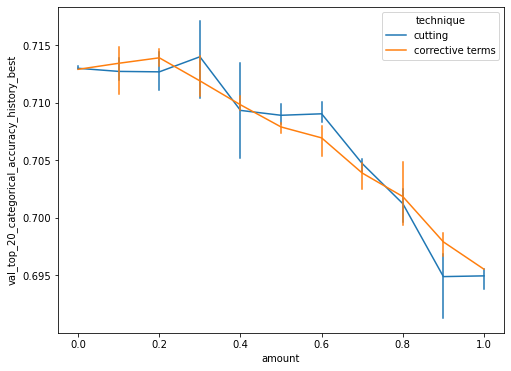

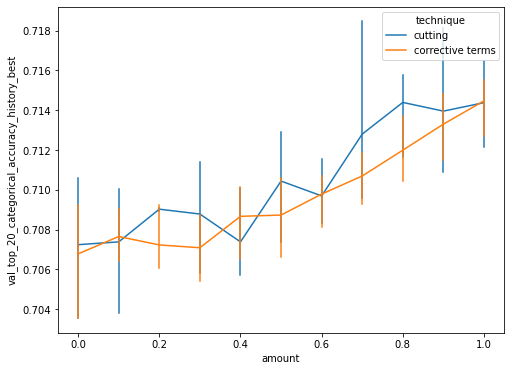

In [70]:
adding_df = pd.DataFrame.from_records(adding, columns=["info_run_id", "amount"])
removing_df = pd.DataFrame.from_records(removing, columns=["info_run_id", "amount"])

plt.figure(figsize=(8, 6))
g = sns.lineplot(data=pd.merge(adding_df, accuracy_adding_df, on="info_run_id"),
x="amount",
y="val_top_20_categorical_accuracy_history_best",
err_style="bars",
hue="technique")

fig = plt.gcf()
fig.savefig("potential_real.png", format="png", facecolor="white", dpi=300)
fig.savefig("potential_real.svg", format="svg", facecolor="white")

plt.figure(figsize=(8, 6))
g = sns.lineplot(data=pd.merge(removing_df, accuracy_removing_df, on="info_run_id"),
x="amount",
y="val_top_20_categorical_accuracy_history_best",
err_style="bars",
hue="technique")

fig = plt.gcf()
fig.savefig("potential_artificial.png", format="png", facecolor="white", dpi=300)
fig.savefig("potential_artificial.svg", format="svg", facecolor="white")

# High-level metrics

## Domain knowledge benefits low frequency inputs

Calculating accuracy@k per percentile: 100%|██████████| 11/11 [02:48<00:00, 15.28s/it]


(0.0, 0.05)

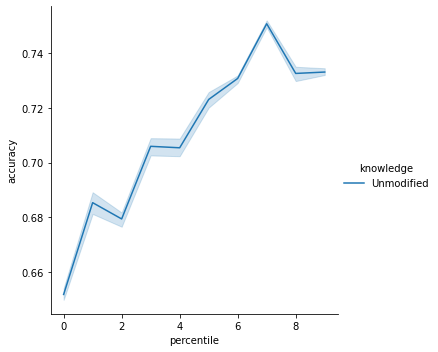

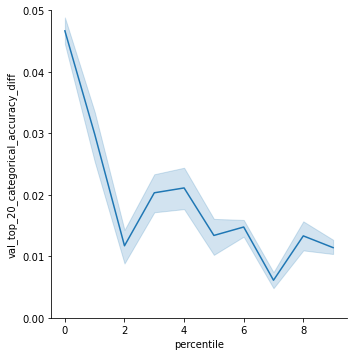

In [15]:
# Recreates a plot from DomainML for the accuracy per input-percentile to show that rare features benefit the most

reference_run_id = "1bdceb1e06b34f949447dc4d006ea9fe"

relevant_runs = {
    "d5b778d8f909447baa8f8c709aedbf07": "Unmodified",
    "fa6729fc421c49a4a16cbdea6b85f7e6": "Unmodified",

    "05c024bc5c364e589026fb2b36624d90": "Unmodified",
    "e2bd826b14d04ebca35d9ad7074beb6f": "Unmodified",
    "68d6d85ca1464f32a8bdc9e62b1cb1b8": "Unmodified",
    "1c9f9a073ef7443795567f4871e8a51f": "Unmodified",
    "28c589f93c59497d9b57829a5ac1bdb5": "Unmodified",
    "8f178ac5caab4ec58308e03d5ab2cb8d": "Unmodified",
    "d62adbe6084f400098902aefa078631a": "Unmodified",
    "8cc4d3c33ca1424ca2a5a67a7a558a10": "Unmodified",
    "8a6ad0d378e148948da6efabdd14a751": "Unmodified",
}

reference_run_df = calculate_accuracies_per_percentiles(
    relevant_run_df=mlflow_helper.run_df[mlflow_helper.run_df["info_run_id"] == reference_run_id],
        k=20, num_percentiles=10, num_input_percentiles=10,
        percentile_names=[
            'avg_input_frequencies_percentile', 
            'median_input_frequencies_percentile', 
            'min_input_frequencies_percentile', 
            'p10_input_frequencies_percentile', 
            'unknown_inputs_percentile', 
            'output_frequency_percentile',
            'avg_input_frequencies_range', 
            'median_input_frequencies_range', 
            'min_input_frequencies_range', 
            'p10_input_frequencies_range', 
            'unknown_inputs_range', 
        ],
        local_mlflow_dir=mlflow_helper.local_mlflow_dir
)

relevant_runs_df = calculate_accuracies_per_percentiles(
        relevant_run_df=mlflow_helper.run_df[mlflow_helper.run_df["info_run_id"].isin(list(relevant_runs.keys()))],
        k=20, num_percentiles=10, num_input_percentiles=10,
        percentile_names=[
            'avg_input_frequencies_percentile', 
            'median_input_frequencies_percentile', 
            'min_input_frequencies_percentile', 
            'p10_input_frequencies_percentile', 
            'unknown_inputs_percentile', 
            'output_frequency_percentile',
            'avg_input_frequencies_range', 
            'median_input_frequencies_range', 
            'min_input_frequencies_range', 
            'p10_input_frequencies_range', 
            'unknown_inputs_range', 
        ],
        local_mlflow_dir=mlflow_helper.local_mlflow_dir)

relevant_runs_df["info_run_id"] = relevant_runs_df["run_id"]
relevant_runs_df["knowledge"] = relevant_runs_df["info_run_id"].apply(lambda x: relevant_runs.get(x, ""))

def _calculate_accuracy_diff(percentile, accuracy):
    reference_accuracy = reference_run_df[(reference_run_df["type"] == "avg_input_frequencies_percentile") & (reference_run_df["percentile"] == percentile)]["accuracy"].item()

    return accuracy - reference_accuracy

relevant_runs_df["val_top_20_categorical_accuracy_diff"] = relevant_runs_df[(relevant_runs_df["type"] == "avg_input_frequencies_percentile") & (relevant_runs_df["percentile"] > -1)].apply(lambda x: _calculate_accuracy_diff(x["percentile"], x["accuracy"]), axis=1)

fig = sns.relplot(data=relevant_runs_df[(relevant_runs_df["type"] == "avg_input_frequencies_percentile") & (relevant_runs_df["percentile"] > -1)],
x="percentile",
y="accuracy",
hue="knowledge",
kind="line")

fig = sns.relplot(data=relevant_runs_df[(relevant_runs_df["type"] == "avg_input_frequencies_percentile") & (relevant_runs_df["percentile"] > -1)],
x="percentile",
y="val_top_20_categorical_accuracy_diff",
kind="line")
fig.axes[0, 0].set_ylim((0, 0.05))

In [16]:
fig.savefig("per_percentile_accuracy_diff.png", format="png", facecolor="white", dpi=300)

## Not all domain knowledge is used

In [35]:
def get_percentage_ignored(run_id: str):
    attention_data = get_attention_for_run(run_id)

    flattened_attention = [(child, parent, attention) for child, parents in attention_data.items() for parent, attention in parents.items() if child != parent]
    ignored_edges = [(child, parent) for child, parent, attention in flattened_attention if float(attention) < 0.01]

    num_total = len(flattened_attention)
    num_ignored = len(ignored_edges)

    percentage_ignored = round(num_ignored / num_total * 100.0, ndigits=2)
    return percentage_ignored

In [36]:
get_percentage_ignored("d5b778d8f909447baa8f8c709aedbf07") # Original knowledge (new order)

47.59

In [37]:
get_percentage_ignored("1a4e0ddc634342fab22095d67887ee88") # 50% of added edges

53.11

In [38]:

get_percentage_ignored("0e3df611a8a64117a5740d81d929c557") # 100% added edges

63.28

In [39]:
get_percentage_ignored("571864b4c21148689cc6bb3ba9c57033") # Replaced 50% of real edges with artificial edges

53.82

## Actual performance of refinement

In [ ]:
# This section shows the actual performance of various refinement approaches. The first function is required for all subsequent subcategories

In [65]:
from typing import Optional

def get_comparison_ids_from_run(accuracy_df_p, refinement_run: str):
    relevant_runs_df = accuracy_df_p[accuracy_df_p["refinement_run"] == refinement_run]

    reference_id_candidates = relevant_runs_df[relevant_runs_df["refinement_type"] == "reference"]

    if len(reference_id_candidates) > 0:
        reference_id = reference_id_candidates["info_run_id"].drop_duplicates().item()
    else:
        reference_id = None

    original_id = relevant_runs_df[relevant_runs_df["refinement_type"] == "original"]["info_run_id"].drop_duplicates().item()

    last_refinement_run_order = relevant_runs_df["refinement_type_order"].max()
    last_refinement_run_id = relevant_runs_df[relevant_runs_df["refinement_type_order"] == last_refinement_run_order]["info_run_id"].drop_duplicates().item()

    return {"reference": reference_id, "original": original_id, "refined": last_refinement_run_id}

def load_accuracy_df_p_for_ids(
    from_dict: Optional[Dict[str, str]] = None,
    from_list: Optional[List[str]] = None
):
    if from_dict is not None:
        ids = list(from_dict.values())
    elif from_list is not None:
        ids = from_list
    else:
        print("specify from_dict or from_list")
        return

    relevant_runs_df = mlflow_helper.run_df[mlflow_helper.run_df["info_run_id"].isin(ids)]

    result_df = calculate_accuracies_per_percentiles(
        relevant_run_df=relevant_runs_df,
        k=20, num_percentiles=10, num_input_percentiles=10,
        percentile_names=[
            'avg_input_frequencies_percentile', 
            'median_input_frequencies_percentile', 
            'min_input_frequencies_percentile', 
            'p10_input_frequencies_percentile', 
            'unknown_inputs_percentile', 
            'output_frequency_percentile',
            'avg_input_frequencies_range', 
            'median_input_frequencies_range', 
            'min_input_frequencies_range', 
            'p10_input_frequencies_range', 
            'unknown_inputs_range', 
        ],
        local_mlflow_dir=mlflow_helper.local_mlflow_dir)

    result_df["info_run_id"] = result_df["run_id"]

    return result_df.merge(relevant_runs_df, on="info_run_id")

def get_accuracy_difference_from_refinement(
    accuracy_df_p: pd.DataFrame,
    from_run: Optional[str] = None,
    from_ids: Optional[Dict[str, str]] = None
):
    if from_run is not None:
        ids = get_comparison_ids_from_run(accuracy_df_p, from_run)
    elif from_ids is not None:
        ids = from_ids
    else:
        print("specify from_run or from_ids")
        return
    
    relevant_runs_df = accuracy_df_p[(accuracy_df_p["info_run_id"].isin(ids.values()) & (accuracy_df_p["type"] == "input_percentile"))].copy(deep=True)

    if from_run is not None:
        relevant_runs_df = relevant_runs_df[relevant_runs_df["refinement_run"] == from_run]

    relevant_runs_df = relevant_runs_df.drop_duplicates(subset=["info_run_id", "type", "percentile"])

    has_reference = "reference" in ids and ids["reference"] is not None
    has_original = "original" in ids
    has_refinement = "refined" in ids

    if has_reference:
        reference_df = relevant_runs_df[relevant_runs_df["info_run_id"] == ids["reference"]]
    
    if has_original:
        original_df = relevant_runs_df[relevant_runs_df["info_run_id"] == ids["original"]]
        num_connections_original = original_df["data_metrics_num_connections"].min()

    if has_refinement:
        last_refinement_run_df = relevant_runs_df[relevant_runs_df["info_run_id"] == ids["refined"]]
        num_connections_refinement = last_refinement_run_df["data_metrics_num_connections"].min()

    overall = []
    per_percentile = []

    reference_original_diff = []
    reference_refinement_diff = []
    original_refinement_diff = []

    for percentile in set(relevant_runs_df["percentile"]):
        if has_reference:
            reference_accuracy = reference_df[reference_df["percentile"] == percentile]["accuracy"].item()

            if percentile == -1:
                overall.append(("reference", reference_accuracy))
            else:
                per_percentile.append(("reference", percentile, reference_accuracy))
        
        if has_original:
            original_accuracy = original_df[original_df["percentile"] == percentile]["accuracy"].item()

            if percentile == -1:
                overall.append(("original", original_accuracy))
            else:
                if has_reference:
                    reference_original_diff.append(original_accuracy - reference_accuracy)
                per_percentile.append(("original", percentile, original_accuracy))

        if has_refinement:
            last_refinement_run_accuracy = last_refinement_run_df[last_refinement_run_df["percentile"] == percentile]["accuracy"].item()

            if percentile == -1:
                overall.append(("refined", last_refinement_run_accuracy))
            else:
                if has_reference:
                    reference_refinement_diff.append(last_refinement_run_accuracy - reference_accuracy)
                if has_original:
                    original_refinement_diff.append(last_refinement_run_accuracy - original_accuracy)
                per_percentile.append(("refined", percentile, last_refinement_run_accuracy))

    if len(reference_original_diff) > 0:
        print("Max reference/original per-percentile improvement: {} (in percentile {})".format(max(reference_original_diff), np.argmax(reference_original_diff)))

    if len(reference_refinement_diff) > 0:
        print("Max reference/refinement per-percentile improvement: {} (in percentile {})".format(max(reference_refinement_diff), np.argmax(reference_refinement_diff)))

    if len(original_refinement_diff) > 0:
        print("Max original/refinement per-percentile improvement: {} (in percentile {})".format(max(original_refinement_diff), np.argmax(original_refinement_diff)))
        print("Num connections before {} / after {} (diff: {})".format(num_connections_original, num_connections_refinement, num_connections_refinement - num_connections_original))
        original_refinement_diff = list(np.round(original_refinement_diff, decimals=4))
        print(" & ".join(map(str, original_refinement_diff)))

    overall_df = pd.DataFrame.from_records(overall, columns=["type", "accuracy"])
    per_percentile_df = pd.DataFrame.from_records(per_percentile, columns=["type", "percentile", "accuracy"])

    plt.figure(figsize=(7, 4))
    ax = sns.lineplot(data=per_percentile_df,
        x="percentile",
        y="accuracy",
        hue="type"
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.get_legend().remove()
    ax.set(xticklabels=[])
    ax.set(xlabel=None)
    ax.tick_params(bottom=False)

    if has_original:
        print_percentage_of_artificial_edges_removed(ids["original"], ids["refined"] if has_refinement else None)

    return overall_df, ax

def print_percentage_of_artificial_edges_removed(
    original_run_id: str,
    refinement_run_id: Optional[str],
    original_knowledge_path: str = "../data/gram_original_file_knowledge.json"
):
    with open(original_knowledge_path) as f:
        original_knowledge = json.load(f)

    original_attention = get_attention_for_run(original_run_id)
    original_artificial_edges = []

    for child, parents in original_attention.items():
        for parent, attention in parents.items():
            if not child in original_knowledge or not parent in original_knowledge[child]:
                original_artificial_edges.append((child, parent, attention))

    num_artificial_original = len(original_artificial_edges)

    if num_artificial_original == 0:
        return

    print("Number of artificial edges in original: {}".format(num_artificial_original))

    original_non_ignored_artificial_edges = [(child, parent) for child,parent,attention in original_artificial_edges if float(attention) > 0.01]
    
    num_non_ignored_artificial_original = len(original_non_ignored_artificial_edges)
    percentage_non_ignored_artificial_original = round(num_non_ignored_artificial_original / num_artificial_original * 100.0, ndigits=2)

    print("Number of non-ignored artificial edges in original: {} ({}%)".format(num_non_ignored_artificial_original, percentage_non_ignored_artificial_original))

    if refinement_run_id is not None:
        refined_attention = get_attention_for_run(refinement_run_id)
        refined_artificial_edges = []

        for child, parents in refined_attention.items():
            for parent, attention in parents.items():
                if not child in original_knowledge or not parent in original_knowledge[child]:
                    refined_artificial_edges.append((child, parent, attention))

        num_artificial_refined = len(refined_artificial_edges)
        print("Number of artificial edges in refined: {}".format(num_artificial_refined))

        num_artificial_removed = num_artificial_original - num_artificial_refined
        percentage_artificial_removed = round(num_artificial_removed / num_artificial_original * 100.0, ndigits=2)

        print("Number of artificial edges removed: {} ({}%)".format(num_artificial_removed, percentage_artificial_removed))

        refined_non_ignored_artificial_edges = [(child, parent) for child,parent,attention in refined_artificial_edges if float(attention) > 0.01]

        num_non_ignored_artificial_refined = len(refined_non_ignored_artificial_edges)
        percentage_non_ignored_artificial_refined = round(num_non_ignored_artificial_refined / num_artificial_refined * 100.0, ndigits=2)

        print("Number of non-ignored artificial edges in refined: {} ({}%)".format(num_non_ignored_artificial_refined, percentage_non_ignored_artificial_refined))

        num_artificial_ignored_removed = num_non_ignored_artificial_original - num_non_ignored_artificial_refined
        percentage_artificial_ignored_removed = round(num_artificial_ignored_removed / num_non_ignored_artificial_original * 100.0, ndigits=2)

        print("Number of artificial edges removed or ignored: {} ({}%)".format(num_non_ignored_artificial_refined, percentage_artificial_ignored_removed))

### No knowledge

Calculating accuracy@k per percentile: 100%|██████████| 1/1 [00:15<00:00, 15.16s/it]


,type,accuracy
0,reference,0.693804


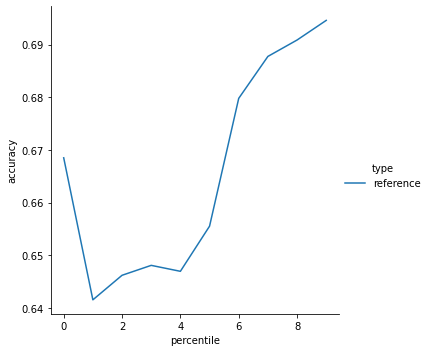

In [37]:
runs = {"reference": "1bdceb1e06b34f949447dc4d006ea9fe"}
accuracy_p_lookup = load_accuracy_df_p_for_ids(from_dict=runs)
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_p_lookup, from_ids=runs)
overall_df

### Unmodified

Calculating accuracy@k per percentile: 100%|██████████| 2/2 [00:34<00:00, 17.24s/it]

Max reference/original per-percentile improvement: 0.031932773109243695 (in percentile 2)


,type,accuracy
0,reference,0.693804
1,original,0.713185


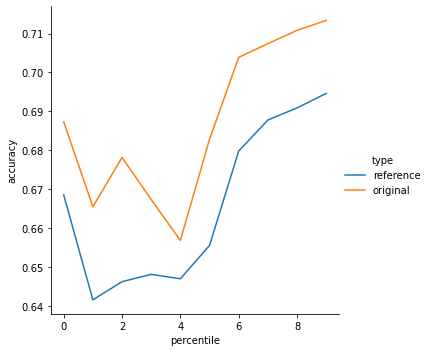

In [38]:
# Original hierarchy
runs = {"reference": "1bdceb1e06b34f949447dc4d006ea9fe", "original": "d5b778d8f909447baa8f8c709aedbf07"}
accuracy_p_lookup = load_accuracy_df_p_for_ids(from_dict=runs)
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_p_lookup, from_ids=runs)
overall_df

Calculating accuracy@k per percentile: 100%|██████████| 2/2 [00:31<00:00, 15.61s/it]


Max reference/original per-percentile improvement: 0.029530744336569548 (in percentile 5)
Number of artificial edges in original: 10864
Number of non-ignored artificial edges in original: 4620 (42.53%)


,type,accuracy
0,reference,0.693804
1,original,0.712761


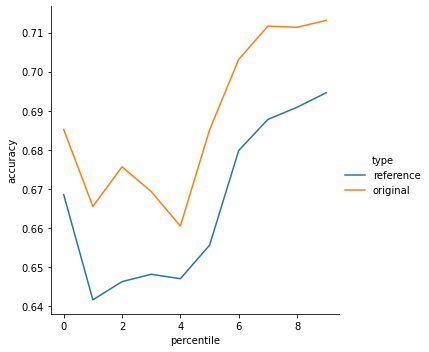

In [43]:
# 50% of added edges
runs = {"reference": "1bdceb1e06b34f949447dc4d006ea9fe", "original": "1a4e0ddc634342fab22095d67887ee88"}
accuracy_p_lookup = load_accuracy_df_p_for_ids(from_dict=runs)
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_p_lookup, from_ids=runs)
overall_df

Calculating accuracy@k per percentile: 100%|██████████| 2/2 [00:31<00:00, 15.77s/it]


Max reference/original per-percentile improvement: 0.020168067226890685 (in percentile 2)
Number of artificial edges in original: 21729
Number of non-ignored artificial edges in original: 6824 (31.41%)


,type,accuracy
0,reference,0.693804
1,original,0.705171


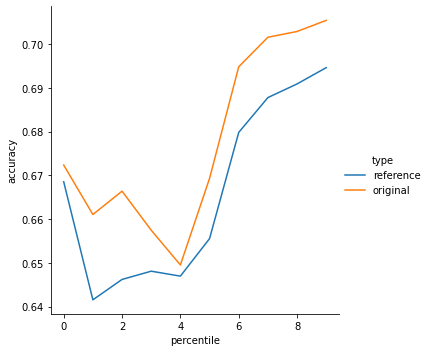

In [44]:
# 100% of added edges
runs = {"reference": "1bdceb1e06b34f949447dc4d006ea9fe", "original": "0e3df611a8a64117a5740d81d929c557"}
accuracy_p_lookup = load_accuracy_df_p_for_ids(from_dict=runs)
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_p_lookup, from_ids=runs)
overall_df

Calculating accuracy@k per percentile: 100%|██████████| 2/2 [00:30<00:00, 15.49s/it]


Max reference/original per-percentile improvement: 0.026890756302521024 (in percentile 2)
Number of artificial edges in original: 10851
Number of non-ignored artificial edges in original: 4705 (43.36%)


,type,accuracy
0,reference,0.693804
1,original,0.704130


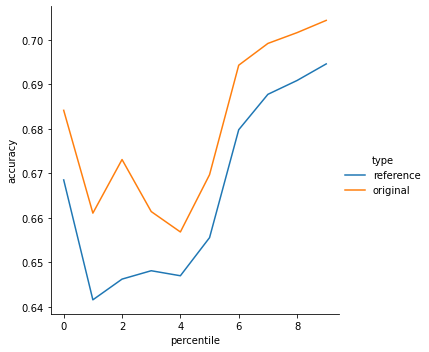

In [45]:
# Replaced 50% of real edges with artificial edges
runs = {"reference": "1bdceb1e06b34f949447dc4d006ea9fe", "original": "571864b4c21148689cc6bb3ba9c57033"}
accuracy_p_lookup = load_accuracy_df_p_for_ids(from_dict=runs)
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_p_lookup, from_ids=runs)
overall_df

### Corrective terms

#### w/ retraining

Max reference/original per-percentile improvement: 0.031932773109243695 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.031932773109243695 (in percentile 2)
Max original/refinement per-percentile improvement: 0.008752735229759279 (in percentile 4)
Num connections before 26608.0 / after nan (diff: nan)
-0.0024&0.0035&0.0&0.0039&0.0088&0.0022&0.0041&0.0041&0.0037&0.0027


,type,accuracy
0,reference,0.693804
1,original,0.713185
2,refined,0.715959


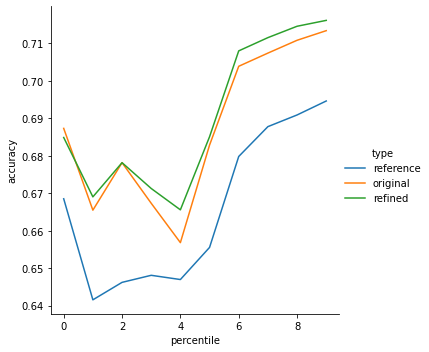

In [85]:
# Original hierarchy
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659379291.8943748")
overall_df

Max reference/original per-percentile improvement: 0.029530744336569548 (in percentile 5)
Max reference/refinement per-percentile improvement: 0.031092436974789917 (in percentile 2)
Max original/refinement per-percentile improvement: 0.001680672268907557 (in percentile 2)
Num connections before 37472.0 / after nan (diff: nan)
-0.0073 & 0.0004 & 0.0017 & 0.0 & -0.0036 & -0.0032 & -0.0008 & -0.0018 & -0.0002 & 0.0002
Number of artificial edges in original: 10864
Number of non-ignored artificial edges in original: 4620 (42.53%)
Number of artificial edges in refined: 10864
Number of artificial edges removed: 0 (0.0%)
Number of non-ignored artificial edges in refined: 3493 (32.15%)
Number of artificial edges removed or ignored: 3493 (24.39%)


,type,accuracy
0,reference,0.693804
1,original,0.712761
2,refined,0.712954


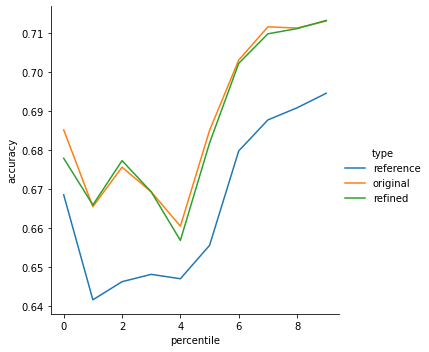

In [91]:
# 50% of added edges
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659380775.2773757")
overall_df

Max reference/original per-percentile improvement: 0.020168067226890685 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.024369747899159577 (in percentile 2)
Max original/refinement per-percentile improvement: 0.0051057622173595885 (in percentile 4)
Num connections before 48337.0 / after nan (diff: nan)
0.0024 & 0.0031 & 0.0042 & -0.0034 & 0.0051 & -0.0028 & -0.0013 & 0.0014 & 0.0022 & 0.0023
Number of artificial edges in original: 21729
Number of non-ignored artificial edges in original: 6824 (31.41%)
Number of artificial edges in refined: 21729
Number of artificial edges removed: 0 (0.0%)
Number of non-ignored artificial edges in refined: 5804 (26.71%)
Number of artificial edges removed or ignored: 5804 (14.95%)


,type,accuracy
0,reference,0.693804
1,original,0.705171
2,refined,0.707521


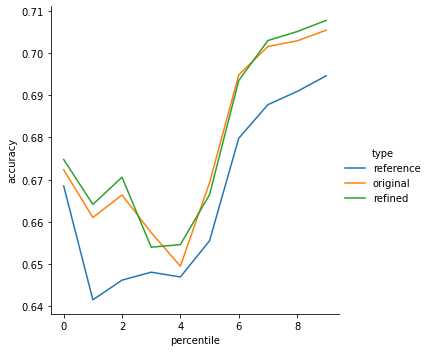

In [92]:
# 100% of added edges
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659382309.2322617")
overall_df

Max reference/original per-percentile improvement: 0.026890756302521024 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.023039432875498478 (in percentile 1)
Max original/refinement per-percentile improvement: 0.005421389847215408 (in percentile 3)
Num connections before 26609.0 / after nan (diff: nan)
0.0042 & 0.0035 & -0.0076 & 0.0054 & 0.0004 & 0.002 & 0.0 & 0.0008 & 0.0009 & 0.0014
Number of artificial edges in original: 10851
Number of non-ignored artificial edges in original: 4705 (43.36%)
Number of artificial edges in refined: 10851
Number of artificial edges removed: 0 (0.0%)
Number of non-ignored artificial edges in refined: 4190 (38.61%)
Number of artificial edges removed or ignored: 4190 (10.95%)


,type,accuracy
0,reference,0.693804
1,original,0.704130
2,refined,0.705517


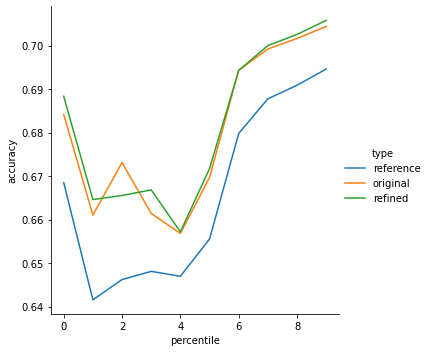

In [93]:
# Replaced 50% of real edges with artificial edges
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659384022.389457")
overall_df

#### w/o retraining

Max reference/original per-percentile improvement: 0.031932773109243695 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.031932773109243695 (in percentile 2)
Max original/refinement per-percentile improvement: 0.0048737261852016545 (in percentile 1)
Num connections before 26608.0 / after nan (diff: nan)
0.0 & 0.0049 & 0.0 & 0.0025 & 0.0011 & 0.0006 & 0.0005 & 0.0009 & 0.0005 & 0.0005


,type,accuracy
0,reference,0.693804
1,original,0.713185
2,refined,0.713686


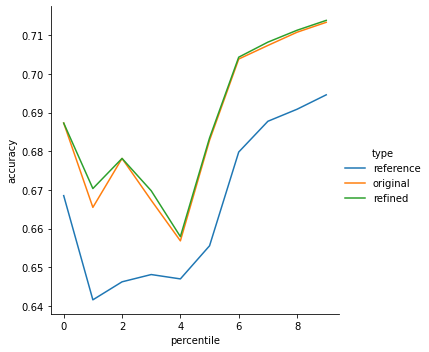

In [87]:
# Original hierarchy
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659425700.773342")
overall_df

Max reference/original per-percentile improvement: 0.029530744336569548 (in percentile 5)
Max reference/refinement per-percentile improvement: 0.03033980582524265 (in percentile 5)
Max original/refinement per-percentile improvement: 0.003449975357318835 (in percentile 3)
Num connections before 37472.0 / after nan (diff: nan)
0.0017 & 0.0027 & -0.0017 & 0.0034 & 0.0015 & 0.0008 & 0.0012 & 0.0015 & 0.0009 & 0.0007
Number of artificial edges in original: 10864
Number of non-ignored artificial edges in original: 4620 (42.53%)
Number of artificial edges in refined: 10864
Number of artificial edges removed: 0 (0.0%)
Number of non-ignored artificial edges in refined: 4508 (41.49%)
Number of artificial edges removed or ignored: 4508 (2.42%)


,type,accuracy
0,reference,0.693804
1,original,0.712761
2,refined,0.713493


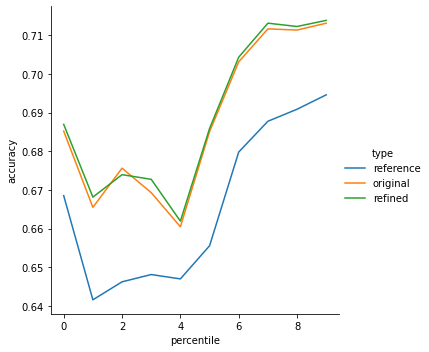

In [94]:
# 50% of added edges
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659426618.1831427")
overall_df

Max reference/original per-percentile improvement: 0.020168067226890685 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.02184873949579824 (in percentile 2)
Max original/refinement per-percentile improvement: 0.001680672268907557 (in percentile 2)
Num connections before 48337.0 / after nan (diff: nan)
-0.001 & 0.0 & 0.0017 & 0.0015 & -0.0007 & -0.0012 & -0.0006 & 0.0002 & 0.0002 & 0.0002
Number of artificial edges in original: 21729
Number of non-ignored artificial edges in original: 6824 (31.41%)
Number of artificial edges in refined: 21729
Number of artificial edges removed: 0 (0.0%)
Number of non-ignored artificial edges in refined: 6684 (30.76%)
Number of artificial edges removed or ignored: 6684 (2.05%)


,type,accuracy
0,reference,0.693804
1,original,0.705171
2,refined,0.705325


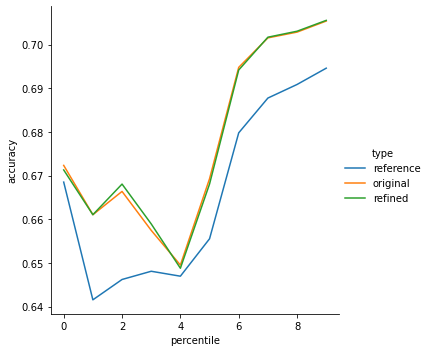

In [95]:
# !00% of added edges
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659427604.9604075")
overall_df

Max reference/original per-percentile improvement: 0.026890756302521024 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.027731092436974802 (in percentile 2)
Max original/refinement per-percentile improvement: 0.0022153300841825097 (in percentile 1)
Num connections before 26609.0 / after nan (diff: nan)
0.0014 & 0.0022 & 0.0008 & 0.002 & 0.0015 & 0.0 & 0.0013 & 0.0002 & 0.0004 & 0.0007
Number of artificial edges in original: 10851
Number of non-ignored artificial edges in original: 4705 (43.36%)
Number of artificial edges in refined: 10851
Number of artificial edges removed: 0 (0.0%)
Number of non-ignored artificial edges in refined: 4616 (42.54%)
Number of artificial edges removed or ignored: 4616 (1.89%)


,type,accuracy
0,reference,0.693804
1,original,0.704130
2,refined,0.704862


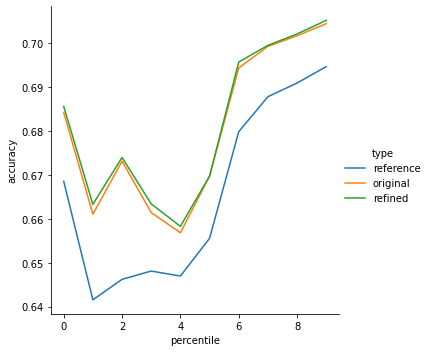

In [96]:
# Replaced 50% of real edges with artificial edges
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659428699.9351587")
overall_df

### Cutting

Max reference/original per-percentile improvement: 0.031932773109243695 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.03810367744793974 (in percentile 1)
Max original/refinement per-percentile improvement: 0.012848914488258756 (in percentile 1)
Num connections before 26608.0 / after 25319.0 (diff: -1289.0)
-0.0049 & 0.0128 & 0.0042 & 0.0079 & 0.0036 & 0.0034 & 0.0057 & 0.0062 & 0.0041 & 0.0038


,type,accuracy
0,reference,0.695538
1,original,0.712915
2,refined,0.716498


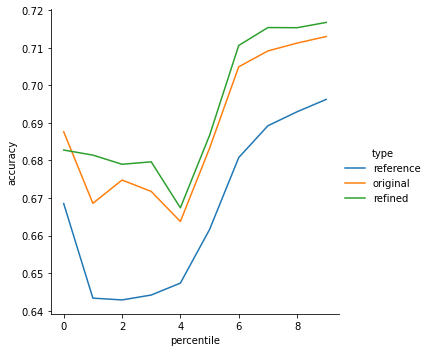

In [88]:
# Original hierarchy
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659355203.587408")
overall_df

Max reference/original per-percentile improvement: 0.032773109243697474 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.036974789915966366 (in percentile 2)
Max original/refinement per-percentile improvement: 0.004201680672268893 (in percentile 2)
Num connections before 37472.0 / after 35207.0 (diff: -2265.0)
-0.0104 & 0.0035 & 0.0042 & 0.0015 & 0.0011 & -0.004 & -0.0013 & -0.0065 & -0.0028 & -0.0024
Number of artificial edges in original: 10864
Number of non-ignored artificial edges in original: 4620 (42.53%)
Number of artificial edges in refined: 10095
Number of artificial edges removed: 769 (7.08%)
Number of non-ignored artificial edges in refined: 3865 (38.29%)
Number of artificial edges removed or ignored: 3865 (16.34%)


,type,accuracy
0,reference,0.695538
1,original,0.712761
2,refined,0.710334


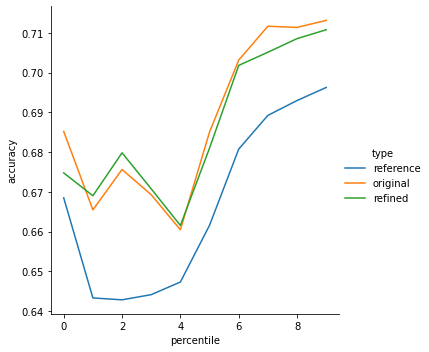

In [97]:
# 50% of added edges
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659359812.0850606")
overall_df

Max reference/original per-percentile improvement: 0.0235294117647058 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.037815126050420145 (in percentile 2)
Max original/refinement per-percentile improvement: 0.014285714285714346 (in percentile 2)
Num connections before 48337.0 / after 44790.0 (diff: -3547.0)
0.0042 & 0.0071 & 0.0143 & 0.0064 & 0.0106 & 0.0083 & 0.0031 & 0.0039 & 0.0036 & 0.0035
Number of artificial edges in original: 21729
Number of non-ignored artificial edges in original: 6824 (31.41%)
Number of artificial edges in refined: 19863
Number of artificial edges removed: 1866 (8.59%)
Number of non-ignored artificial edges in refined: 4021 (20.24%)
Number of artificial edges removed or ignored: 4021 (41.08%)


,type,accuracy
0,reference,0.695538
1,original,0.705171
2,refined,0.708523


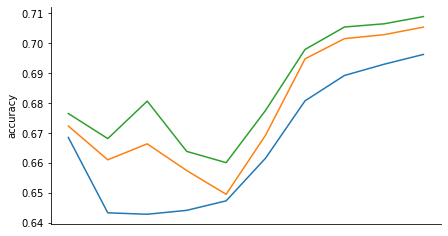

In [66]:
# 100% of added edges
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659364527.8255856")
overall_df

Max reference/original per-percentile improvement: 0.030252100840336138 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.015950376606114314 (in percentile 1)
Max original/refinement per-percentile improvement: 0.0017908588336058573 (in percentile 7)
Num connections before 26609.0 / after 24369.0 (diff: -2240.0)
-0.0077 & -0.0018 & -0.0252 & -0.003 & 0.0004 & -0.0006 & -0.0042 & 0.0018 & 0.0013 & 0.0009
Number of artificial edges in original: 10851
Number of non-ignored artificial edges in original: 4705 (43.36%)
Number of artificial edges in refined: 9683
Number of artificial edges removed: 1168 (10.76%)
Number of non-ignored artificial edges in refined: 3756 (38.79%)
Number of artificial edges removed or ignored: 3756 (20.17%)


,type,accuracy
0,reference,0.695538
1,original,0.704130
2,refined,0.704901


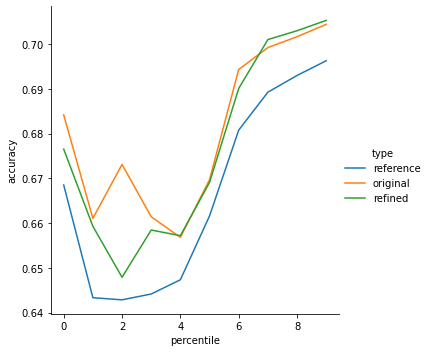

In [99]:
# Replaced 50% of real edges with artificial edges
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659369933.8746045")
overall_df

### Generation

Max original/refinement per-percentile improvement: 0.012405848471422232 (in percentile 1)
Num connections before 26608.0 / after 27791.0 (diff: 1183.0)
-0.0038 & 0.0124 & 0.0008 & 0.0044 & 0.0113 & 0.003 & 0.0015 & 0.0056 & 0.0042 & 0.0018


,type,accuracy
0,original,0.713185
1,refined,0.714880


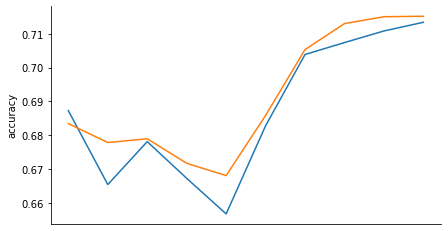

In [68]:
# Original hierarchy
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659434149.1472573")
overall_df

Max original/refinement per-percentile improvement: 0.009482129832239172 (in percentile 4)
Num connections before 15744.0 / after 17519.0 (diff: 1775.0)
-0.0014 & 0.0053 & -0.0151 & -0.0049 & 0.0095 & 0.0018 & -0.0008 & 0.0019 & 0.0022 & 0.0007


,type,accuracy
0,original,0.708947
1,refined,0.709486


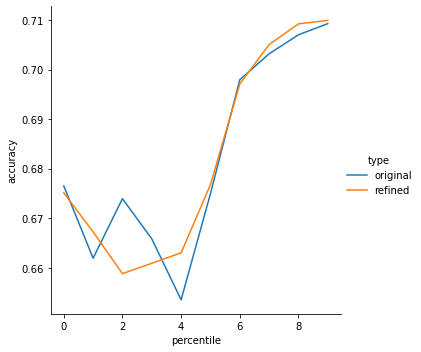

In [9]:
# 50% of edges removed
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_run="1659521826.0250905")
overall_df

### Distribution enforcement

Max reference/original per-percentile improvement: 0.031932773109243695 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.031932773109243695 (in percentile 2)
Max original/refinement per-percentile improvement: 0.0 (in percentile 2)
Num connections before 26608.0 / after 26608.0 (diff: 0.0)
-0.0014 & -0.0031 & 0.0 & -0.002 & -0.0018 & -0.0006 & -0.0001 & -0.0005 & -0.0004 & -0.0004


,type,accuracy
0,reference,0.693804
1,original,0.713185
2,refined,0.712877


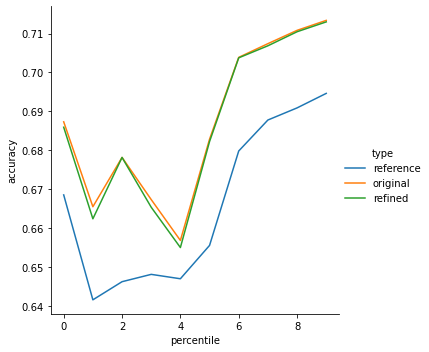

In [89]:
# Original hierarchy, without retraining
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_ids={"reference": "1bdceb1e06b34f949447dc4d006ea9fe", "original": "d5b778d8f909447baa8f8c709aedbf07", "refined": "6fbe649684fc4f8bb55849affd0164d8"})
overall_df

Max reference/original per-percentile improvement: 0.029530744336569548 (in percentile 5)
Max reference/refinement per-percentile improvement: 0.03613445378151259 (in percentile 2)
Max original/refinement per-percentile improvement: 0.006722689075630228 (in percentile 2)
Num connections before 37472.0 / after 37472.0 (diff: 0.0)
0.0014 & 0.004 & 0.0067 & 0.001 & 0.0018 & -0.0008 & 0.0001 & 0.0003 & 0.0001 & 0.0
Number of artificial edges in original: 10864
Number of non-ignored artificial edges in original: 4620 (42.53%)
Number of artificial edges in refined: 10864
Number of artificial edges removed: 0 (0.0%)
Number of non-ignored artificial edges in refined: 4618 (42.51%)
Number of artificial edges removed or ignored: 4618 (0.04%)


,type,accuracy
0,reference,0.693804
1,original,0.712761
2,refined,0.712877


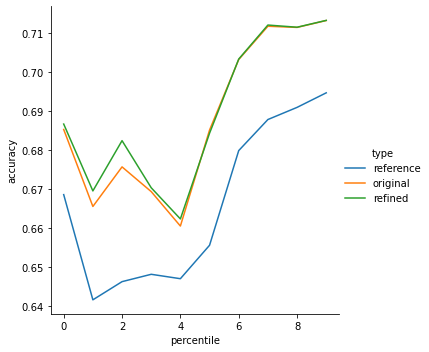

In [100]:
# 50% of added edges, without retraining
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_ids={"reference": "1bdceb1e06b34f949447dc4d006ea9fe", "original": "1a4e0ddc634342fab22095d67887ee88", "refined": "80adc630691a42e1ad6989e4138346ea"})
overall_df

Max reference/original per-percentile improvement: 0.020168067226890685 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.01993797075764292 (in percentile 1)
Max original/refinement per-percentile improvement: 0.00044306601683652413 (in percentile 1)
Num connections before 48337.0 / after 48337.0 (diff: 0.0)
-0.001 & 0.0004 & -0.0084 & -0.001 & 0.0004 & -0.0014 & -0.0001 & -0.0002 & -0.0004 & -0.0004
Number of artificial edges in original: 21729
Number of non-ignored artificial edges in original: 6824 (31.41%)
Number of artificial edges in refined: 21729
Number of artificial edges removed: 0 (0.0%)
Number of non-ignored artificial edges in refined: 6856 (31.55%)
Number of artificial edges removed or ignored: 6856 (-0.47%)


,type,accuracy
0,reference,0.693804
1,original,0.705171
2,refined,0.704785


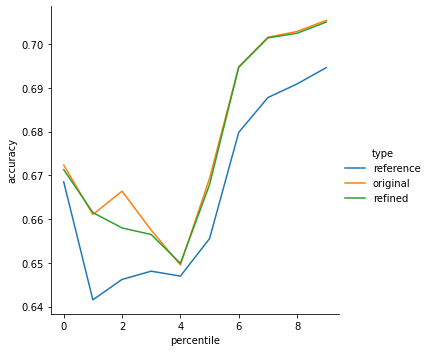

In [101]:
# 100% of added edges, without retraining
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_ids={"reference": "1bdceb1e06b34f949447dc4d006ea9fe", "original": "0e3df611a8a64117a5740d81d929c557", "refined": "a34202c6434c42d48d67bebdf5e69d1d"})
overall_df

Max reference/original per-percentile improvement: 0.026890756302521024 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.02268907563025202 (in percentile 2)
Max original/refinement per-percentile improvement: 0.0029571217348447476 (in percentile 3)
Num connections before 26609.0 / after 26609.0 (diff: 0.0)
-0.0003 & 0.0013 & -0.0042 & 0.003 & 0.0007 & -0.001 & -0.0002 & 0.0002 & 0.0 & -0.0
Number of artificial edges in original: 10851
Number of non-ignored artificial edges in original: 4705 (43.36%)
Number of artificial edges in refined: 10851
Number of artificial edges removed: 0 (0.0%)
Number of non-ignored artificial edges in refined: 4710 (43.41%)
Number of artificial edges removed or ignored: 4710 (-0.11%)


,type,accuracy
0,reference,0.693804
1,original,0.704130
2,refined,0.704053


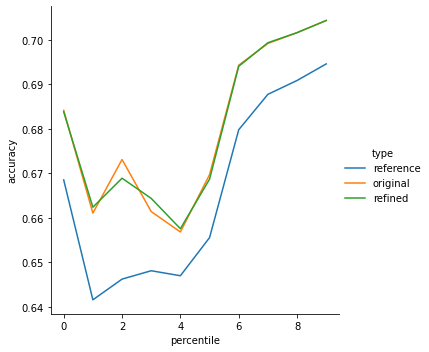

In [102]:
# Replaced 50% of real edges with artificial edges, without retraining
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_ids={"reference": "1bdceb1e06b34f949447dc4d006ea9fe", "original": "571864b4c21148689cc6bb3ba9c57033", "refined": "c7f76ea655c14c2eb49cee10531efec7"})
overall_df

Max reference/original per-percentile improvement: 0.031932773109243695 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.03361344537815125 (in percentile 2)
Max original/refinement per-percentile improvement: 0.0048737261852016545 (in percentile 1)
Num connections before 26608.0 / after 26608.0 (diff: 0.0)
-0.0021 & 0.0049 & 0.0017 & 0.0044 & 0.0029 & -0.0006 & 0.0034 & 0.0038 & 0.0032 & 0.0027


,type,accuracy
0,reference,0.693804
1,original,0.713185
2,refined,0.715920


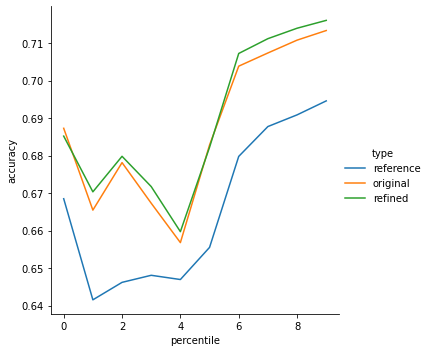

In [90]:
# Original hierarchy, with partial retraining
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_ids={"reference": "1bdceb1e06b34f949447dc4d006ea9fe", "original": "d5b778d8f909447baa8f8c709aedbf07", "refined": "0e6671e12fd5428293c0b9d0d165735f"})
overall_df

Max reference/original per-percentile improvement: 0.031932773109243695 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.031932773109243695 (in percentile 2)
Max original/refinement per-percentile improvement: 0.0014587892049598983 (in percentile 4)
Num connections before 26608.0 / after 37472.0 (diff: 10864.0)
-0.0049 & -0.0013 & 0.0 & 0.001 & 0.0015 & -0.0002 & -0.0017 & 0.0014 & 0.0006 & -0.0007


,type,accuracy
0,reference,0.693804
1,original,0.713185
2,refined,0.712414


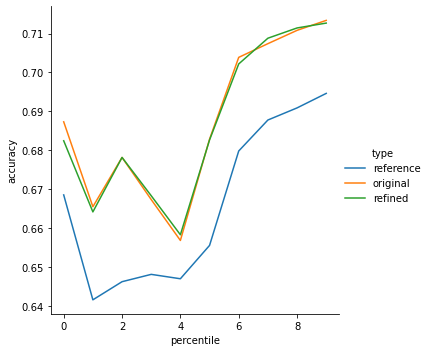

In [103]:
# 50% of added edges, with partial retraining
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_ids={"reference": "1bdceb1e06b34f949447dc4d006ea9fe", "original": "d5b778d8f909447baa8f8c709aedbf07", "refined": "6429244e202a41f18370b28d1a0f6dba"})
overall_df

Max reference/original per-percentile improvement: 0.031932773109243695 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.02268907563025202 (in percentile 2)
Max original/refinement per-percentile improvement: -0.0020244491162501044 (in percentile 7)
Num connections before 26608.0 / after 48337.0 (diff: 21729.0)
-0.0115 & -0.0049 & -0.0092 & -0.0103 & -0.0109 & -0.0113 & -0.0039 & -0.002 & -0.0053 & -0.0061


,type,accuracy
0,reference,0.693804
1,original,0.713185
2,refined,0.706943


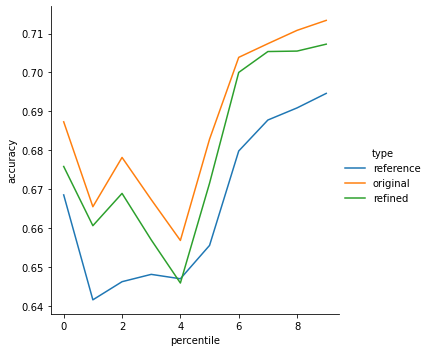

In [104]:
# 100% of added edges, with partial retraining
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_ids={"reference": "1bdceb1e06b34f949447dc4d006ea9fe", "original": "d5b778d8f909447baa8f8c709aedbf07", "refined": "1eb87497f6ca441dbf00a00fcc9b0bb4"})
overall_df

Max reference/original per-percentile improvement: 0.031932773109243695 (in percentile 2)
Max reference/refinement per-percentile improvement: 0.02658396101019056 (in percentile 1)
Max original/refinement per-percentile improvement: 0.004741064916119586 (in percentile 4)
Num connections before 26608.0 / after 26609.0 (diff: 1.0)
-0.0094 & 0.0027 & -0.0109 & -0.0049 & 0.0047 & -0.0138 & -0.0068 & -0.0037 & -0.007 & -0.0074


,type,accuracy
0,reference,0.693804
1,original,0.713185
2,refined,0.705595


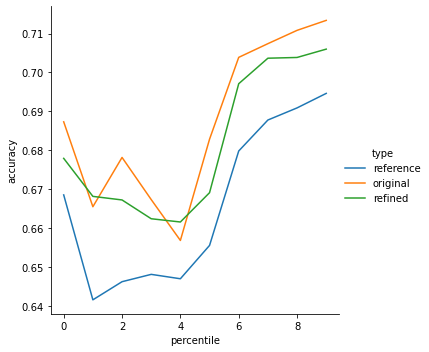

In [105]:
# Replaced 50% of real edges with artificial edges, with partial retraining
overall_df, fig = get_accuracy_difference_from_refinement(accuracy_df_p, from_ids={"reference": "1bdceb1e06b34f949447dc4d006ea9fe", "original": "d5b778d8f909447baa8f8c709aedbf07", "refined": "dd59d943565d436c8fcbfa7b8713820e"})
overall_df

---

## How good is the refinement metric?

In [ ]:
# This section computes the refinement metric with various different parameters to attempt to find a set of parameters that works well
# This takes a long time and the insights from this are limited (particularly because attempting to detect artificial edges is a bad way of measuring the performance)

In [ ]:
reference_run_id = "1bdceb1e06b34f949447dc4d006ea9fe"
#refinement_run_id = "acdfe482e0d34ddd923cbfa2599600ae" # original hierarchy + 2.0 noise
#refinement_run_id = "d5b778d8f909447baa8f8c709aedbf07" # original hierarchy, new order
refinement_run_id = "e8957f497f9e44be980153f6cf97e4ef" # original hierarchy w/ new order + 1.0 noise

data = []

config = RefinementConfig()
config.restrict_outputs_to_ancestors = False
config.max_refinement_metric = 0.0
config.max_train_examples = 100000
config.min_edge_weight = 0.0
config.refinement_metric_maxrank = -1
config.mlflow_dir = "../gsim01/mlruns/1/"
config.corrective_factor = 0.0
config.correction_attention_scale = 0.0

config.aggregated_parents_contribution = 0.0 # Do this as a postprocessing step to save computation time

with open("../data/gram_original_file_knowledge.json", "r") as f:
    loaded_knowledge = json.load(f) 

for metric in ["mean_outlier_score", "median_outlier_score", "accuracy_20", "accuracy_10", "standalone"]:
    config.refinement_metric = metric

    if "outlier_score" in metric:
        compatibility_factors = [0.0, 0.5, 1.0, 2.0, 5.0]
        rank_decay_rates = [0.0, 1.0, 2.0]
    else:
        compatibility_factors = [0.0]
        rank_decay_rates = [0.0]

    for compatibility_factor in compatibility_factors:
        config.compatibility_factor = compatibility_factor

        for rank_decay_rate in rank_decay_rates:
            config.rank_decay_rate = rank_decay_rate
            processor = KnowledgeProcessor(config)

            #df = load_data_for_attention_distribution(reference_run_id, refinement_run_id, config)
            df = load_from_processor(0, processor, reference_run_id, refinement_run_id)
            df["artificial"] = df.apply(lambda x: (x["child"] not in loaded_knowledge) or (x["parent"] not in loaded_knowledge[x["child"]]), axis=1)
            data.append((metric, compatibility_factor, rank_decay_rate, df))

In [ ]:
output = []

for metric, compatibility_factor, rank_decay_rate, raw_df in data:
    if metric == "standalone":
        thresholds = [(0.3, 0.6)]
    elif metric == "accuracy_20":
        thresholds = [(0.1, 0.1)]
    elif metric == "accuracy_10":
        thresholds = [(0.1, 0.1)]
    else:
        thresholds = [(-1, 0), (-3, 0), (0, 3), (1, 3)]

    for threshold_bad, threshold_good in thresholds:
        for parent_contribution in [0.0, 0.1, 0.5,  0.9, 1.0]:
            df = raw_df.copy(deep=True)
            df["blended_metric"] = df.apply(lambda x: (1.0 - parent_contribution) * x["child_metric"] + parent_contribution * x["parent_metric"], axis=1)

            total_artificial_count = len(df[df["artificial"]])
            artificial_bad_count = len(df[df["artificial"] & (df["blended_metric"] < threshold_bad)])
            artificial_good_count = len(df[df["artificial"] & (df["blended_metric"] > threshold_good)])

            percentage_artificial_bad = round(artificial_bad_count / total_artificial_count * 100.0, ndigits=2)
            percentage_artificial_good = round(artificial_good_count / total_artificial_count * 100.0, ndigits=2)

            total_real_count = len(df[~df["artificial"]])
            real_bad_count = len(df[~df["artificial"] & (df["blended_metric"] < threshold_bad)])
            real_good_count = len(df[~df["artificial"] & (df["blended_metric"] > threshold_good)])

            percentage_real_bad = round(real_bad_count / total_real_count * 100.0, ndigits=2)
            percentage_real_good = round(real_good_count / total_real_count * 100.0, ndigits=2)

            total_bad_count = len(df[df["blended_metric"] < threshold_bad])
            total_good_count = len(df[df["blended_metric"] > threshold_good])
            percentage_bad_artificial = round(artificial_bad_count / total_bad_count * 100.0, ndigits=2)
            percentage_bad_real = round(real_bad_count / total_bad_count * 100.0, ndigits=2)

            percentage_good_artificial = round(artificial_good_count / total_good_count * 100.0, ndigits=2)
            percentage_good_real = round(real_good_count / total_good_count * 100.0, ndigits=2)

            output.append(
                (
                    metric,
                    compatibility_factor if "outlier_score" in metric else np.nan,
                    rank_decay_rate if "outlier_score" in metric else np.nan,
                    parent_contribution,
                    threshold_bad,
                    threshold_good,
                    percentage_artificial_bad,
                    percentage_artificial_good,
                    percentage_real_bad,
                    percentage_real_good,
                    percentage_bad_artificial,
                    percentage_bad_real,
                    percentage_good_artificial,
                    percentage_good_real
                )
            )

output_df = pd.DataFrame.from_records(output, columns=["metric", "compatibility_factor", "rank_decay_rate", "parent_contribution", "threshold_bad", "threshold_good", "percentage_artificial_bad", "percentage_artificial_good", "percentage_real_bad", "percentage_real_good", "percentage_bad_artificial", "percentage_bad_real", "percentage_good_artificial", "percentage_good_real"])

In [18]:
output_df = pd.read_csv("metric_comparison.csv")
output_df

,Unnamed: 0,metric,compatibility_factor,rank_decay_rate,parent_contribution,threshold_bad,threshold_good,percentage_artificial_bad,percentage_artificial_good,percentage_real_bad,percentage_real_good,percentage_bad_artificial,percentage_bad_real,percentage_good_artificial,percentage_good_real
0,0,mean_outlier_score,0.0,0.0,0.0,-1.0,0.0,8.85,69.93,9.07,70.01,44.16,55.84,44.72,55.28
1,1,mean_outlier_score,0.0,0.0,0.1,-1.0,0.0,7.94,73.63,8.39,73.10,43.41,56.59,44.93,55.07
2,2,mean_outlier_score,0.0,0.0,0.5,-1.0,0.0,3.69,82.69,3.72,83.65,44.56,55.44,44.46,55.54
3,3,mean_outlier_score,0.0,0.0,0.9,-1.0,0.0,1.12,87.82,1.89,91.06,32.48,67.52,43.86,56.14
4,4,mean_outlier_score,0.0,0.0,1.0,-1.0,0.0,1.21,88.10,1.80,91.47,35.28,64.72,43.82,56.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,610,standalone,NaN,NaN,0.0,0.3,0.6,5.60,28.42,6.20,28.28,42.25,57.75,44.87,55.13
611,611,standalone,NaN,NaN,0.1,0.3,0.6,4.61,26.59,5.43,27.21,40.77,59.23,44.19,55.81
612,612,standalone,NaN,NaN,0.5,0.3,0.6,1.76,16.04,2.58,16.47,35.51,64.49,44.09,55.91
613,613,standalone,NaN,NaN,0.9,0.3,0.6,0.16,9.90,1.22,8.90,9.33,90.67,47.39,52.61


## Which edges does the refinement metric find?

In [49]:
hierarchy, hierarchy_mapping_df = load_hierarchy()

Building Hierarchy from df: 18960it [00:00, 25593.38it/s]


In [50]:
config = RefinementConfig()
config.refinement_metric = "mean_outlier_score"
config.compatibility_factor = 0.0
config.restrict_outputs_to_ancestors = False
config.max_refinement_metric = 0.0
config.max_train_examples = 100000
config.min_edge_weight = 0.0
config.refinement_metric_maxrank = -1
config.mlflow_dir = "../gsim01/mlruns/1/"
config.corrective_factor = 0.0
config.correction_attention_scale = 0.0
config.rank_decay_rate = 0.0
config.aggregated_parents_contribution = 0.0

reference_run_id = "1bdceb1e06b34f949447dc4d006ea9fe"
refinement_run_id = "d5b778d8f909447baa8f8c709aedbf07" # original hierarchy, new order

processor = KnowledgeProcessor(config)
df = load_from_processor(0, processor, reference_run_id, refinement_run_id)
frequency_lookup = processor._load_input_frequency_dict(refinement_run_id)
df["train_frequency"] = df.apply(lambda x: frequency_lookup.get(x["child"], {}).get("absolue_frequency", 0.0), axis=1)
refinement_attention = get_attention_for_run(refinement_run_id)
df["attention"] = df.apply(lambda x: float(refinement_attention[x["child"]][x["parent"]]), axis=1)
df["child_name"] = df["child"].apply(lambda x: hierarchy.nodes[hierarchy.get_extended_vocab()[x]].label_name)
df["parent_name"] = df["parent"].apply(lambda x: hierarchy.nodes[hierarchy.get_extended_vocab()[x]].label_name)

In [51]:
helpful_df = df[(df["refinement_metric"] > 5) & (df["train_frequency"] > 0)]

In [52]:
harmful_df = df[(df["refinement_metric"] < -5) & (df["train_frequency"] > 0)]

## What does the distribution of the refinement metric look like?

In [6]:
hierarchy, hierarchy_mapping_df = load_hierarchy()

Building Hierarchy from df: 18960it [00:00, 25367.71it/s]


In [7]:
config = RefinementConfig()
config.refinement_metric = "mean_outlier_score"
config.compatibility_factor = 0.8
config.restrict_outputs_to_ancestors = False
config.max_refinement_metric = 0.0
config.max_train_examples = 100000
config.min_edge_weight = 0.0
config.refinement_metric_maxrank = -1
config.mlflow_dir = "../gsim01/mlruns/1/"
config.corrective_factor = 0.0
config.correction_attention_scale = 0.0
config.rank_decay_rate = 0.0
config.aggregated_parents_contribution = 0.0

reference_run_id = "1bdceb1e06b34f949447dc4d006ea9fe"
refinement_run_id = "d5b778d8f909447baa8f8c709aedbf07" # original hierarchy, new order

processor = KnowledgeProcessor(config)
df = load_from_processor(0, processor, reference_run_id, refinement_run_id)
frequency_lookup = processor._load_input_frequency_dict(refinement_run_id)
df["train_frequency"] = df.apply(lambda x: frequency_lookup.get(x["child"], {}).get("absolue_frequency", 0.0), axis=1)
refinement_attention = get_attention_for_run(refinement_run_id)
df["attention"] = df.apply(lambda x: float(refinement_attention[x["child"]][x["parent"]]), axis=1)
df["child_name"] = df["child"].apply(lambda x: hierarchy.nodes[hierarchy.get_extended_vocab()[x]].label_name)
df["parent_name"] = df["parent"].apply(lambda x: hierarchy.nodes[hierarchy.get_extended_vocab()[x]].label_name)

In [16]:
df["classification"] = df.apply(lambda x: "harmful" if x["refinement_metric"] < -5 else "helpful" if x["refinement_metric"] > 5 else "unclassified", axis=1) # Threshold -5; +5
#df["classification"] = df.apply(lambda x: "harmful" if x["refinement_metric"] < 0 else "helpful" if x["refinement_metric"] >= 0 else "unclassified", axis=1) # General threshold

In [9]:
df["refinement_metric"].mean() # Mean value of the refinement metric

1.4964401383763315

In [16]:
num_improved_with_domain_knowledge = len(df[df["refinement_metric"] > 0])
num_regressed_with_domain_knowledge = len(df[df["refinement_metric"] < 0])

num_total = len(df)

print("Percentage of knowledge that improved: {}%".format(round(num_improved_with_domain_knowledge / num_total * 100.0, ndigits=2)))
print("Percentage of knowledge that worsened: {}%".format(round(num_regressed_with_domain_knowledge / num_total * 100.0, ndigits=2)))

Percentage of knowledge that improved: 71.5%
Percentage of knowledge that worsened: 27.65%


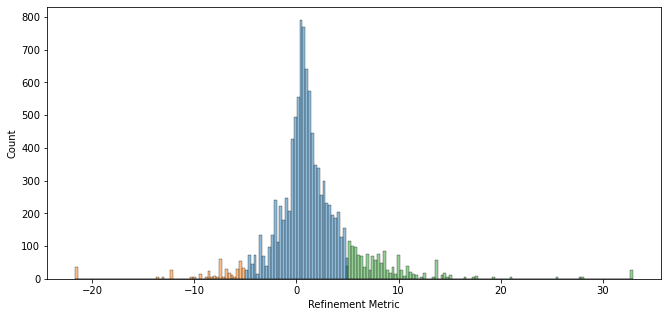

In [19]:
plt.figure(figsize=(11,5))

ax = sns.histplot(
    data=df,
    x="refinement_metric",
    hue="classification",
    palette= ["tab:blue", "tab:green", "tab:orange"]
)

ax.get_legend().remove()
ax.set(xlabel="Refinement Metric")
fig = plt.gcf()

In [20]:
fig.savefig("refinement_metric_distribution.png", format="png", facecolor="white", dpi=300)

In [110]:
num_total = len(df)
num_harmful = len(df[df["classification"] == "harmful"])
num_helpful = len(df[df["classification"] == "helpful"])

percentage_harmful = round(num_harmful / num_total * 100.0, ndigits=2)
percentage_helpful = round(num_helpful / num_total * 100.0, ndigits=2)

print("Percentage harmful: {}".format(percentage_harmful))
print("Percentage helpful: {}".format(percentage_helpful))

Percentage harmful: 3.57
Percentage helpful: 13.18


## Can we manually fix incompleteness?

In [ ]:
# This section analyses the attempt at manually fixing the example with the motorcyclist

In [6]:
relevant_inputs = [ # Categories involving traffic accidents with motorcyclists
    "level_0#E810.2",
    "level_0#E810.3",
    "level_0#E811.2",
    "level_0#E811.3",
    "level_0#E812.2",
    "level_0#E812.3",
    "level_0#E813.2",
    "level_0#E813.3",
    "level_0#E814.2",
    "level_0#E814.3",
    "level_0#E815.2",
    "level_0#E815.3",
    "level_0#E816.2", # Use this as the general representation - This is the original category of "Motor Vehicle Traffic Accident without collection due to loss of control on the highway injuring a motorcyclist"
    "level_0#E816.3",
    "level_0#E817.2",
    "level_0#E817.3",
    "level_0#E818.2",
    "level_0#E818.3",
    "level_0#E819.2",
    "level_0#E819.3",
    "level_0#E820.2",
    "level_0#E820.3",
    "level_0#E821.2",
    "level_0#E821.3",
    "level_0#E822.2",
    "level_0#E822.3",
    "level_0#E823.2",
    "level_0#E823.3",
    "level_0#E824.2",
    "level_0#E824.3",
    "level_0#E825.2",
    "level_0#E825.3",
]

with open("../data/gram_original_file_knowledge.json", "r") as f:
    original_knowledge = json.load(f)

In [44]:
import copy

modified_knowledge = copy.deepcopy(original_knowledge)

for child in relevant_inputs:
    if child != "level_0#816.2":
        modified_knowledge[child] = list(set(modified_knowledge.get(child, []) + ["level_0#816.2"]))

In [17]:
with open("../data/gram_motorcyclist_fix.json", "w") as f:
    json.dump(modified_knowledge, f) # This is the adjusted domain knowledge that must be used for the model

In [8]:
# This remained of this section analyses the results of our modification

def _get_rank(predictions: Dict[str, float], output: str):
    return len([x for x in predictions if predictions[x] > predictions[output]])

def calculate_per_sequence_accuracy(df: pd.DataFrame, k: int = 20):
    df = df.copy(deep=True)
    df["input_converted"] = df["input"].apply(lambda x: ast.literal_eval(x)[0]).map(tuple)
    df["output_converted"] = df["output"].apply(lambda x: ast.literal_eval(x))
    df["predictions"] = df["predictions"].apply(lambda x: ast.literal_eval(x))

    df = df.explode("output_converted")
    df["output_rank"] = df.apply(lambda x: _get_rank(x["predictions"], x["output_converted"]), axis=1)
    
    df =  df.groupby("input_converted")["output_rank"].agg(lambda x: (x < k).sum() / len(x)).reset_index()

    return df.rename(columns={"input_converted": "sequence", "output_rank": "accuracy"})

def _is_affected(affected_children, inputs):
    return len(affected_children.intersection(inputs)) > 0

def calculate_per_sequence_accuracy_difference(original_run_id: str, refinement_run_id: str):
    original_prediction_df = pd.read_csv("../gsim01/mlruns/1/{}/artifacts/prediction_output.csv".format(original_run_id))
    refinement_prediction_df = pd.read_csv("../gsim01/mlruns/1/{}/artifacts/prediction_output.csv".format(refinement_run_id))
    
    original_accuracy_df = calculate_per_sequence_accuracy(original_prediction_df)
    refinement_accuracy_df = calculate_per_sequence_accuracy(refinement_prediction_df)

    df = pd.merge(original_accuracy_df, refinement_accuracy_df, on="sequence", suffixes=["_original", "_modified"])
    df["affected"] = df["sequence"].apply(lambda x: _is_affected(set(relevant_inputs), set(x)))

    df["accuracy_diff"] = df.apply(lambda x: x["accuracy_modified"] - x["accuracy_original"], axis=1)

    return df

df = calculate_per_sequence_accuracy_difference("d5b778d8f909447baa8f8c709aedbf07", "a7cdd8e0b4914951a953d034a4eac06c")

In [32]:
overall_accuracies_df = mlflow_helper.load_best_metrics_for_ids(run_ids=set(["d5b778d8f909447baa8f8c709aedbf07", "a7cdd8e0b4914951a953d034a4eac06c"]))

Querying metrics for runs: 100%|██████████| 2/2 [00:14<00:00,  7.13s/it]


In [34]:
overall_accuracies_df[["info_run_id", "val_top_20_categorical_accuracy_history_best"]]

,info_run_id,val_top_20_categorical_accuracy_history_best
0,d5b778d8f909447baa8f8c709aedbf07,0.713185
1,a7cdd8e0b4914951a953d034a4eac06c,0.713069


In [9]:
df["accuracy_diff"].mean()

-0.0022263237813292826

In [10]:
df[df["affected"]]["accuracy_diff"].mean()

0.04545454545454544

In [11]:
df[~df["affected"]]["accuracy_diff"].mean()

-0.0022902820230943726

In [52]:
df[df["affected"]]

,sequence,accuracy_original,accuracy_modified,affected,accuracy_diff
1163,"(level_0#276.2, level_0#285.1, level_0#511.9, ...",0.000000,0.000000,True,0.000000
1307,"(level_0#305.00, level_0#305.1, level_0#401.9,...",0.454545,0.545455,True,0.090909


In [50]:
for _,row in df[df["affected"]].iterrows():
    print([hierarchy.nodes[hierarchy.get_extended_vocab()[x]].label_name for x in row["sequence"]])

['Acidosis', 'Acute posthemorrhagic anemia', 'Unspecified pleural effusion', 'Closed fracture of lumbar vertebra without mention of spinal cord injury', 'Closed fracture of sacrum and coccyx without mention of spinal cord injury', 'Closed fracture of sternal end of clavicle', 'Closed fracture of shaft of femur', 'Closed dislocation, lumbar vertebra', 'Contusion of lung without mention of open wound into thorax', 'Injury to kidney without mention of open wound into cavity, laceration', 'Injury to other intra-abdominal organs with open wound into cavity, peritoneum', 'Motor vehicle traffic accident due to loss of control, without collision on the highway, injuring motorcyclist']
['Alcohol abuse, unspecified', 'Tobacco use disorder', 'Unspecified essential hypertension', 'Esophageal reflux', 'Chronic pancreatitis', 'Acute osteomyelitis, lower leg', 'Major osseous defects', 'Closed fracture of three ribs', 'Fracture of medial malleolus, open', 'Closed fracture of cuneiform, foot', 'Closed 

# Disable categories

In [8]:
hierarchy, hierarchy_mapping_df = load_hierarchy()

Building Hierarchy from df: 18960it [00:00, 25539.71it/s]


In [9]:
import json

def calculate_children_to_adjust(hierarchy, parent: str):
    children_to_adjust = []

    for _, node in hierarchy.nodes.items():
        if "level_0#{}".format(parent) in [x.label_str for x in node.get_ancestors()]:
            children_to_adjust = children_to_adjust + [node.label_str]

    return children_to_adjust

def calculate_adjustment_set(hierarchy, parent: str, knowledge_path: str = "../data/gram_original_file_knowledge.json"):
    children_to_adjust = calculate_children_to_adjust(hierarchy, parent)

    with open(knowledge_path) as f:
        knowledge = json.load(f)

    connections_to_adjust = []

    for child, parents in knowledge.items():
        for parent in parents:
            if parent in children_to_adjust:
                connections_to_adjust = connections_to_adjust + [(child, parent)]

    return connections_to_adjust

In [10]:
def generate_adjusted_knowledge(node: str):
    connections_to_adjust = calculate_adjustment_set(hierarchy, node)

    with open("../data/gram_original_file_knowledge.json") as f:
        original_knowledge = json.load(f)

    adjusted_knowledge: Dict[str, List[str]] = {}

    for child, parents in original_knowledge.items():
        for parent in parents:
            if not (child, parent) in connections_to_adjust:
                adjusted_knowledge[child] = adjusted_knowledge.get(child, []) + [parent]

    with open("../data/disable/adjusted_knowledge_{}.json".format(node), "w") as f:
        json.dump(adjusted_knowledge, f) # This is the knowledge that must be provided to the model

In [40]:
generate_adjusted_knowledge("390-459")
generate_adjusted_knowledge("512")
generate_adjusted_knowledge("801.0")
generate_adjusted_knowledge("925-929")

# This will generate the files in the data directory - These need to be moved to the server and then provided as a parameter to the model

In [11]:
# The remained of this section analyses the result the approach of disabling parts

partially_disabled = [
    ("d5b778d8f909447baa8f8c709aedbf07", "original"), # new order, no noise
    ("ae60e0184ca64cd58c4d1aba3e8387df", "925-929"),
    ("a27f03d2ed5e4dd1b329c48c1144ecc6", "801.0"),
    ("3e4a9a871a704d1090434e9a84728688", "512"),
    ("1e6c19a8d17142db9f81f16b4f13381f", "390-459")
]

In [12]:
def _get_rank(predictions: Dict[str, float], output: str):
    return len([x for x in predictions if predictions[x] > predictions[output]])

def calculate_per_sequence_accuracy(df: pd.DataFrame, k: int = 20):
    df = df.copy(deep=True)
    df["input_converted"] = df["input"].apply(lambda x: ast.literal_eval(x)[0]).map(tuple)
    df["output_converted"] = df["output"].apply(lambda x: ast.literal_eval(x))
    df["predictions"] = df["predictions"].apply(lambda x: ast.literal_eval(x))

    df = df.explode("output_converted")
    df["output_rank"] = df.apply(lambda x: _get_rank(x["predictions"], x["output_converted"]), axis=1)
    
    df =  df.groupby("input_converted")["output_rank"].agg(lambda x: (x < k).sum() / len(x)).reset_index()

    return df.rename(columns={"input_converted": "sequence", "output_rank": "accuracy"})

def _is_affected(affected_children, inputs):
    return len(affected_children.intersection(inputs)) > 0

def calculate_accuracy_comparison(lookup, k: int = 20):
    comparison_df = None

    for (run, t) in lookup:
        df = pd.read_csv("../gsim01/mlruns/1/{}/artifacts/prediction_output.csv".format(run))

        per_sequence_accuracy_df = calculate_per_sequence_accuracy(df, k)

        affected_children = set(calculate_children_to_adjust(hierarchy, t))
        per_sequence_accuracy_df["affected"] = per_sequence_accuracy_df["sequence"].apply(lambda x: _is_affected(affected_children, set(x)))
        per_sequence_accuracy_df = per_sequence_accuracy_df.add_suffix("_{}".format(t))
        per_sequence_accuracy_df = per_sequence_accuracy_df.rename(columns={"sequence_{}".format(t): "sequence"})

        if comparison_df is None:
            comparison_df = per_sequence_accuracy_df
        else:
            comparison_df = comparison_df.merge(per_sequence_accuracy_df, on="sequence")

    handled = []

    for (_, t1) in lookup:
        for (_, t2) in lookup:
            if t1 == t2 or set([t1, t2]) in handled:
                continue

            comparison_df["accuracy_diff_{}_{}".format(t1, t2)] = comparison_df.apply(lambda x: x["accuracy_{}".format(t2)] - x["accuracy_{}".format(t1)], axis=1)
            handled.append(set([t1, t2]))

    return comparison_df

df = calculate_accuracy_comparison(partially_disabled, k=5)

In [18]:
def gather_stats_for_disabled(node: str):
    affected = df["affected_{}".format(node)]

    num_total = len(df)
    num_affected = len(df[affected])

    num_affected_regressed = len(df[affected & (df["accuracy_diff_original_{}".format(node)] < 0)])
    num_affected_improved = len(df[affected & (df["accuracy_diff_original_{}".format(node)] > 0)])

    percentage_affected_regressed = round(num_affected_regressed / num_affected * 100.0, ndigits=2)
    percentage_affected_improved = round(num_affected_improved / num_affected * 100.0, ndigits=2)

    num_regressed = len(df[df["accuracy_diff_original_{}".format(node)] < 0])
    num_improved = len(df[df["accuracy_diff_original_{}".format(node)] > 0])

    percentage_regressed = round(num_regressed / num_total * 100.0, ndigits=2)
    percentage_improved = round(num_improved / num_total * 100.0, ndigits=2)

    percentage_regressed_affected = round(num_affected_regressed / num_regressed * 100.0, ndigits=2)
    percentage_improved_affected = round(num_affected_improved / num_improved * 100.0, ndigits=2)

    avg_accuracy_among_affected = df[affected]["accuracy_{}".format(node)].mean()
    avg_accuracy_diff_among_affected = df[affected]["accuracy_diff_original_{}".format(node)].mean()

    avg_accuracy_among_unaffected = df[~affected]["accuracy_{}".format(node)].mean()
    avg_accuracy_diff_among_unaffected = df[~affected]["accuracy_diff_original_{}".format(node)].mean()

    stats = {}

    stats["node"] = node
    stats["num_total"] = num_total
    stats["num_affected"] = num_affected

    stats["percentage_regressed"] = percentage_regressed
    stats["percentage_improved"] = percentage_improved

    stats["percentage_regressed_affected"] = percentage_regressed_affected
    stats["percentage_affected_regressed"] = percentage_affected_regressed

    stats["percentage_improved_affected"] = percentage_improved_affected
    stats["percentage_affected_improved"] = percentage_affected_improved

    stats["avg_accuracy_among_affected"] = avg_accuracy_among_affected
    stats["avg_accuracy_diff_among_affected"] = avg_accuracy_diff_among_affected

    stats["avg_accuracy_among_unaffected"] = avg_accuracy_among_unaffected
    stats["avg_accuracy_diff_among_unaffected"] = avg_accuracy_diff_among_unaffected

    return pd.DataFrame(stats, index=[0])

def gather_stats_for_all_disabled():
    results = pd.DataFrame()

    overall_accuracies = mlflow_helper.load_best_metrics_for_ids(run_ids=set(map(lambda x: x[0], partially_disabled)))

    overall_accuracy_original = np.nan

    for run, node in partially_disabled:
        if node == "original":
            overall_accuracy_original = overall_accuracies[overall_accuracies["info_run_id"] == run]["val_top_20_categorical_accuracy_history_best"].min()
            continue

        overall_accuracy = overall_accuracies[overall_accuracies["info_run_id"] == run]["val_top_20_categorical_accuracy_history_best"].min()
        overall_accuray_diff = overall_accuracy - overall_accuracy_original

        stats = gather_stats_for_disabled(node)
        stats["overall_accuracy_diff"] = overall_accuray_diff
        results = results.append(stats)

    return results.reset_index(drop=True)


In [20]:
gather_stats_for_all_disabled()

Querying metrics for runs: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


,node,num_total,num_affected,percentage_regressed,percentage_improved,percentage_regressed_affected,percentage_affected_regressed,percentage_improved_affected,percentage_affected_improved,avg_accuracy_among_affected,avg_accuracy_diff_among_affected,avg_accuracy_among_unaffected,avg_accuracy_diff_among_unaffected,overall_accuracy_diff
0,925-929,1493,2,14.53,13.66,0.00,0.00,0.49,50.00,0.083333,0.083333,0.360630,-0.000102,0.000385
1,801.0,1493,2,12.32,11.52,0.00,0.00,0.00,0.00,0.291667,0.000000,0.359660,-0.000681,0.000193
2,512,1493,30,16.61,17.82,3.63,30.00,2.63,23.33,0.262030,-0.009738,0.364409,0.002346,0.001926
3,390-459,1493,1252,19.02,16.28,85.56,19.41,77.37,15.02,0.346012,-0.007610,0.402824,0.008150,0.000655


# Input-level analysis

In [70]:
# This loads a lot of data into a convenient representation for comparison - Use this if your needs are not met by any of the more specific analysis earlier

# level_3 reference: 1bdceb1e06b34f949447dc4d006ea9fe
# level_3 original [hierarchy]: fa6729fc421c49a4a16cbdea6b85f7e6 / d5b778d8f909447baa8f8c709aedbf07 (new format)
# level_3 original [causal]: b04cffcc8f0c4ac1aa78e84162e9f0fd

# level_2 reference: 380e84381f2e49d59de800b7108de62c
# level_2 original: c94f54e927b944acb629c3c7201668c1

# level_3 original [hierarchy + noise 0.1]: 9ec9acaf74aa46abbd3dadfc1d9d0ad0
# level_3 original [hierarchy + noise 2.0]: acdfe482e0d34ddd923cbfa2599600ae
# level_3 original [hierarchy - 0.5 edges]: f58f2dfeed6943e185c452cefacf55aa
# level_3 original [hierarchy - 0.9 edges]: 048d3cb0bd6e44178617e7f47334b736
# level_3 original [hierarchy + noise 1.0]: cdfb86e603904826855bfc212bd9a872

# level_3 original [hierarchy + noise 0.5]: 1a4e0ddc634342fab22095d67887ee88
# level_3 original [hierarchy + noise 1.0]: 0e3df611a8a64117a5740d81d929c557
# level_3 original [hierarchy - 0.5 real + 1.0 artificial (to get 50:50 split)]: 571864b4c21148689cc6bb3ba9c57033

groups: Dict[int, GroupComparison] = {}

groups[0] = load_group_comparisons(runs_df, "1652869512.055812") # w/o correction
groups[1] = load_group_comparisons(runs_df, "1652872333.5654702") # w/ correction 1.0
groups[2] = load_group_comparisons(runs_df, "1652873019.0456536") # w/ correction 1.0; attention scaling 1.0
groups[3] = load_group_comparisons(runs_df, "1652873700.4902394") # w/ correction 1.0; rank decay 2.0
groups[4] = load_group_comparisons(runs_df, "1652874447.2043114") # w/ correction 1.0; aggregate to parents
groups[5] = load_group_comparisons(runs_df, "1652875120.5577857") # w/ correction 1.0; restrict to ancestors
groups[6] = load_group_comparisons(runs_df, "1652876047.8260615") # w/ correction 1.0; attention scaling 1.0; rank decay 2.0
groups[7] = load_group_comparisons(runs_df, "1652885192.9896235") # w/ correction 1.0; attention scaling 1.0; rank decay 2.0; aggregate to parents
groups[8] = load_group_comparisons(runs_df, "1652886748.014133") # w/ correction 5.0; attention scaling 1.0; rank decay 2.0
groups[9] = load_group_comparisons(runs_df, "1652888356.5794437") # w/ correction 15.0; attention scaling 1.0; rank decay 2.0
groups[10] = load_group_comparisons(runs_df, "1652949272.441043") # w/ hard correction; rank decay 2.0
groups[11] = load_group_comparisons(runs_df, "1653048902.6951077") # w/ correction 1.0; attention scaling 1.0; rank decay 2.0; all training enabled
groups[12] = load_group_comparisons(runs_df, "1653052103.4722846") # w/ correction 1.0; attention scaling 1.0; rank decay 2.0; restore best
groups[13] = load_group_comparisons(runs_df, "1653056237.5278604") # w/ correction 3.0; attention scaling 1.0; rank decay 2.0; restore best
groups[14] = load_group_comparisons(runs_df, "1653066850.783773") # w/ correction 15.0; attention scaling 1.0; rank decay 2.0; restore best
groups[15] = load_group_comparisons(runs_df, "1653070774.0548842") # w/ correction [1.0, 5.0, 15.0]; attention scaling 1.0; rank decay 2.0; restore best
groups[16] = load_group_comparisons(runs_df, "1653483287.2439053") # retrain from scratch; w/ correction 1.0; attention scaling 1.0; rank decay 2.0
groups[17] = load_group_comparisons(runs_df, "1653486285.1169667") # retrain from scratch; w/ correction 15.0; attention scaling 1.0; rank decay 2.0
groups[18] = load_group_comparisons(runs_df, "1653492531.1614919") # w/ correction 1.0; attention scaling 1.0; rank decay 2.0; min edge weight 0.3
groups[19] = load_group_comparisons(runs_df, "1653570430.5627925") # w/ correction 5.0; attention scaling 1.0; rank decay 2.0; predict on level_2; aggregate to parents
groups[20] = load_group_comparisons(runs_df, "1653665780.2372444") # w/ correction 1.0; attention scaling 1.0; rank decay 2.0; restore best; predict on level_2; aggregate to parents
groups[21] = load_group_comparisons(runs_df, "1653752489.1939573") # w/ correction 1.0; attention scaling 1.0; rank decay 2.0; restore best; predict on level_2
groups[22] = load_group_comparisons(runs_df, "1653754470.6666594") # w/ correction 0.2; attention scaling 1.0; rank decay 2.0; restore best; predict on level_2; aggregate to parents
groups[23] = load_group_comparisons(runs_df, "1653827263.2960086") # w/ correction 0.2; attention scaling 1.0; rank decay 10.0; restore best; predict on level_2; aggregate to parents; interpolate 0.3:0.7 (server only)

groups[24] = load_group_comparisons(runs_df, "1653910048.4850316") # w/o correction
groups[25] = load_group_comparisons(runs_df, "1653917680.7257695") # w/ correction 1.0; attention scaling 1.0; rank decay 2.0; restore best; causal knowledge

groups[26] = load_group_comparisons(runs_df, "1653927590.8001614") # w/ correction 1.0; noise 0.1
groups[27] = load_group_comparisons(runs_df, "1653929746.5559652") # w/ correction 1.0; attention scaling 1.0; rank decay 2.0; restore best; noise 2.0
groups[28] = load_group_comparisons(runs_df, "1653931704.8715634") # w/ correction 5.0; attention scaling 1.0; rank decay 2.0; restore best; noise 2.0
groups[29] = load_group_comparisons(runs_df, "1653994671.5526137") # w/ correction 15.0; attention scaling 1.0; rank decay 2.0; restore best; noise 2.0
groups[30] = load_group_comparisons(runs_df, "1653996989.8855057") # w/ correction [5.0, 15.0, 1.0]; attention scaling 1.0; rank decay 2.0; restore best; noise 2.0
groups[31] = load_group_comparisons(runs_df, "1654001494.2209659") # w/ correction 1.0; attention scaling 1.0; rank decay 2.0; restore best; min edge weight 0.01; noise 2.0
groups[32] = load_group_comparisons(runs_df, "1654003880.6584191") # w/ correction 1.0; attention scaling 1.0; rank decay 2.0; all training enabled; noise 2.0
groups[33] = load_group_comparisons(runs_df, "1654006611.3955224") # w/ correction [3.0, 5.0, 15.0]; attention scaling 1.0; rank decay 2.0; restore best [threshold 0.2]; noise 2.0
groups[34] = load_group_comparisons(runs_df, "1654009953.0895884") # w/ correction [5.0, 15.0, 3.0]; attention scaling 1.0; restore best; aggregate to parents; noise 2.0
groups[35] = load_group_comparisons(runs_df, "1654077487.0725288") # w/ correction [1.0, 3.0, 5.0, 15.0]; attention scaling 1.0; restore best; aggregate to parents; noise 2.0
groups[36] = load_group_comparisons(runs_df, "1654081810.6218786") # w/ correction [5.0, 3.0, 15.0]; attention scaling 1.0; rank decay 2.0; restore best; parent contribution 0.7; noise 2.0

groups[37] = load_group_comparisons(runs_df, "1654088333.0139182") # cheating run - set artificial to 0.0; restore best; noise 2.0
groups[38] = load_group_comparisons(runs_df, "1654169987.6818225") # cheating run - set artificial to 0.0; all training enabled & retrain from scratch; noise 2.0

groups[39] = load_group_comparisons(runs_df, "1654171896.864914") # w/ correction 1.0; attention scaling 1.0; restore best; parent contribution 0.3; all training enabled; noise 2.0
groups[40] = load_group_comparisons(runs_df, "1654183626.0025313") # w/ correction 5.0; attention scaling 1.0; parent contribution 0.3; all training enabled; noise 2.0
groups[41] = load_group_comparisons(runs_df, "1654593308.2115917") # w/ correction 0.3; attention scaling 1.0; parent contribution 0.3; all training enabled; noise 2.0
groups[42] = load_group_comparisons(runs_df, "1654595390.0245547") # w/o correction; parent contribution 0.3; all training enabled; noise 2.0

groups[43] = load_group_comparisons(runs_df, "1654685421.5685909") # w/ hard correction; all training enabled; noise 2.0
groups[44] = load_group_comparisons(runs_df, "1654687282.1335068") # w/ hard correction; rank decay 4.0; max metric -0.3; all training enabled & retrain from scratch; noise 2.0

groups[45] = load_group_comparisons(runs_df, "1654707358.5532982") # cheating run - set 10% of artifical edges to 0.0; all training enabled; noise 2.0
groups[46] = load_group_comparisons(runs_df, "1654689276.2855608") # cheating run - set 50% of artificial edges to 0.0; all training enabled; noise 2.0
groups[47] = load_group_comparisons(runs_df, "1654691052.3620088") # cheating run - set 75% of artificial edges to 0.0; all training enabled; noise 2.0
groups[48] = load_group_comparisons(runs_df, "1654695305.5501912") # cheating run - set 85% of artificial edges to 0.0; all training enabled; noise 2.0
groups[49] = load_group_comparisons(runs_df, "1654695913.6356702") # cheating run - set 95% of artificial edges to 0.0; all training enabled; noise 2.0
groups[50] = load_group_comparisons(runs_df, "1654696467.263691") # cheating run - set 99% of artificial edges to 0.0; all training enabled; noise 2.0
groups[51] = load_group_comparisons(runs_df, "1654697188.3514109") # cheating run - set 100% of artificial edges to 0.0; all training enabled; noise 2.0

groups[52] = load_group_comparisons(runs_df, "1654758151.5191183") # cheating run - set 0% of artificial edges to 0.0; all training enabled & retrain from scratch; noise 2.0
groups[53] = load_group_comparisons(runs_df, "1654759089.619618") # cheating run - set 10% of artificial edges to 0.0; all training enabled & retrain from scratch; noise 2.0
groups[54] = load_group_comparisons(runs_df, "1654760003.3670237") # cheating run - set 50% of artificial edges to 0.0; all training enabled & retrain from scratch; noise 2.0
groups[55] = load_group_comparisons(runs_df, "1654760850.983392") # cheating run - set 75% of artificial edges to 0.0; all training enabled & retrain from scratch; noise 2.0
groups[56] = load_group_comparisons(runs_df, "1654761684.8659108") # cheating run - set 85% of artificial edges to 0.0; all training enabled & retrain from scratch; noise 2.0
groups[57] = load_group_comparisons(runs_df, "1654762539.622231") # cheating run - set 95% of artificial edges to 0.0; all training enabled & retrain from scratch; noise 2.0
groups[58] = load_group_comparisons(runs_df, "1654763341.1154218") # cheating run - set 99% of artificial edges to 0.0; all training enabled & retrain from scratch; noise 2.0

groups[59] = load_group_comparisons(runs_df, "1654765261.756572") # w/ hard correction; rank decay 2.0; all training enabled & retrain from scratch; noise 2.0

groups[60] = load_group_comparisons(runs_df, "1655836194.0359018") # w/ correction 1.0; attention scaling 1.0; compatibility factor 0.2; all training enabled & retrain from scratch; noise 2.0
groups[61] = load_group_comparisons(runs_df, "1655838264.409207") # w/ correction 0.2; attention scaling 1.0; rank decay 2.0; compatibility factor 0.1; restore best (threshold 0.2); all training enabled & retrain from scratch; noise 2.0
groups[62] = load_group_comparisons(runs_df, "1655901930.3358438") # w/ correction 0.2; attention scaling 1.0; compatibility factor 0.8; all training enabled & retrain from scratch; noise 2.0
groups[63] = load_group_comparisons(runs_df, "1655910677.2178597") # w/ correction [5.0, 15.0, 3.0]; attention scaling 1.0; rank decay 2.0; max metric -0.3; parent contribution 0.3; compatibility factor 0.8; all training enabled & retrain from scratch; noise 2.0

groups[64] = load_group_comparisons(runs_df, "1655992845.5824418") # generation (compare to reference); min weight 0.0 (broken); max metric 1.0; edges to add 0.5
groups[65] = load_group_comparisons(runs_df, "1656000396.437973") # generation (compare to reference); min weight 0.3 (broken); max metric 4.0; edges to add 0.5
groups[66] = load_group_comparisons(runs_df, "1656055825.7997282") # generation (compare to reference); min weight 0.5; max metric 5.0; edges to add 0.5

groups[67] = load_group_comparisons(runs_df, "1656065822.7189014", generation=True) # generation; min weight 0.5; max metric 5.0; edges to add 0.5
# broken runs omitted
groups[70] = load_group_comparisons(runs_df, "1656436467.0281038", generation=True) # generation; min weight 0.5; max metric 5.0; edges to add 0.5; refinement window 1
groups[71] = load_group_comparisons(runs_df, "1656596520.2398841", generation=True) # generation; min weight 0.5; max metric 5.0; edges to add [0.5, 0.3, 0.1]; refinement window 0
groups[72] = load_group_comparisons(runs_df, "1656602824.3095694", generation=True) # generation; min weight 0.5; max metric 5.0; edges to add [0.75, 0.5, 0.75]; refinement window 1

groups[90] = load_group_comparisons(runs_df, "1659010280.5234222")

# Random seeds + aggregated correction

In [5]:
# This section is about repeating the training multiple times and then computing the refinement metric from multiple runs

# --sequenceconfig_random_state 34996006 \ --modelconfig_dropout_seed 21221919 \ --experimentconfig_dataset_shuffle_seed 9426300 \ --experimentconfig_random_seed 34180513 \--experimentconfig_tensorflow_seed 22917016
# reference c5f72b9f4cb24f92a1218de69925ed53
# original 2b01a523424349229770c1075d45b1c7
# corrected bc7f9f34457e4594b2956806f9333dd6
# corrected [hard] a5853b5e33214b1e9c6ad82619e7d558

# --sequenceconfig_random_state 16837608 \ --modelconfig_dropout_seed 73399650 \ --experimentconfig_dataset_shuffle_seed 61411096 \ --experimentconfig_random_seed 172932 \ --experimentconfig_tensorflow_seed 62000503
# reference 44dd945da4634f8ebeaf704dcace76eb
# original 2dcd27e4f3a54a14ab48053058876575
# corrected e0879c02080f4f8c917a43c59b462325
# corrected [hard] 133f7ff50e614db9bfc71840bb2bc055

# --sequenceconfig_random_state 28669099 \ --modelconfig_dropout_seed 68365263 \ --experimentconfig_dataset_shuffle_seed 71948313 \ --experimentconfig_random_seed 80568592 \ --experimentconfig_tensorflow_seed 55014718
# reference eb167afa522e4c03bd6cecd98ce65359
# original e2f61bdeb86444d4bd7c78f9e40e5abf
# corrected 3daacb52518f444ea535967d7915e3f7
# corrected [hard] 77dffc9dbb80444abdceadfd40a53391


# --sequenceconfig_random_state 30193631 \ --modelconfig_dropout_seed 95784062 \ --experimentconfig_dataset_shuffle_seed 11688858 \ --experimentconfig_random_seed 17596469 \ --experimentconfig_tensorflow_seed 40137739
# non-random 932a79e99a7642f8960d89ff0c5432cb
# w/o correction 9ee17bad2ac14c66b6e47deab9479a43
# w/ correction 5f9daa8bc7414c528dc7af69adaa72f3

# --sequenceconfig_random_state 91969998 \ --modelconfig_dropout_seed 43703237 \ --experimentconfig_dataset_shuffle_seed 36451670 \ --experimentconfig_random_seed 72912577 \ --experimentconfig_tensorflow_seed 56455575
# w/o correction 9549395cedd048a6b3669d55013d95f5
# w/ correction d5807e3c2c1b4888936d0154c055c27b

# --sequenceconfig_random_state 47414161 \ --modelconfig_dropout_seed 69276719 \ --experimentconfig_dataset_shuffle_seed 59066682 \ --experimentconfig_random_seed 41389955 \ --experimentconfig_tensorflow_seed 60882220
# w/o correction 9728cf3da3464de7b100d103a6af4c5c
# w/ correction 9cd1744544d34085aabc65025597f836

references = [("random", "c5f72b9f4cb24f92a1218de69925ed53", "2b01a523424349229770c1075d45b1c7"), ("random", "44dd945da4634f8ebeaf704dcace76eb", "2dcd27e4f3a54a14ab48053058876575"), ("random", "eb167afa522e4c03bd6cecd98ce65359", "e2f61bdeb86444d4bd7c78f9e40e5abf")]

runs = [("corrected", "bc7f9f34457e4594b2956806f9333dd6"), ("corrected[hard]", "a5853b5e33214b1e9c6ad82619e7d558"), ("corrected", "e0879c02080f4f8c917a43c59b462325"), ("corrected[hard]", "133f7ff50e614db9bfc71840bb2bc055"), ("corrected", "3daacb52518f444ea535967d7915e3f7"), ("corrected[hard]", "77dffc9dbb80444abdceadfd40a53391"), ("other_uncorrected", "9ee17bad2ac14c66b6e47deab9479a43"), ("other_corrected", "5f9daa8bc7414c528dc7af69adaa72f3"), ("other_uncorrected", "9549395cedd048a6b3669d55013d95f5"), ("other_corrected", "d5807e3c2c1b4888936d0154c055c27b"), ("other_uncorrected", "9728cf3da3464de7b100d103a6af4c5c"), ("other_corrected", "9cd1744544d34085aabc65025597f836")]

flattened_runs = []

for _, reference, original in references:
    flattened_runs = flattened_runs + [reference, original]

for _, run in runs:
    flattened_runs = flattened_runs + [run]

accuracy_random_df = mlflow_helper.load_best_metrics_for_ids(run_ids=flattened_runs)

Querying metrics for runs: 100%|██████████| 18/18 [01:21<00:00,  4.52s/it]


In [6]:
def _map(x):
    for (t, r, o) in references:
        if r == x:
            return "{}_{}".format(t, "reference")
        elif o == x:
            return "{}_{}".format(t, "original")

    for (t, r) in runs:
        if r == x:
            return t

    return ""

accuracy_random_df["refinement_type"] = accuracy_random_df["info_run_id"].apply(lambda x: _map(x))


(0.29, 0.32)

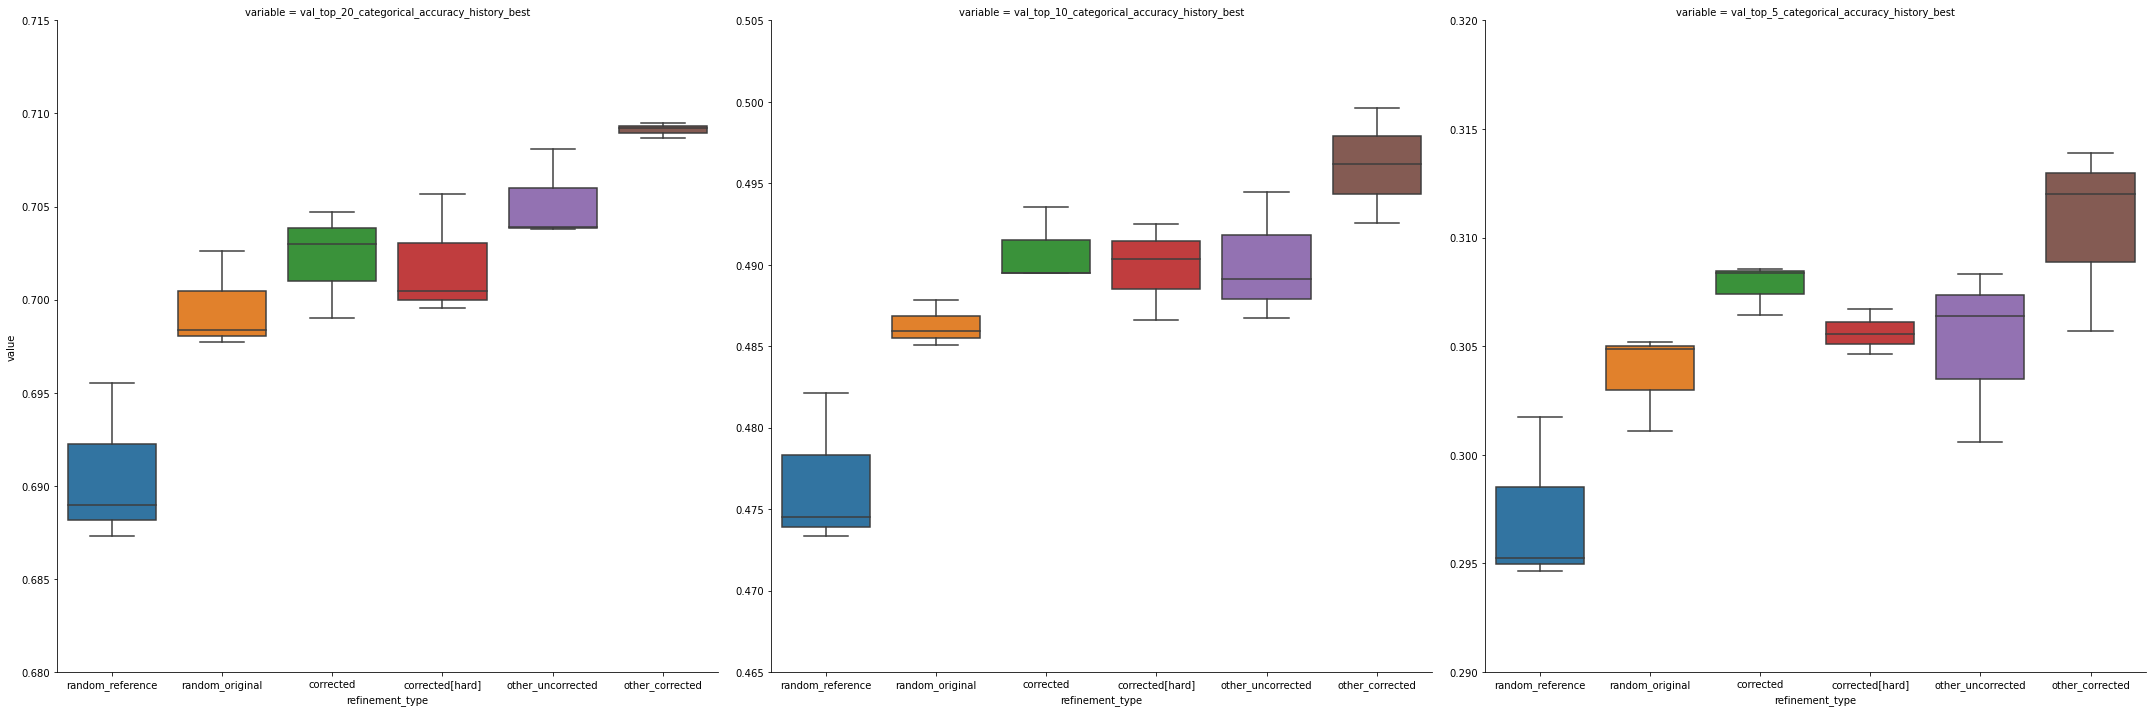

In [7]:
df = accuracy_random_df.melt(id_vars=["info_run_id", "refinement_type"], value_vars=["val_top_20_categorical_accuracy_history_best", "val_top_10_categorical_accuracy_history_best", "val_top_5_categorical_accuracy_history_best"])

g = sns.catplot(data=df,
x="refinement_type",
y="value",
col="variable",
order=["random_reference", "random_original", "corrected", "corrected[hard]", "other_uncorrected", "other_corrected"],
kind="box",
height=10,
sharey=False)

g.axes[0,0].set_ylim(0.68, 0.715)
g.axes[0,1].set_ylim(0.465, 0.505)
g.axes[0,2].set_ylim(0.29, 0.32)

In [9]:
refinement_config = RefinementConfig()
refinement_config.min_edge_weight = 0.0
refinement_config.max_train_examples = 100000
refinement_config.max_edges_to_remove = 300000
refinement_config.refinement_metric_maxrank = -1
refinement_config.refinement_metric = "mean_outlier_score"
refinement_config.max_refinement_metric = 0.0
refinement_config.corrective_factor = 1.0
refinement_config.correction_attention_scale = 1.0
refinement_config.rank_decay_rate = 2.0
refinement_config.aggregated_parents_contribution = 0.0
refinement_config.mlflow_dir = "../gsim01/mlruns/1/"
processor = KnowledgeProcessor(refinement_config)

comparisons = []

for _, reference, original in references:
    comparison = load_from_processor(0, processor, reference, original)
    attention = get_attention_for_run(original)
    comparison["attention"] = comparison.apply(lambda x: attention[x["child"]][x["parent"]], axis=1)
    comparisons = comparisons + [comparison]

In [16]:
comparisons_df = pd.concat(comparisons[0:3]).copy(deep=True)

In [19]:
comparisons_df = comparisons_df.groupby(["child", "parent"]).mean().reset_index()

In [20]:
comparisons_df = comparisons_df[comparisons_df["refinement_metric"] < 0]

In [44]:
with open("injected_comparison.pkl", "wb") as f:
    pickle.dump(comparisons_df, f) # This must be injected into the model - There is not currently a mode for this, so this needs to be rewritten from scratch (the values in this file need to replace KnowledgeProcessor.update_corrective_terms)

# Metrics

In [ ]:
# Various generic visualisations

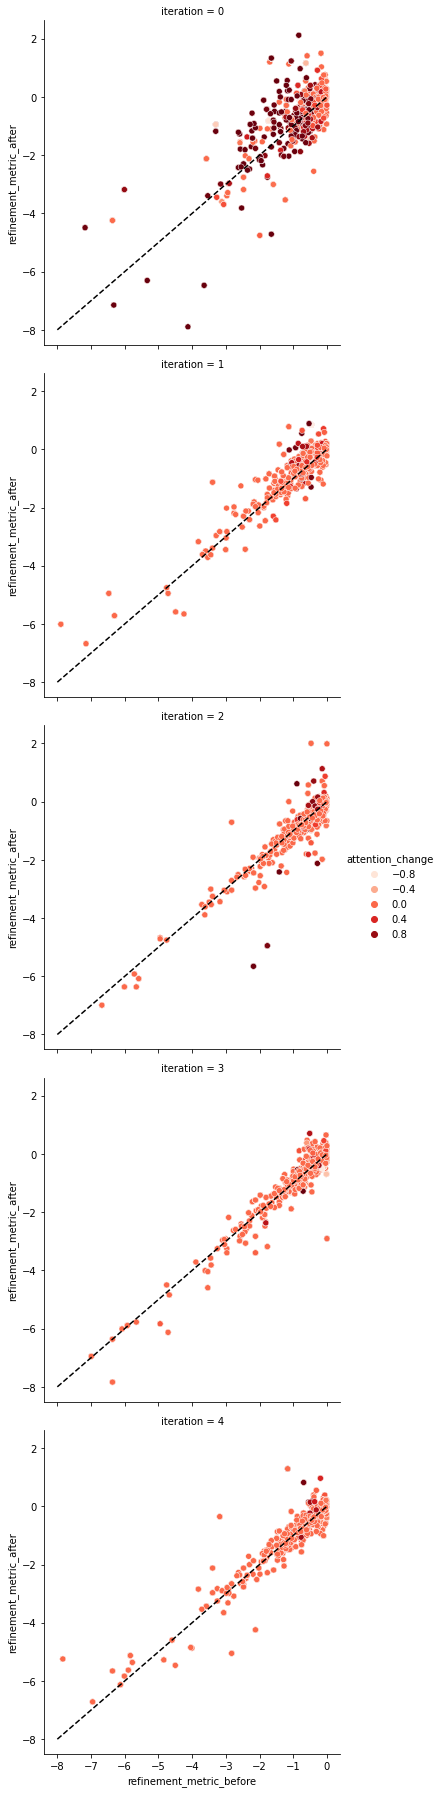

In [31]:
df = groups[90].comparison_df
plot_metric_change(df[(df["refinement_metric_before"] < 0)])

# Shows how the refinement metric changed through the refinement

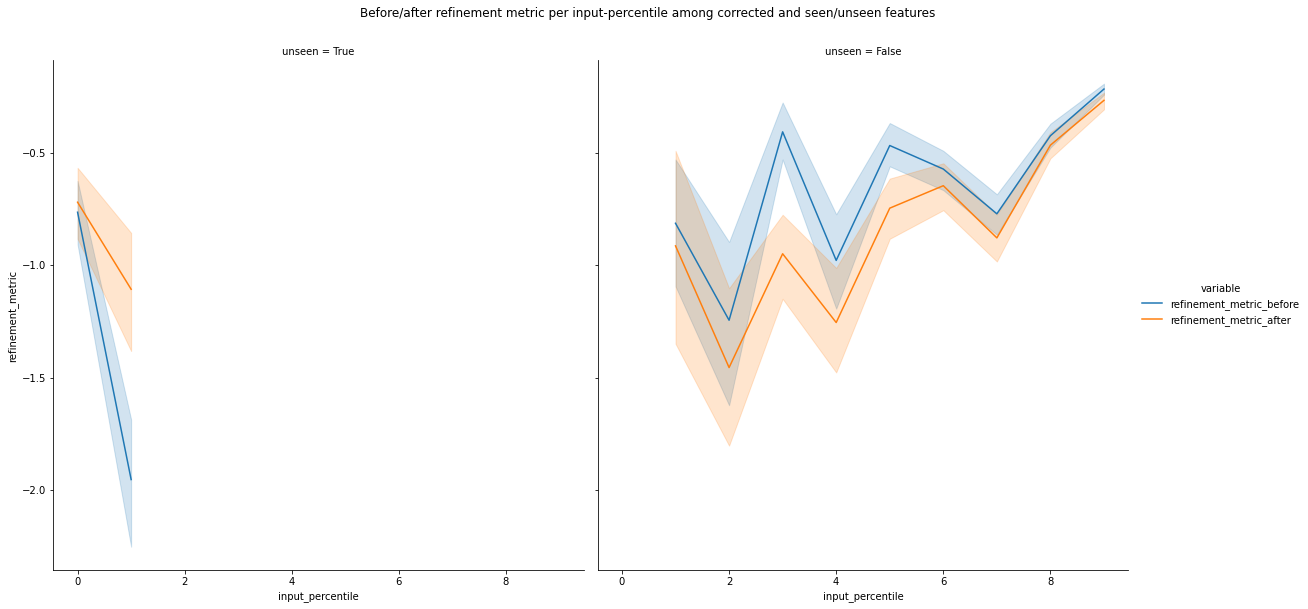

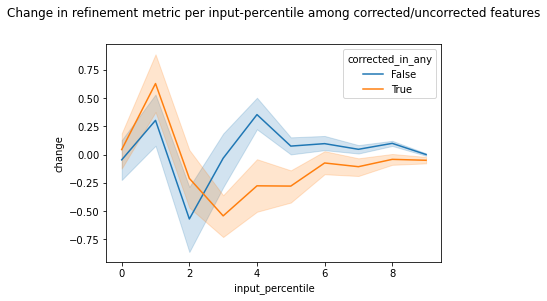

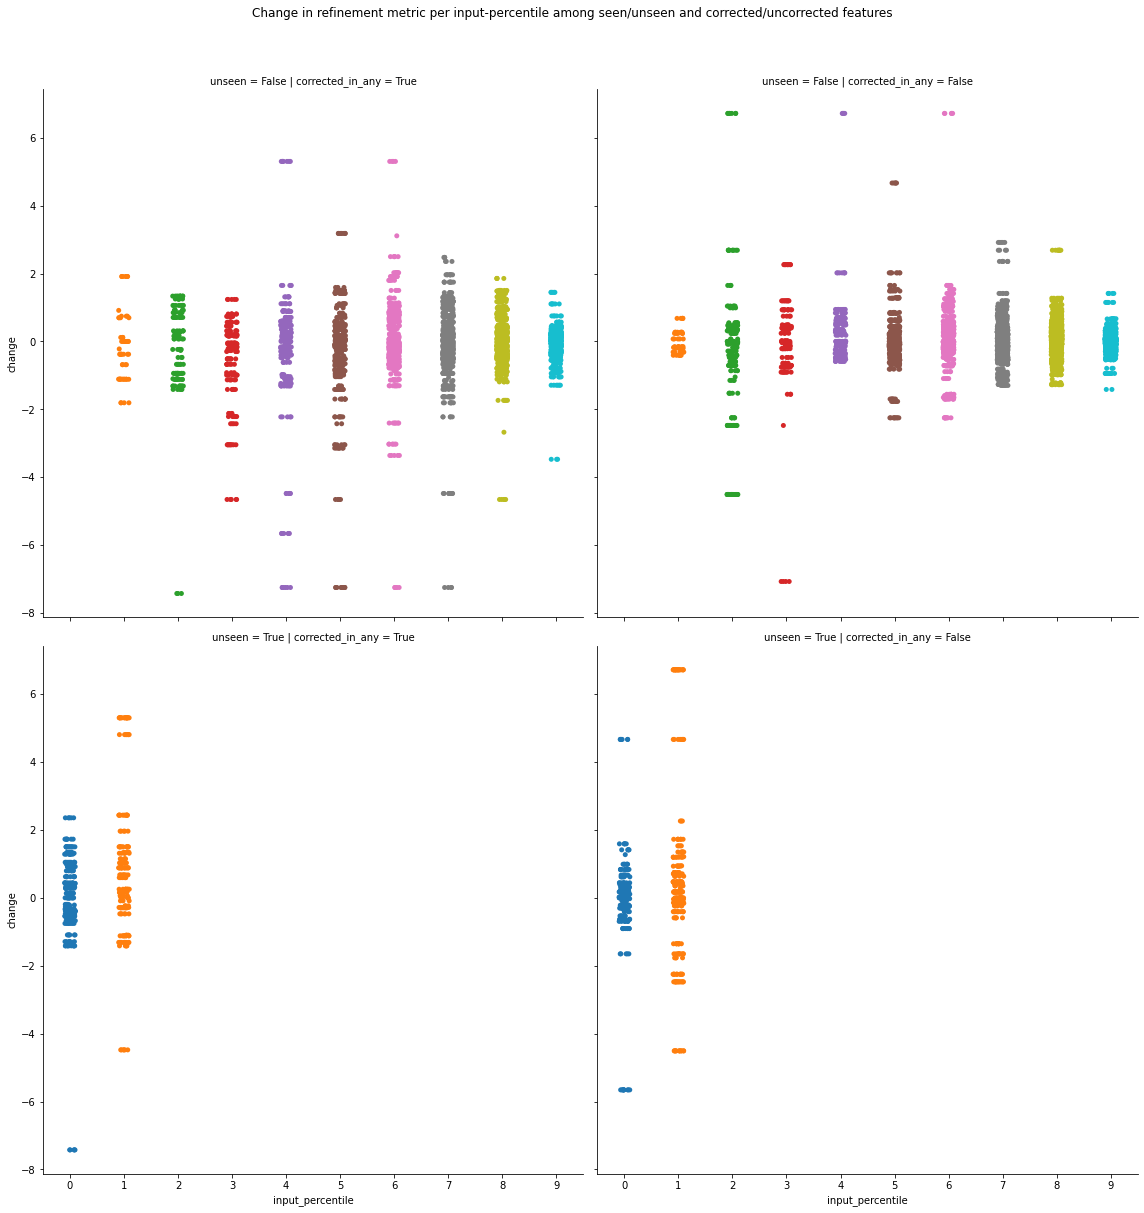

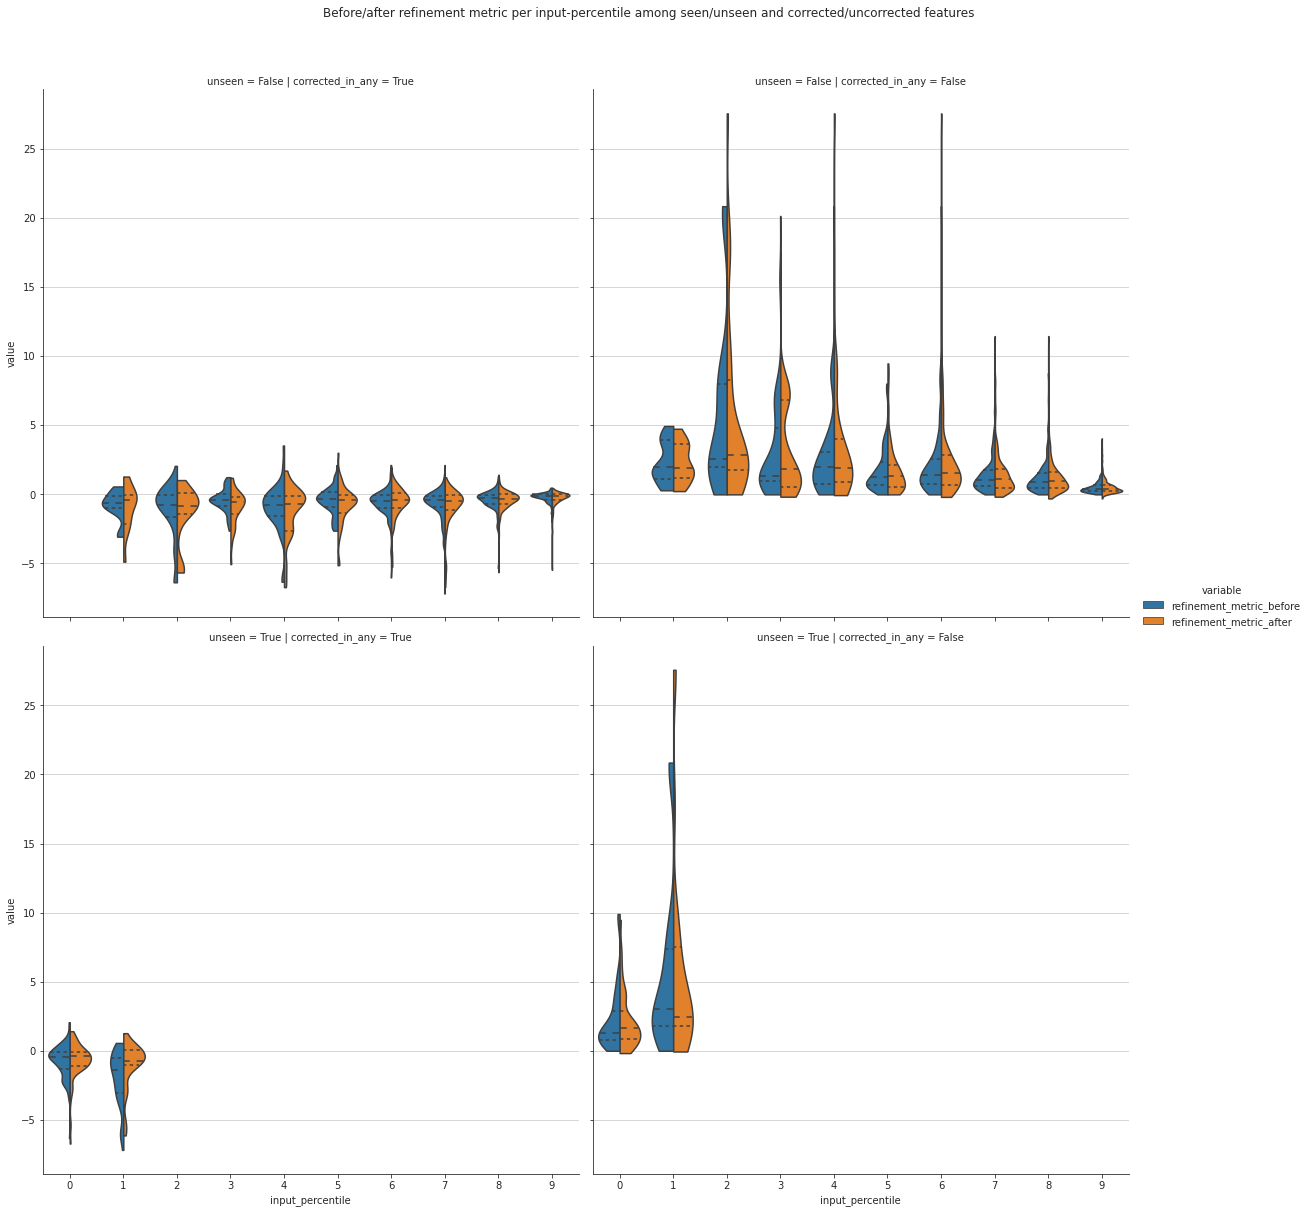

In [32]:
plot_percentile_metrics(groups[90])
# Shows how the refinement metric changed per-percentile through the refinement

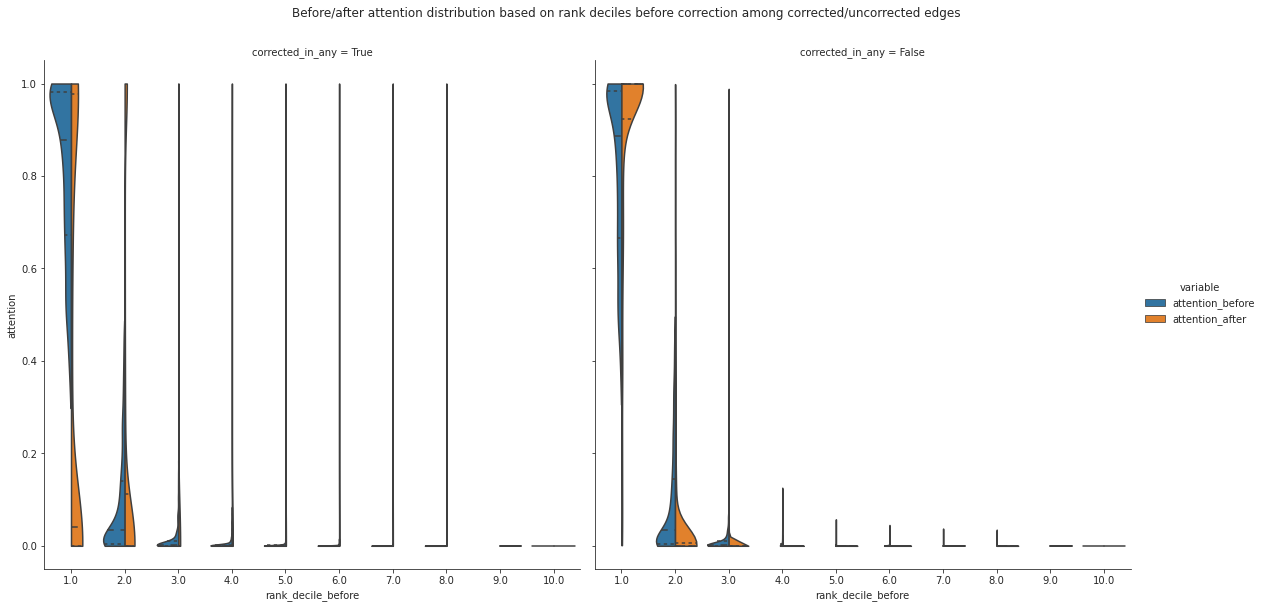

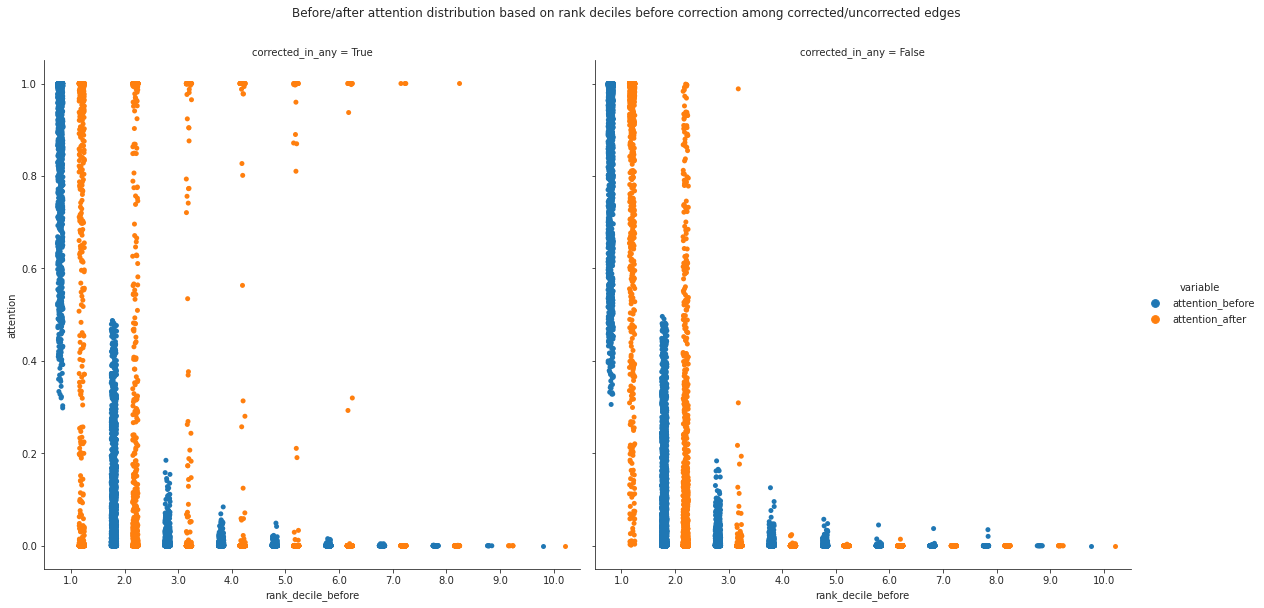

In [33]:
plot_attention_distribution(groups[90])
# Shows how the attention changed through the refinement

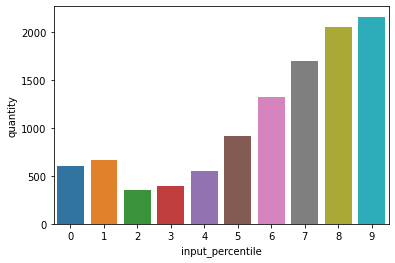

In [71]:
# Distribution of input features over input percentiles
example_df = groups[0].total_comparison_df

cumulative_input_percentile_quantities = {}

for k in range(example_df["input_percentile"].max() + 1):
    cumulative_input_percentile_quantities[k] = len(example_df[example_df["input_percentile"] == k])    

df = pd.DataFrame(cumulative_input_percentile_quantities.items(), columns=["input_percentile", "quantity"])
g = sns.barplot(data=df,
                x="input_percentile",
                y="quantity"
)
plt.show()

---

# Generating new edges

In [7]:
import re

def _type_to_order(type: str):
    if type == "reference":
        return 0

    if type == "original":
        return 1

    match = re.search("^refinement_(\d+)$", type)

    if match:
        return int(match.group(1)) + 2
    
    return -1

# generation_groups = [
#     ("1655992845.5824418", "A", groups[64]),
#     ("1656000396.437973", "B", groups[65]),
#     ("1656055825.7997282", "C", groups[66]),
#     ("1656065822.7189014", "D", None),#groups[67])
#     ("1656072240.500008", "E", None),
#     ("1656436467.0281038", "F", groups[70]),
#     ("1656596520.2398841", "G", None),
#     ("1656602824.3095694", "H", None),
#     #("1652869512.055812", "unmodified", None),
# ]

# generation_groups = [
#     ("1656065822.7189014", "D", None),#groups[67])
#     ("1656072240.500008", "E", None),
#     ("1656436467.0281038", "F", groups[70]),
#     ("1656596520.2398841", "G", None),
#     ("1656602824.3095694", "H", None),
# ]

# Groups for different refinement metric
# generation_groups = [
#     #("1657004023.2509906", "S1", None),

#     ("1657023645.701487", "rm_5.0", None),
#     ("1657038474.423578", "rm_1.0", None),
#     ("1657053981.9722977", "rm_0.0", None),
#     ("1657068048.5645857", "rm_-1.0", None),
#     ("1657112671.0324008", "rm_5.0_comp_0.8", None)
# ]

# Groups for different attention requirements
# generation_groups = [
#     ("1657187347.8991482", "att_0.8", None),
#     ("1657202130.597365", "att_0.5", None),
#     ("1657217167.527787", "att_0.2", None),
#     ("1657231629.637029", "att_0.0", None),
# ]

# Groups for different noise amounts
# generation_groups = [
#     ("1657274007.8988674", "ns_decr", None),
#     ("1657289835.4458473", "ns_2.0", None),
#     ("1657308693.671824", "ns_0.75", None),
#     ("1657324012.9855812", "ns_0.1", None)
# ]

# Groups for different refinement windows
# generation_groups = [
#     ("1657347391.7816994", "rw_0", None),
#     ("1657361896.9727771", "rw_3", None),
#     ("1657376408.1595354", "rw_-1", None)
# ]

generation_groups = [
    ("1657706690.6870894", "on_rm_0.5", None),
    ("1657723306.9193559", "on_rm_0.9", None),
    ("1657736591.1745033", "on_rm_0.9_v2", None)
]

generation_df = runs_df.copy(deep=True)

flattened_groups = [x[0] for x in generation_groups]
generation_df = generation_df[generation_df["refinement_run"].isin(flattened_groups)]
generation_df["refinement_type_order"] = generation_df["refinement_type"].apply(_type_to_order)

temp_df = generation_df.sort_values(by=["refinement_run", "refinement_type_order"])[["refinement_run", "refinement_type", "data_metrics_num_connections"]]

(0.68, 0.715)

<Figure size 720x720 with 0 Axes>

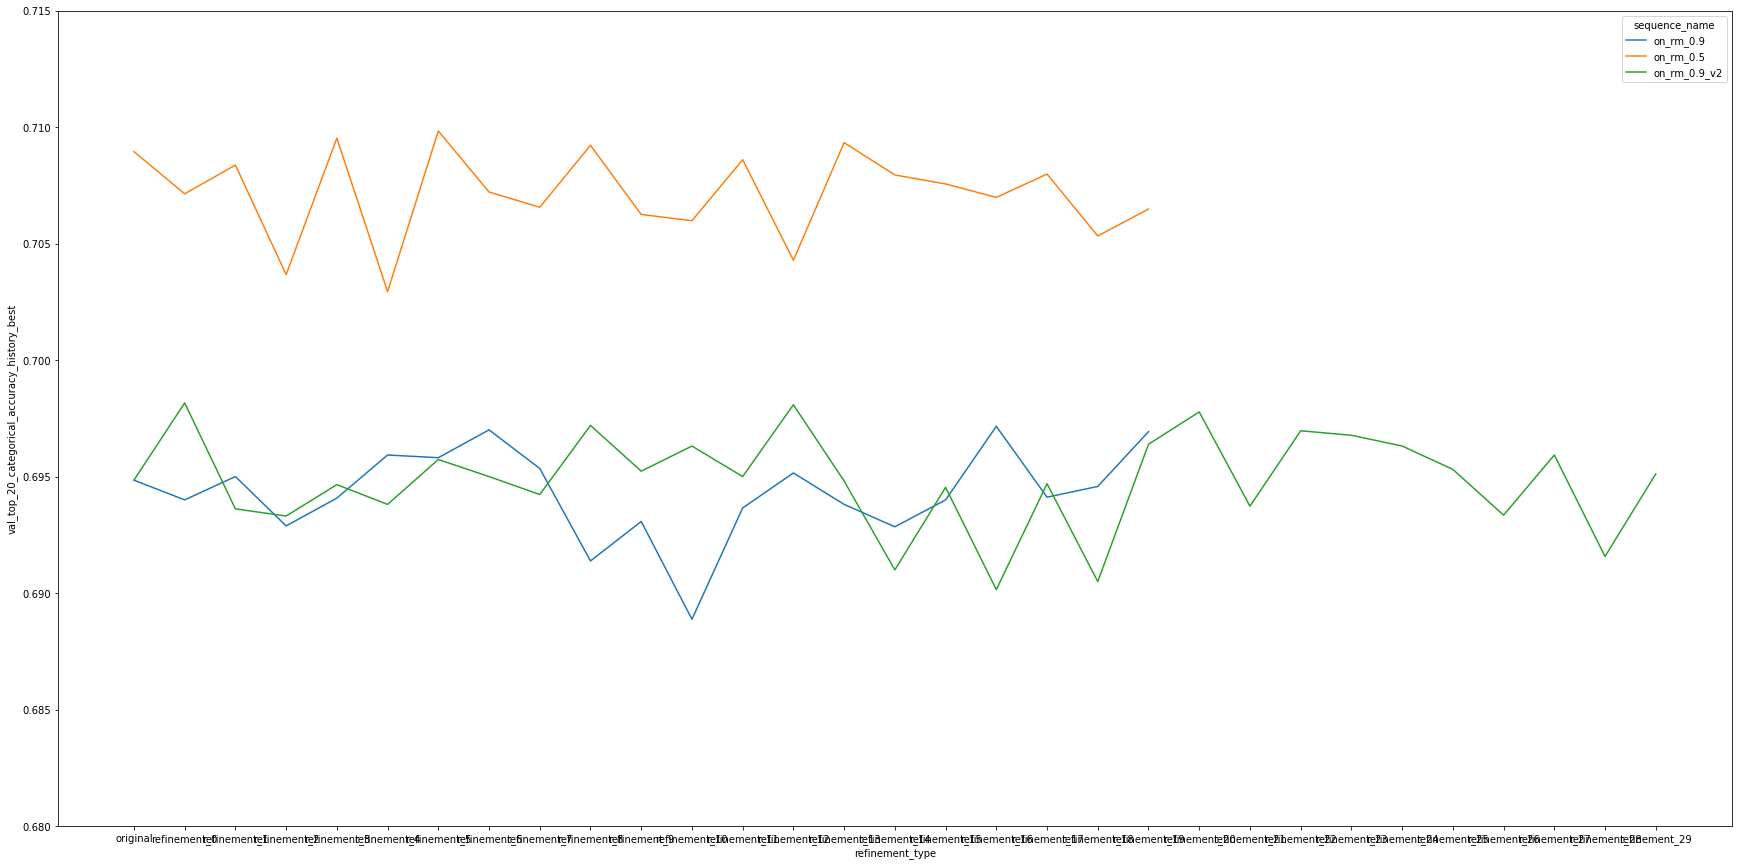

In [8]:
plt.figure(figsize=(10, 10))

df = accuracy_df[accuracy_df["refinement_run"].isin(flattened_groups)].reset_index().copy(deep=True)
df = df.sort_values(by="refinement_type_order")
df["sequence_name"] = df["refinement_run"].apply(lambda x: [name for (run, name, _) in generation_groups if run == x][0])

figure, ax1 = plt.subplots(figsize=(30, 15))

g = sns.lineplot(data=df, 
    x="refinement_type", 
    y="val_top_20_categorical_accuracy_history_best", 
    hue="sequence_name",
    sort=False,
    ax=ax1,
)
g.set_ylim(0.68, 0.715)

In [69]:
# Long generation run - How many edges were "correctly" generated and how did they perform?

with open("../gsim01/mlruns/1/048d3cb0bd6e44178617e7f47334b736/artifacts/knowledge.json") as f: # original
    starting_knowledge = json.load(f)

print(sum([len(x) for c,x in starting_knowledge.items()]))

with open("../gsim01/mlruns/1/cc76f69f61f549a4af648e4a1d89beaf/artifacts/knowledge.json") as f: # refinement_29
    knowledge = json.load(f)

print(sum([len(x) for c,x in knowledge.items()]))

with open("../gsim01/mlruns/1/cc76f69f61f549a4af648e4a1d89beaf/artifacts/attention.json") as f: # refinement_29
    attention = json.load(f)["attention_weights"]

with open("../data/gram_original_file_knowledge.json") as f:
    original_knowledge = json.load(f)

counter = 0
attentions = []
other_attentions = []

for child, parents in knowledge.items():
    for parent in parents:
        if (child in original_knowledge) and (parent in original_knowledge[child]):
            counter += 1

            if (child in attention) and parent in attention[child]:
                attentions.append(float(attention[child][parent]))
        else:
            other_attentions.append(float(attention[child][parent]))

print(counter)

print(np.mean(attentions))
print(np.mean(other_attentions))

2173
20146
7135
0.5209244854777455
0.08932471000837414


-----

## Plausibility of generated edges

In [ ]:
# Attempts to dump some information on the generated edges - This is a bit of a mess and probably doesn't work anymore, but may be useful for inspiration

In [6]:
other_df = groups[70].comparison_df

In [ ]:
load_hierarchy()

In [8]:
other_df["child_name"] = other_df.apply(lambda x: hierarchy.nodes[hierarchy.get_extended_vocab()[x["child"]]].label_name, axis=1)
other_df["parent_name"] = other_df.apply(lambda x: hierarchy.nodes[hierarchy.get_extended_vocab()[x["parent"]]].label_name, axis=1)
other_df

,refinement_metric_before,corrected,attention_before,child,parent,child_metric,parent_metric,refinement_metric_after,refinement_score,attention_after,...,input_percentile,iteration,child_metric_before,parent_metric_before,refinement_score_before,child_metric_after,parent_metric_after,refinement_score_after,child_name,parent_name
0,NaN,NaN,NaN,level_0#V10.46,level_0#V10-V19,-0.194351,-0.155049,-0.194351,0.961872,9.38166e-05,...,9,0,NaN,NaN,NaN,NaN,NaN,NaN,Personal history of malignant neoplasm of pros...,Persons With Potential Health Hazards Related...
1,NaN,NaN,NaN,level_0#V12.51,level_0#V10-V19,-0.094421,-0.155049,-0.094421,0.981290,0.0001467753,...,9,0,NaN,NaN,NaN,NaN,NaN,NaN,Personal history of venous thrombosis and embo...,Persons With Potential Health Hazards Related...
2,NaN,NaN,NaN,level_0#V17.3,level_0#V10-V19,-0.042973,-0.155049,-0.042973,0.991440,0.00023187576,...,9,0,NaN,NaN,NaN,NaN,NaN,NaN,Family history of ischemic heart disease,Persons With Potential Health Hazards Related...
3,NaN,NaN,NaN,level_0#V15.81,level_0#V10-V19,0.018608,-0.155049,0.018608,1.003729,0.00022266255,...,9,0,NaN,NaN,NaN,NaN,NaN,NaN,Personal history of noncompliance with medical...,Persons With Potential Health Hazards Related...
4,NaN,NaN,NaN,level_0#V12.04,level_0#V10-V19,0.037216,-0.155049,0.037216,1.007471,5.1113064e-05,...,9,0,NaN,NaN,NaN,NaN,NaN,NaN,Personal history of Methicillin resistant Stap...,Persons With Potential Health Hazards Related...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54937,-0.132583,1.0,0.011003164,level_0#240.9,level_0#240,NaN,NaN,-0.574524,NaN,0.12022265,...,9,3,-0.132583,-0.132583,0.973549,-0.574524,-0.574524,0.878421,"Goiter, unspecified",Simple and unspecified goiter
54938,0.282843,1.0,0.50131434,level_0#V85.32,level_0#447.7,NaN,NaN,NaN,NaN,NaN,...,4,3,0.282843,0.282843,1.123957,NaN,NaN,NaN,"Body Mass Index 32.0-32.9, adult",Aortic ectasia
54939,-1.885618,1.0,0.0034796717,level_0#V34.01,level_0#V34.0,NaN,NaN,-0.412479,NaN,0.6136862,...,5,3,-1.885618,-1.885618,0.685080,-0.412479,-0.412479,0.817928,"Other multiple birth (three or more), mates al...",Other multiple birth (three or more) mates all...
54940,4.525483,1.0,6.680639e-07,level_0#748.69,level_0#748.6,NaN,NaN,0.141421,NaN,0.0089612035,...,0,3,4.525483,4.525483,2.472173,0.141421,0.141421,1.028955,Other congenital anomalies of lung,Other congenital anomalies of lung


In [17]:
import json

with open("../data/gram_original_file_knowledge.json") as f:
    loaded_knowledge = json.load(f)

original_knowledge = loaded_knowledge

In [19]:
other_df["artificial"] = other_df.apply(lambda x: (x["child"] not in original_knowledge) or (x["parent"] not in original_knowledge[x["child"]]), axis=1)

In [11]:
other_df["attention_before"] = pd.to_numeric(other_df["attention_before"])
other_df["attention_after"] = pd.to_numeric(other_df["attention_after"])

other_df["rank_before"] = other_df.groupby(["iteration", "child"])["attention_before"].rank("dense",ascending=False)
other_df["rank_after"] = other_df.groupby(["iteration", "child"])["attention_after"].rank("dense",ascending=False)

In [12]:
df = other_df[other_df["artificial"] & (other_df["refinement_metric_before"] > 3) & (other_df["attention_before"] > 0.3) & (other_df["train_frequency"] > 0)].drop(columns=["child_metric_before", "refinement_score_before", "corrected", "child_metric_after", "refinement_metric_after", "attention_after", "change", "attention_change", "input_percentile", "iteration", "artificial", "rank_after"])

In [75]:
other_df["artificial_2"] = other_df["artificial"].sample(frac=0.5,random_state=123)
other_df["artificial_2"] = other_df["artificial_2"].fillna(False)

In [34]:
temp_df = other_df[(other_df["change"] < -0.3) & (other_df["refinement_metric_after"] < -0.1)]

In [18]:
with open("dump.csv", "w") as f:
    other_df[(other_df["child"] == "level_0#V55.3") & (other_df["iteration"] == 0)].to_csv(f)

In [33]:
temp3_df = other_df[other_df["artificial"] & (pd.to_numeric(other_df["attention_after"]) > 0.1)]
temp3_df

,child,parent,child_metric_before,parent_metric_before,refinement_metric_before,refinement_score_before,corrected,attention_before,child_metric_after,parent_metric_after,refinement_metric_after,refinement_score_after,attention_after,change,attention_change,train_frequency,input_percentile,iteration,artificial
2478,level_0#588.1,level_0#E880-E888,-2.062395,0.488970,-0.786712,0.018174,True,0.07282134,-3.123055,0.561170,-1.280943,0.001474,0.10881328,-0.494230,0.035992,12,6,0,True
2479,level_0#307.1,level_0#E880-E888,-2.272843,0.488970,-0.891936,0.006302,True,0.45802432,-1.742513,0.561170,-0.590672,0.022102,0.5893275,0.301265,0.131303,5,5,0,True
2480,level_0#815.01,level_0#E880-E888,10.842304,0.488970,5.665637,-2.785175,False,0.2641886,10.842304,0.561170,5.701737,-2.785175,0.2641886,0.036100,0.000000,0,1,0,True
2481,level_0#425.4,level_0#E880-E888,0.116117,0.488970,0.302544,-3.067342,False,0.4120054,0.177297,0.561170,0.369233,-2.304532,0.4126907,0.066690,0.000685,1331,9,0,True
2492,level_0#292.9,level_0#E880-E888,-1.783139,0.488970,-0.647084,0.018615,True,0.53685915,-2.121320,0.561170,-0.780075,0.008551,0.5823948,-0.132991,0.045536,11,6,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193116,level_0#997.5,level_0#802.2,0.107681,2.339636,1.223659,-0.885685,False,0.5422655,0.114860,2.349686,1.232273,-0.884596,0.5422594,0.008614,-0.000006,149,9,5,True
193119,level_0#852.24,level_0#802.2,0.141421,2.339636,1.240529,-11.690455,False,0.10108835,0.141421,2.349686,1.245554,-11.635673,0.10108835,0.005025,0.000000,0,1,5,True
193132,level_0#997.3,level_0#V56,0.358344,1.413798,0.886071,-3.493100,False,0.27704102,0.352595,1.407508,0.880051,-3.514786,0.27704102,-0.006020,0.000000,175,9,5,True
193134,level_0#009.1,level_0#V56,-0.875466,1.413798,0.269166,4.659934,False,0.29459554,-0.875466,1.407508,0.266021,4.486656,0.2925133,-0.003145,-0.002082,13,6,5,True


In [45]:
df = group_0.total_comparison_df.copy(deep=True)

def _make(x):
    siblings = []
    for node in hierarchy.nodes[hierarchy.get_extended_vocab()[x]].in_nodes:
        siblings = siblings + list(node.out_nodes)

    siblings = list(set(siblings))

    return ','.join((y.label_str for y in siblings))

df["neighbours"] = df["child"].apply(lambda x: _make(x))

In [47]:
def _filter(l):
    return max(df[df["child"] == sibling]["train_frequency"].min() for sibling in l)

# Are there nodes with low train frequency which then emphasise a sibling with higher train frequency through attention? (answer: no, not really)
df["sibling_freq"] = df.apply(lambda x: _filter((x["neighbours"]).split(",")), axis=1)
df

,child,parent,child_metric_before,refinement_metric_before,refinement_score_before,corrected,attention_before,child_metric_after,refinement_metric_after,refinement_score_after,attention_after,change,attention_change,train_frequency,input_percentile,neighbours,sibling_freq
0,level_0#303.00,level_0#303,0.093040,0.093040,1.0,False,0.0006462437,0.093040,0.093040,1.0,0.0006462437,0.0,0.0,32,8,"level_0#303.02,level_0#303.01,level_0#303.00,l...",437.0
1,level_0#285.1,level_0#280-289,0.529808,0.529808,1.0,False,0.23670782,0.529808,0.529808,1.0,0.23670782,0.0,0.0,1674,9,"level_0#285.3,level_0#285.8,level_0#285.2,leve...",2472.0
2,level_0#952.00,level_0#950-957,-0.848528,-0.848528,1.0,True,0.030953703,-0.848528,-0.848528,1.0,0.030953703,0.0,0.0,6,5,"level_0#952.00,level_0#952.04,level_0#952.02,l...",6.0
3,level_0#863.21,level_0#863,3.181981,3.181981,1.0,False,0.96117854,3.181981,3.181981,1.0,0.96117854,0.0,0.0,0,1,"level_0#863.21,level_0#863.29",0.0
4,level_0#434.11,level_0#-1,0.575627,0.575627,1.0,False,0.0040818113,0.575627,0.575627,1.0,0.0040818113,0.0,0.0,130,9,"level_0#434.10,level_0#434.11",130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10704,level_0#E939.4,level_0#E939,0.448409,0.448409,1.0,False,0.06814512,0.448409,0.448409,1.0,0.06814512,0.0,0.0,74,8,"level_0#E939.0,level_0#E939.7,level_0#E939.8,l...",NaN
10705,level_0#294.11,level_0#294.1,1.393416,1.393416,1.0,False,0.0025450245,1.393416,1.393416,1.0,0.0025450245,0.0,0.0,11,6,"level_0#294.10,level_0#294.11",127.0
10706,level_0#998.2,level_0#-1,0.498914,0.498914,1.0,False,0.00013057317,0.498914,0.498914,1.0,0.00013057317,0.0,0.0,261,9,"level_0#998.1,level_0#998.4,level_0#998.5,leve...",NaN
10707,level_0#238.79,level_0#-1,2.283607,2.283607,1.0,False,1.0935153e-06,2.283607,2.283607,1.0,1.0935153e-06,0.0,0.0,13,6,"level_0#238.76,level_0#238.72,level_0#238.77,l...",NaN


In [ ]:
df["freq_diff"] = df.apply(lambda x: x["train_frequency"] - x["sibling_freq"], axis=1)

# Hierarchy attention distribution

In [ ]:
# Analysis for attention distribution patterns in the hierarchy (this included the common model where all features only have 4 nodes so they can be compared)

In [6]:
from src.refinement import RefinementConfig, KnowledgeProcessor
import tensorflow as tf
import random
from src.features import preprocessing
from src.features.preprocessing import mimic
from src.features import sequences
from src.features.sequences import transformer as trfm
from src.features import knowledge
import json

def find_path(visited, current, target, path=[]):
    if current not in visited:
        visited.add(current)

        if current.label_str == target:
            return path

        neighbours = current.get_neighbours()

        for neighbour in neighbours:
            result = find_path(visited, neighbour, target, path + [neighbour])

            if result is not None:
                return result

    return None

def compute_hierarchy_distance(hierarchy, child, parent):
    child_id = hierarchy.get_extended_vocab()[child]

    visited = set()
    path = find_path(visited, hierarchy.nodes[child_id], parent)
    path = [node.label_str for node in path]
    distance = len(path)

    if "level_0#-1" in path:
        distance_to_root = path.index("level_0#-1") + 1
        return pd.Series([np.nan, distance - distance_to_root, distance])
    else:
        return pd.Series([distance, 0, distance])

def _parent_from_hierarchy(hierarchy, child: str):
    child_id = hierarchy.get_extended_vocab()[child]

    for parent in hierarchy.nodes[child_id].in_nodes:
        return parent.label_str

def _siblings_from_hierarchy(hierarchy, child: str):
    parent = _parent_from_hierarchy(hierarchy, child)
    parent_id = hierarchy.get_extended_vocab()[parent]

    return [sibling.label_str for sibling in hierarchy.nodes[parent_id].out_nodes]

def _map_to_hierarchy(mapping, parent: str):
    raw_parent_code = parent[8:]

    if raw_parent_code == "-1":
        # The root has no further abstraction
        return pd.Series(["-1", "-1", "-1", "-1"])

    return pd.Series([level[raw_parent_code] for _, level in mapping.items()])

def snap_to_4_node_hierarchy(distance_before: float, distance: float, root_distance: float):
    lower_snap_point = 1
    upper_snap_point = 2
    new_root_distance = 3

    if distance > root_distance / 2.0:
        return new_root_distance if np.isnan(distance_before) else min(upper_snap_point, distance)

    return min(distance, lower_snap_point)

def load_data_for_attention_distribution(reference_run_id: str, refinement_run_id: str, config: RefinementConfig):
    processor = KnowledgeProcessor(config)

    comparison_df = load_from_processor(0, processor, reference_run_id, refinement_run_id)
    original_attention = get_attention_for_run(refinement_run_id)
    frequency_lookup = processor._load_input_frequency_dict(refinement_run_id)
    comparison_df["train_frequency"] = comparison_df.apply(lambda x: frequency_lookup.get(x["child"], {}).get("absolue_frequency", 0.0), axis=1)
    input_percentiles = load_input_percentiles(frequency_lookup, 10)
    comparison_df["attention"] = comparison_df.apply(lambda x: float(original_attention[x["child"]][x["parent"]]), axis=1)
    comparison_df["input_percentile"] = comparison_df["child"].apply(lambda x: next(i for i in range(len(input_percentiles)) if x in input_percentiles[i]))

    hierarchy, hierarchy_mapping_df = load_hierarchy()
    
    comparison_df[["distance_before", "distance_after", "distance"]] = comparison_df.apply(lambda x: compute_hierarchy_distance(hierarchy, x["child"], x["parent"]), axis=1)
    comparison_df["normalised_distance"] = (
        comparison_df.apply(
            lambda x: snap_to_4_node_hierarchy(
                        x["distance_before"],
                        x["distance"],
                        comparison_df[comparison_df["child"] == x["child"]]["distance_before"].max() + 1
                    ),
            axis=1
        )
    )

    with open("../data/gram_original_file_knowledge.json", "r") as f:
        loaded_knowledge = json.load(f)

    comparison_df["artificial"] = comparison_df.apply(lambda x: (x["child"] not in loaded_knowledge) or (x["parent"] not in loaded_knowledge[x["child"]]), axis=1)
    comparison_df["is_leaf"] = comparison_df.apply(lambda x: hierarchy.nodes[hierarchy.get_extended_vocab()[x["parent"]]].is_leaf(), axis=1)

    mapping_df = hierarchy_mapping_df.copy(deep=True).set_index('level_0')
    mapping = mapping_df.to_dict()

    comparison_df["parent_0"] = comparison_df.apply(lambda x: _parent_from_hierarchy(hierarchy, x["child"]), axis=1)
    comparison_df[["parent_1", "parent_2", "parent_3", "parent_4"]] = comparison_df.apply(lambda x : _map_to_hierarchy(mapping, x["parent_0"]), axis=1)

    for level in ["0", "1", "2", "3", "4"]:
        comparison_df = comparison_df.merge(comparison_df.groupby("parent_{}".format(level))["child"].nunique().reset_index().rename(columns={"child": "siblings_{}".format(level)}), on="parent_{}".format(level))

    comparison_df["acc_sibling_freq"] = comparison_df.apply(lambda x: sum([frequency_lookup.get(sibling, {}).get("absolue_frequency", 0.0) for sibling in _siblings_from_hierarchy(hierarchy, x["child"])]), axis=1)

    return comparison_df

In [61]:
def print_general_per_edge_stats(df: pd.DataFrame, original_attention):
    flattened_original_attention = []
    flattened_full_original_attention = []

    for child, parents in original_attention.items():
        for parent, attention in parents.items():
            if child != parent:
                flattened_original_attention.append((child, parent, float(attention))) # Ignore self attention here

            flattened_full_original_attention.append((child, parent, float(attention)))

    attention_df = pd.DataFrame.from_records(flattened_original_attention, columns=["child", "parent", "attention"])
    full_attention_df = pd.DataFrame.from_records(flattened_full_original_attention, columns=["child", "parent", "attention"])

    non_ignored_edges = lambda x: len([e for e in x if e > 0.01])
    non_ignored_edges.__name__ = "non_ignored_edges"
    total_edges = lambda x: len(x)
    total_edges.__name__ = "total_edges"

    per_input_attention_df = attention_df.groupby("child")["attention"].agg([non_ignored_edges, total_edges])
    per_input_attention_df["percentage_ignored"] = per_input_attention_df.apply(lambda x: 1.0 - x["non_ignored_edges"] / x["total_edges"], axis=1)

    per_input_df = per_input_attention_df.copy(deep=True)
    per_input_df["refinement_metric"] = df.groupby("child")["refinement_metric"].mean()
    per_input_df["weighted_distance"] = df.groupby("child").apply(lambda x: pd.Series.mul(x["attention"], x["distance"]).sum())
    per_input_df["train_frequency"] = df.groupby("child")["train_frequency"].min() # train_frequency is independent of the parent

    avg_per_input_percentage_ignored = round(per_input_attention_df["percentage_ignored"].mean() * 100.0, ndigits=2)
    print("Average percentage of edges ignored per input: {}".format(avg_per_input_percentage_ignored))

    # The average amount of ignored edges is slightly lower for successful inputs than for unsuccessful inputs

    avg_ignored_among_successful_inputs = round(per_input_df[per_input_df["refinement_metric"] >= 5]["percentage_ignored"].mean() * 100.0, ndigits=2)
    avg_ignored_among_unsuccessful_inputs = round(per_input_df[per_input_df["refinement_metric"] < 5]["percentage_ignored"].mean() * 100.0, ndigits=2)

    print("Average amount of ignored edges:")
    print("Among successful: {}".format(avg_ignored_among_successful_inputs))
    print("Among unsuccessful: {}".format(avg_ignored_among_unsuccessful_inputs))
    print("---")

    # The average distance among non-ignored inputs is lower than among ignored inputs

    avg_distance_among_ignored_inputs = round(df[df["attention"] < 0.01]["distance"].mean(), ndigits=2)
    avg_distance_among_non_ignored_inputs = round(df[df["attention"] >= 0.01]["distance"].mean(), ndigits=2)

    print("Average distance of edges")
    print("Among ignored: {}".format(avg_distance_among_ignored_inputs))
    print("Among non-ignored: {}".format(avg_distance_among_non_ignored_inputs))

    return per_input_df

config = RefinementConfig()
config.refinement_metric = "mean_outlier_score"
config.compatibility_factor = 0.0
config.restrict_outputs_to_ancestors = False
config.max_refinement_metric = 0.0
config.max_train_examples = 100000
config.min_edge_weight = 0.0
config.refinement_metric_maxrank = -1
config.mlflow_dir = "../gsim01/mlruns/1/"
config.corrective_factor = 0.0
config.correction_attention_scale = 0.0
config.rank_decay_rate = 0.0
config.aggregated_parents_contribution = 0.0

reference_run_id = "1bdceb1e06b34f949447dc4d006ea9fe"
#refinement_run_id = "acdfe482e0d34ddd923cbfa2599600ae" # original hierarchy + 2.0 noise
refinement_run_id = "d5b778d8f909447baa8f8c709aedbf07" # original hierarchy, new order

df = load_data_for_attention_distribution(reference_run_id, refinement_run_id, config)
original_attention = get_attention_for_run(refinement_run_id)
per_input_df = print_general_per_edge_stats(df, original_attention)

Building Hierarchy from df: 18960it [00:00, 25061.71it/s]


Average percentage of edges ignored per input: 47.54
Average amount of ignored edges:
Among successful: 53.2
Among unsuccessful: 46.93
---
Average distance of edges
Among ignored: 2.67
Among non-ignored: 1.89


In [62]:
per_input_extended_df = pd.merge(per_input_df, df[["child", "input_percentile"]].drop_duplicates(), on="child")

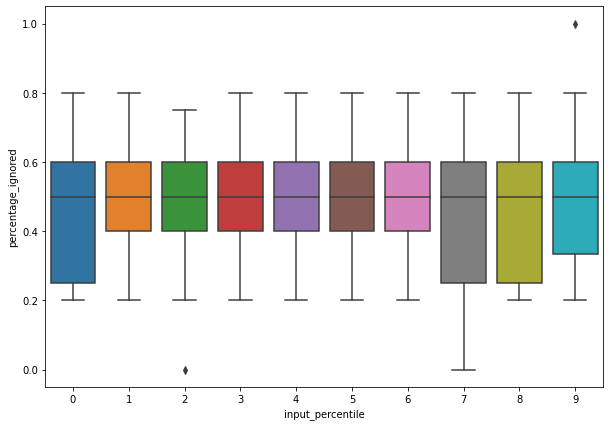

In [63]:
plt.figure(figsize=(10,7))
ax = sns.boxplot(data=per_input_extended_df,
x="input_percentile",
y="percentage_ignored")
fig = plt.gcf()

# Percentage of ignored edges depending on the input percentile

In [64]:
fig.savefig("per_percentile_ignored.svg", format="svg", facecolor="white")
fig.savefig("per_percentile_ignored.png", format="png", facecolor="white", dpi=300)

## Additional custom visualisations for node attention assignment

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from typing import List

def make_attention_distribution_plot(df: pd.DataFrame, bar_color: str = 'black', node_radius: float = 0.3):
    df = df.sort_values(by=["distance_before", "distance"])
    fig = plt.figure(figsize=(3, 4), facecolor='white')

    ax1 = fig.add_axes([0.6, 0.0, 1.0, 1.0])
    ax2 = fig.add_axes([0.0, 0.0, 0.6, 1.0], sharey=ax1)

    y_pos = np.arange(len(df))
    ax1.barh(y_pos, df["attention"], tick_label='', height=0.3, color=bar_color)

    ax1.set_xlim(0, 1.0)
    ax1.xaxis.tick_top()
    ax1.set_xticks([0.0, 0.5, 1.0])
    ax1.tick_params(left=False, top=False)
    ax1.xaxis.grid()
    ax1.xaxis.get_gridlines()[-1].set_clip_on(False)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax2.set_axis_off()
    ax2.set_aspect('equal', adjustable='datalim')

    index = 0

    for _, row in df.iterrows():
        parent = row["parent"]
        is_root = parent == "level_0#-1"

        direct_siblings = row["siblings_0"]
        is_cross_edge = row["distance_after"] > 0

        y = y_pos[index]

        connection_dir = '<-' if is_cross_edge else '->'
        line_style = '--' if row["artificial"] else '-'

        node = plt.Circle((0.5, y), node_radius, fill=is_root, color='black', linestyle=line_style)
        
        ax2.add_patch(node)

        if not is_root:
            if not is_cross_edge:
                connection = patches.ConnectionPatch((0.5, y + node_radius), (0.5, y + 1 - node_radius), coordsA='data', arrowstyle=connection_dir)
            else:
                connection = patches.ConnectionPatch((0.5, y - 1 + node_radius), (0.5, y - node_radius), coordsA='data', arrowstyle=connection_dir)
            ax2.add_patch(connection)
            ax2.annotate("{}".format(row["parent"][8:]), (0.5 + node_radius + 0.1, y - node_radius / 2.0))

        arrow_offset = np.sqrt(node_radius * node_radius / 2)

        should_draw_siblings = row["is_leaf"]

        if direct_siblings > 0 and should_draw_siblings:
            if not is_cross_edge:
                sibling = patches.ConnectionPatch((1.0, y + node_radius), (0.5 + arrow_offset, y + 1 - arrow_offset), coordsA='data', arrowstyle=connection_dir)
            else:
                sibling = patches.ConnectionPatch((0.5 + arrow_offset, y - 1 + arrow_offset), (1.0, y - node_radius), coordsA='data', arrowstyle=connection_dir)
            ax2.add_patch(sibling)
            ax2.annotate("{}".format(row["siblings_0"]), (-0.3, y + 0.5 if not is_cross_edge else y - 0.5))

        if direct_siblings > 1 and should_draw_siblings:
            if not is_cross_edge:
                sibling = patches.ConnectionPatch((0.0, y + node_radius), (0.5 - arrow_offset, y + 1 - arrow_offset), coordsA='data', arrowstyle=connection_dir)
            else:
                sibling = patches.ConnectionPatch((0.5 - arrow_offset, y - 1 + arrow_offset), (0.0, y - node_radius), coordsA='data', arrowstyle=connection_dir)
            ax2.add_patch(sibling)

        index = index + 1

    fig.suptitle("Attention distribution for {}\n rm: {}, freq: {}, sbl3: {}, sbl4: {}".format(df["child"].iloc[0], round(df["refinement_metric"].iloc[0], ndigits=2), df["train_frequency"].iloc[0], df["siblings_3"].iloc[0], df["siblings_4"].iloc[0]), x=0.75, y=1.2)
    
    return fig

In [8]:
from svgutils.transform import from_mpl, SVGFigure
from matplotlib import colormaps
from functools import partial

def sample_gradient(current: float, upper_end: float, lower_end: float, mid_point: float) -> str:
    success_mix = max(min((current - mid_point) / (upper_end - mid_point), 1.0), 0.0)
    failure_mix = min(max((current - lower_end) / (mid_point - lower_end), 0.0), 1.0)

    mix = (success_mix + failure_mix) / 2.0

    return colormaps.get('rainbow_r')(mix)

accuracy_gradient = partial(sample_gradient, upper_end=0.9, lower_end=0.2, mid_point=0.4)
refinement_metric_gradient = partial(sample_gradient, upper_end=10.0, lower_end=-3.0, mid_point=0.5)

def make_plot_from_group(group, gradient, color_metric: bool = True):
    color = gradient(group["refinement_metric"].min()) if color_metric else 'black'

    fig = make_attention_distribution_plot(group, bar_color=color)
    svg_figure = from_mpl(fig, {'bbox_inches': 'tight', 'pad_inches': 0.2, 'facecolor': fig.get_facecolor()})
    plt.close()

    return svg_figure

def make_attention_distribution_overview(df: pd.DataFrame, gradient, column_count = 10, color_metric: bool = True):
    figures = []

    for _, group in df.groupby("child", sort=False):
        figures.append(make_plot_from_group(group, gradient, color_metric))

    root = SVGFigure("50cm", "20cm")

    x_offset = 0
    y_offset = 0
    current_row_max_y = 0
    current_column_count = 0

    total_width = 0
    total_height = 0

    for figure in figures:
        figure.root.set("transform", "translate({}, {})".format(x_offset, y_offset))
        root.append(figure)

        x_offset += float(figure.width)
        current_row_max_y = max(current_row_max_y, float(figure.height))
        current_column_count += 1

        total_width = max(total_width, x_offset)
        total_height = max(total_height, y_offset + current_row_max_y)

        if current_column_count > column_count:
            y_offset += current_row_max_y
            current_column_count = 0
            current_row_max_y = 0
            x_offset = 0

    root.root.set("width", str(total_width))
    root.root.set("height", str(total_height))

    return root

In [12]:
import os

def make_sibling_distribution(df: pd.DataFrame, dir: str):
    all_levels_df = pd.DataFrame()

    for n in range(5):
        which = "siblings_{}".format(n)
        count_df = df.groupby(which)["child"].count().reset_index().rename(columns={which: "siblings", "child": "count"})
        count_df["which"] = which

        all_levels_df = all_levels_df.append(count_df)

    fig = sns.catplot(data=all_levels_df,
        col="which",
        x="siblings",
        y="count",
        kind="bar",
        sharex=False,
        sharey=False,
        height=10)
    fig.savefig(dir + "sibling_distribution.svg", format='svg', facecolor='white')
    plt.close()

def make_aggregated_patterns(df: pd.DataFrame, dir: str):
    df = df.merge(df.groupby(["child", "normalised_distance"])["attention"].sum().reset_index().rename(columns={"attention": "acc_attention"}), on=["child", "normalised_distance"])

    fig = sns.catplot(data=df.drop_duplicates(subset=["child", "normalised_distance", "acc_attention"]),
        col="sibling_freq",
        row="frequency",
        col_order=["high", "medium", "low"],
        row_order=["high", "medium", "low"],
        x="normalised_distance",
        y="acc_attention",
        hue="metric",
        hue_order=["high", "medium", "low"],
        kind="bar",
        palette="crest")
    fig.savefig(dir + "aggregated_pattern_sibling_freq.svg", format='svg', facecolor='white')
    plt.close()

    fig = sns.catplot(data=df.drop_duplicates(subset=["child", "normalised_distance", "acc_attention"]),
        col="siblings",
        row="frequency",
        col_order=["high", "medium", "low"],
        row_order=["high", "medium", "low"],
        x="normalised_distance",
        y="acc_attention",
        hue="metric",
        hue_order=["high", "medium", "low"],
        kind="bar",
        palette="crest")
    fig.savefig(dir + "aggregated_pattern_num_siblings.svg", format='svg', facecolor='white')
    plt.close()

def generate_hierarchy_attention_distribution(reference_run_id: str, refinement_run_id: str, config: RefinementConfig, dir: str):
    config.restrict_outputs_to_ancestors = False
    config.max_refinement_metric = 0.0
    config.max_train_examples = 100000
    config.min_edge_weight = 0.0
    config.refinement_metric_maxrank = -1
    config.mlflow_dir = "../gsim01/mlruns/1/"
    config.corrective_factor = 0.0
    config.correction_attention_scale = 0.0
    config.rank_decay_rate = 0.0
    config.aggregated_parents_contribution = 0.0

    df = load_data_for_attention_distribution(reference_run_id, refinement_run_id, config)
    print("Starting generation of plots...")

    os.makedirs(dir)
    make_sibling_distribution(df, dir)

    if "standalone" in config.refinement_metric or "accuracy" in config.refinement_metric:
        gradient = accuracy_gradient
        low_metric = 0.4
        high_metric = 0.6
    else:
        gradient = refinement_metric_gradient
        low_metric = -1.0
        high_metric = 3.0

    low_percentile = 5
    high_percentile = 6
    low_siblings = 10
    high_siblings = 50
    low_acc_sibling_freq = 30
    high_acc_sibling_freq = 200

    df["metric"] = df["refinement_metric"].apply(lambda x: "high" if x > high_metric else "low" if x < low_metric else "medium")
    df["siblings"] = df["siblings_3"].apply(lambda x: "high" if x >= high_siblings else "low" if x <= low_siblings else "medium")
    df["sibling_freq"] = df["acc_sibling_freq"].apply(lambda x: "high" if x > high_acc_sibling_freq else "low" if x < low_acc_sibling_freq else "medium")
    df["frequency"] = df["input_percentile"].apply(lambda x: "high" if x > high_percentile else "low" if x < low_percentile else "medium")

    make_aggregated_patterns(df.copy(deep=True), dir)
    sorted_df = df.sort_values(by="refinement_metric", ascending=False)
    lexicographical_sorted_df = df.sort_values(by="child")

    low_metric_df = sorted_df[sorted_df["metric"] == "low"]
    high_metric_df = sorted_df[sorted_df["metric"] == "high"]

    make_attention_distribution_overview(low_metric_df, gradient=gradient).save(dir + "low_metric.svg")
    make_attention_distribution_overview(high_metric_df, gradient=gradient).save(dir + "high_metric.svg")

    make_attention_distribution_overview(lexicographical_sorted_df[lexicographical_sorted_df["metric"] == "low"], gradient=gradient).save(dir + "similar_low_metric.svg")
    make_attention_distribution_overview(lexicographical_sorted_df[lexicographical_sorted_df["metric"] == "high"], gradient=gradient).save(dir + "similar_high_metric.svg")

    for input_percentile in range(10):
        make_attention_distribution_overview(low_metric_df[low_metric_df["input_percentile"] == input_percentile], gradient=gradient).save(dir + "percentile_{}_low_metric.svg".format(input_percentile))
        make_attention_distribution_overview(high_metric_df[high_metric_df["input_percentile"] == input_percentile], gradient=gradient).save(dir + "percentile_{}_high_metric.svg".format(input_percentile))

        make_attention_distribution_overview(sorted_df[(sorted_df["input_percentile"] == input_percentile) & (sorted_df["sibling_freq"] == "high")], gradient=gradient).save(dir + "percentile_{}_high_acc_sibling_freq.svg".format(input_percentile))
        make_attention_distribution_overview(sorted_df[(sorted_df["input_percentile"] == input_percentile) & (sorted_df["sibling_freq"] == "low")], gradient=gradient).save(dir + "percentile_{}_low_acc_sibling_freq.svg".format(input_percentile))

    low_input_percentile_df = sorted_df[sorted_df["frequency"] == "low"]
    high_input_percentile_df = sorted_df[sorted_df["frequency"] == "high"]

    make_attention_distribution_overview(low_input_percentile_df[low_input_percentile_df["metric"] == "low"], gradient=gradient).save(dir + "low_freq_low_metric.svg")
    make_attention_distribution_overview(low_input_percentile_df[low_input_percentile_df["metric"] == "high"], gradient=gradient).save(dir + "low_freq_high_metric.svg")
    make_attention_distribution_overview(high_input_percentile_df[high_input_percentile_df["metric"] == "high"], gradient=gradient).save(dir + "high_freq_low_metric.svg")
    make_attention_distribution_overview(high_input_percentile_df[high_input_percentile_df["metric"] == "high"], gradient=gradient).save(dir + "high_freq_high_metric.svg")

    high_siblings_df = sorted_df[sorted_df["siblings"] == "high"]
    low_siblings_df = sorted_df[sorted_df["siblings"] == "low"]

    make_attention_distribution_overview(high_siblings_df[high_siblings_df["metric"] == "low"], gradient=gradient).save(dir + "high_siblings_low_metric.svg")
    make_attention_distribution_overview(high_siblings_df[high_siblings_df["metric"] == "high"], gradient=gradient).save(dir + "high_siblings_high_metric.svg")

    make_attention_distribution_overview(low_siblings_df[low_siblings_df["metric"] == "low"], gradient=gradient).save(dir + "low_siblings_low_metric.svg")
    make_attention_distribution_overview(low_siblings_df[low_siblings_df["metric"] == "high"], gradient=gradient).save(dir + "low_siblings_high_metric.svg")

    make_attention_distribution_overview(low_input_percentile_df[(low_input_percentile_df["metric"] == "low") & (low_input_percentile_df["siblings"] == "low")], gradient=gradient).save(dir + "low_freq_low_siblings_low_metric.svg")
    make_attention_distribution_overview(low_input_percentile_df[(low_input_percentile_df["metric"] == "high") & (low_input_percentile_df["siblings"] == "low")], gradient=gradient).save(dir + "low_freq_low_siblings_high_metric.svg")
    make_attention_distribution_overview(low_input_percentile_df[(low_input_percentile_df["metric"] == "low") & (low_input_percentile_df["siblings"] == "high")], gradient=gradient).save(dir + "low_freq_high_siblings_low_metric.svg")
    make_attention_distribution_overview(low_input_percentile_df[(low_input_percentile_df["metric"] == "high") & (low_input_percentile_df["siblings"] == "high")], gradient=gradient).save(dir + "low_freq_high_siblings_high_metric.svg")

    make_attention_distribution_overview(high_input_percentile_df[(high_input_percentile_df["metric"] == "low") & (high_input_percentile_df["siblings"] == "low")], gradient=gradient).save(dir + "high_freq_low_siblings_low_metric.svg")
    make_attention_distribution_overview(high_input_percentile_df[(high_input_percentile_df["metric"] == "high") & (high_input_percentile_df["siblings"] == "low")], gradient=gradient).save(dir + "high_freq_low_siblings_high_metric.svg")
    make_attention_distribution_overview(high_input_percentile_df[(high_input_percentile_df["metric"] == "low") & (high_input_percentile_df["siblings"] == "high")], gradient=gradient).save(dir + "high_freq_high_siblings_low_metric.svg")
    make_attention_distribution_overview(high_input_percentile_df[(high_input_percentile_df["metric"] == "high") & (high_input_percentile_df["siblings"] == "high")], gradient=gradient).save(dir + "high_freq_high_siblings_high_metric.svg")

    make_attention_distribution_overview(low_input_percentile_df[(low_input_percentile_df["metric"] == "low") & (low_input_percentile_df["sibling_freq"] == "low")], gradient=gradient).save(dir + "low_freq_low_sibling_freq_low_metric.svg")
    make_attention_distribution_overview(low_input_percentile_df[(low_input_percentile_df["metric"] == "high") & (low_input_percentile_df["sibling_freq"] == "low")], gradient=gradient).save(dir + "low_freq_low_sibling_freq_high_metric.svg")
    make_attention_distribution_overview(low_input_percentile_df[(low_input_percentile_df["metric"] == "low") & (low_input_percentile_df["sibling_freq"] == "high")], gradient=gradient).save(dir + "low_freq_high_sibling_freq_low_metric.svg")
    make_attention_distribution_overview(low_input_percentile_df[(low_input_percentile_df["metric"] == "high") & (low_input_percentile_df["sibling_freq"] == "high")], gradient=gradient).save(dir + "low_freq_high_sibling_freq_high_metric.svg")

    make_attention_distribution_overview(high_input_percentile_df[(high_input_percentile_df["metric"] == "low") & (high_input_percentile_df["sibling_freq"] == "low")], gradient=gradient).save(dir + "high_freq_low_sibling_freq_low_metric.svg")
    make_attention_distribution_overview(high_input_percentile_df[(high_input_percentile_df["metric"] == "high") & (high_input_percentile_df["sibling_freq"] == "low")], gradient=gradient).save(dir + "high_freq_low_sibling_freq_high_metric.svg")
    make_attention_distribution_overview(high_input_percentile_df[(high_input_percentile_df["metric"] == "low") & (high_input_percentile_df["sibling_freq"] == "high")], gradient=gradient).save(dir + "high_freq_high_sibling_freq_low_metric.svg")
    make_attention_distribution_overview(high_input_percentile_df[(high_input_percentile_df["metric"] == "high") & (high_input_percentile_df["sibling_freq"] == "high")], gradient=gradient).save(dir + "high_freq_high_sibling_freq_high_metric.svg")

In [18]:
refinement_config = RefinementConfig()
refinement_config.refinement_metric = "standalone"
refinement_config.compatibility_factor = 0.0

#generate_hierarchy_attention_distribution("1bdceb1e06b34f949447dc4d006ea9fe", "acdfe482e0d34ddd923cbfa2599600ae", refinement_config, "patterns/noisy/standalone/")
#generate_hierarchy_attention_distribution("1bdceb1e06b34f949447dc4d006ea9fe", "d5b778d8f909447baa8f8c709aedbf07", refinement_config, "patterns/unmodified/standalone/")

refinement_config.refinement_metric = "mean_outlier_score"
#generate_hierarchy_attention_distribution("1bdceb1e06b34f949447dc4d006ea9fe", "acdfe482e0d34ddd923cbfa2599600ae", refinement_config, "patterns/noisy/outlier/")
generate_hierarchy_attention_distribution("1bdceb1e06b34f949447dc4d006ea9fe", "d5b778d8f909447baa8f8c709aedbf07", refinement_config, "patterns/unmodified/outlier_v2/")

refinement_config.compatibility_factor = 0.9
#generate_hierarchy_attention_distribution("1bdceb1e06b34f949447dc4d006ea9fe", "acdfe482e0d34ddd923cbfa2599600ae", refinement_config, "patterns/noisy/outlier_compat/")
generate_hierarchy_attention_distribution("1bdceb1e06b34f949447dc4d006ea9fe", "d5b778d8f909447baa8f8c709aedbf07", refinement_config, "patterns/unmodified/outlier_compat_v2/")

# This will generate a bunch of data on patterns in the attention distribution in the directory patterns

Building Hierarchy from df: 18960it [00:00, 24898.82it/s]


Starting generation of plots...


/home/ubuntu/anaconda3/envs/healthcare-aiops/lib/python3.8/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)
Building Hierarchy from df: 18960it [00:00, 24515.35it/s]


Starting generation of plots...


/home/ubuntu/anaconda3/envs/healthcare-aiops/lib/python3.8/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


### Enforcing distribution patterns

In [ ]:
# This section attempts to adjust the attention distribution to fit with various patterns identified earlier

In [53]:
import numpy as np
from typing import Dict, List, Tuple
import copy

def normal_distribution(sigma: float, mu: float):
    return lambda x: 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def combined_normal_distribution(centers: List[Tuple[int, float, float]]):
    return lambda x: max(min(sum([weight * normal_distribution(sigma, center)(x) for center, sigma, weight in centers]), 1.0), 0.0)

def adjust_distribution_for_input(current: List[float], centers: List[Tuple[int, float, float]], blending_factor: float):
    # Translate relative indices to absolute indices to fix up distribution (as we want to allow indexing from the back)
    centers = [(len(current) + i if i < 0 else i, sigma, weight) for i, sigma, weight in centers]

    updated_distribution = [combined_normal_distribution(centers)(i) for i in range(len(current))]

    differences = [(i, current[i] - updated_distribution[i]) for i in range(len(current))]
    edges_with_attention_to_spare = [x for x in differences if x[1] > 0]

    result = current

    for sender, available_amount in edges_with_attention_to_spare:
        differences = [(i, result[i] - updated_distribution[i]) for i in range(len(result))]
        edges_in_need_of_attention = [(i, -amount) for i, amount in differences if amount < 0]
        total_needed_amount = max(0.0, sum(map(lambda x: x[1], edges_in_need_of_attention)))

        actual_available_amount = min(total_needed_amount, available_amount * blending_factor)

        for recipient, needed_amount in edges_in_need_of_attention:
            amount = actual_available_amount * (needed_amount / total_needed_amount)
            result[recipient] += amount
            result[sender] -= amount

    return result

def adjust_distribution(
    df: pd.DataFrame,
    current_attention: Dict[str, Dict[str, float]],
    centers: List[Tuple[int, float, float]],
    blending_factor: float
):
    for _, group in df.groupby("child"):
        sorted_edges = group.sort_values(by=["distance_before", "distance"])
        candidate = group["child"].iloc[0]

        parent_order = list(sorted_edges["parent"])
        current = list(sorted_edges["attention"])
        current = adjust_distribution_for_input(current, centers, blending_factor)

        index = 0
        for parent in parent_order:
            current_attention[candidate][parent] = current[index]
            index += 1

    return current_attention

def enforce_distribution_patterns(reference_run_id: str, refinement_run_id: str):
    config = RefinementConfig()
    config.refinement_metric = "standalone"
    config.compatibility_factor = 0.0
    config.restrict_outputs_to_ancestors = False
    config.max_refinement_metric = 0.0
    config.max_train_examples = 100000
    config.min_edge_weight = 0.0
    config.refinement_metric_maxrank = -1
    config.mlflow_dir = "../gsim01/mlruns/1/"
    config.corrective_factor = 0.0
    config.correction_attention_scale = 0.0
    config.rank_decay_rate = 0.0
    config.aggregated_parents_contribution = 0.0

    df = load_data_for_attention_distribution(reference_run_id, refinement_run_id, config)

    if "standalone" in config.refinement_metric or "accuracy" in config.refinement_metric:
        low_metric = 0.4
        high_metric = 0.6
    else:
        low_metric = -1.0
        high_metric = 3.0

    low_percentile = 5
    high_percentile = 6
    low_siblings = 10
    high_siblings = 50
    low_acc_sibling_freq = 30
    high_acc_sibling_freq = 200

    df["metric"] = df["refinement_metric"].apply(lambda x: "high" if x > high_metric else "low" if x < low_metric else "medium")
    df["siblings"] = df["siblings_3"].apply(lambda x: "high" if x >= high_siblings else "low" if x <= low_siblings else "medium")
    df["sibling_freq"] = df["acc_sibling_freq"].apply(lambda x: "high" if x > high_acc_sibling_freq else "low" if x < low_acc_sibling_freq else "medium")
    df["frequency"] = df["input_percentile"].apply(lambda x: "high" if x > high_percentile else "low" if x < low_percentile else "medium")

    original_attention = get_attention_for_run(refinement_run_id)

    updated_attention: Dict[str, Dict[str, float]] = copy.deepcopy(original_attention)
    adjusted_inputs = []

    # These patterns are mostly just guessed from the aggregated attention distribution and from GRAM
    low_freq_high_sibling_freq_df = df[(df["input_percentile"] < 5) & (df["acc_sibling_freq"] > 200) & (df["refinement_metric"] < 0.4)]
    adjusted_inputs.append(low_freq_high_sibling_freq_df)
    updated_attention = adjust_distribution(low_freq_high_sibling_freq_df, updated_attention, [(1, 0.4, 0.9), (0, 0.1, 0.1)], 0.95)

    low_freq_low_sibling_freq_df = df[(df["input_percentile"] < 5) & (df["acc_sibling_freq"] < 30) & (df["refinement_metric"] < 0.4)]
    adjusted_inputs.append(low_freq_low_sibling_freq_df)
    updated_attention = adjust_distribution(low_freq_low_sibling_freq_df, updated_attention, [(-2, 0.4, 1.0), (-1, 0.2, -0.8)], 0.95)

    high_freq_low_sibling_count_df = df[(df["input_percentile"] > 6) & (df["siblings_3"] <= 10) & (df["refinement_metric"] < 0.4)]
    adjusted_inputs.append(high_freq_low_sibling_count_df)
    updated_attention = adjust_distribution(high_freq_low_sibling_count_df, updated_attention, [(0, 0.8, 1.0)], 0.95)

    high_freq_high_sibling_count_df = df[(df["input_percentile"] > 6) & (df["siblings_3"] >= 50) & (df["refinement_metric"] < 0.4)]
    adjusted_inputs.append(high_freq_high_sibling_count_df)
    updated_attention = adjust_distribution(high_freq_high_sibling_count_df, updated_attention, [(0, 1.3, 1.0)], 0.95)

    return updated_attention, adjusted_inputs

In [55]:
# Original hierarchy
updated_attention, adjusted_inputs = enforce_distribution_patterns("1bdceb1e06b34f949447dc4d006ea9fe", "d5b778d8f909447baa8f8c709aedbf07")

Building Hierarchy from df: 18960it [00:00, 25137.49it/s]


In [56]:
with open("../data/injected_attention_A.json", "w") as knowledge_file:
    json.dump(updated_attention, knowledge_file) # This is the adjusted attention that must be injected into the model - There is an inject mode for this

In [57]:
# 50% of added edges
updated_attention, adjusted_inputs = enforce_distribution_patterns("1bdceb1e06b34f949447dc4d006ea9fe", "1a4e0ddc634342fab22095d67887ee88")

Building Hierarchy from df: 18960it [00:00, 25386.08it/s]


In [58]:
with open("../data/injected_attention_B.json", "w") as knowledge_file:
    json.dump(updated_attention, knowledge_file)

In [59]:
# 100% of added edges
updated_attention, adjusted_inputs = enforce_distribution_patterns("1bdceb1e06b34f949447dc4d006ea9fe", "0e3df611a8a64117a5740d81d929c557")

Building Hierarchy from df: 18960it [00:00, 25826.16it/s]


In [60]:
with open("../data/injected_attention_C.json", "w") as knowledge_file:
    json.dump(updated_attention, knowledge_file)

In [61]:
# Replaced 50% of real edges with artificial edges
updated_attention, adjusted_inputs = enforce_distribution_patterns("1bdceb1e06b34f949447dc4d006ea9fe", "571864b4c21148689cc6bb3ba9c57033")

Building Hierarchy from df: 18960it [00:00, 25703.54it/s]


In [ ]:
with open("../data/injected_attention_D.json", "w") as knowledge_file:
    json.dump(updated_attention, knowledge_file)

In [35]:
with open("../data/injected_attention.json", "w") as knowledge_file:
    json.dump(updated_attention, knowledge_file)

In [14]:
# The remainder of this section is analyses the the enforcement of the attention distribution

config = RefinementConfig()
config.refinement_metric = "standalone"
config.compatibility_factor = 0.0
config.restrict_outputs_to_ancestors = False
config.max_refinement_metric = 0.0
config.max_train_examples = 100000
config.min_edge_weight = 0.0
config.refinement_metric_maxrank = -1
config.mlflow_dir = "../gsim01/mlruns/1/"
config.corrective_factor = 0.0
config.correction_attention_scale = 0.0
config.rank_decay_rate = 0.0
config.aggregated_parents_contribution = 0.0

reference_run_id = "1bdceb1e06b34f949447dc4d006ea9fe"
#refinement_run_id = "51d63d6638eb4eb3bb33027751dc48b6"
#refinement_run_id = "b02535fa0ccc4848810bae9d922be628"
#refinement_run_id = "960ab6a490b74f81a06220a12f840974" # retrain from scratch
refinement_run_id = "f8f61369cfa24f58969ca7bc34bb1140" # no retraining

df = load_data_for_attention_distribution(reference_run_id, refinement_run_id, config)

Building Hierarchy from df: 18960it [00:00, 25240.73it/s]


In [16]:
outputs = []

for inputs in adjusted_inputs:
    results = []

    before_df = inputs.copy(deep=True)
    after_df = df.copy(deep=True)

    for child in before_df.drop_duplicates(subset="child")["child"]:
        before_metric = before_df[before_df["child"] == child]["refinement_metric"].min()
        after_metric = after_df[after_df["child"] == child]["refinement_metric"].min()

        results.append((child, before_metric, after_metric, before_metric - after_metric))

    outputs.append(pd.DataFrame.from_records(results, columns=["child", "before", "after", "diff"]))

In [19]:
analysis = []

for output in outputs:
    total = len(output)
    num_improved = len(output[output["diff"] < 0.0])
    num_worsened = len(output[output["diff"] > 0.0])

    percentage_improved = round(num_improved / total * 100.0, ndigits=2)
    percentage_worsened = round(num_worsened / total * 100.0, ndigits=2)

    avg_before = output["before"].mean()
    avg_after = output["after"].mean()
    avg_change = output["diff"].mean()

    analysis.append((num_improved, percentage_improved, num_worsened, percentage_worsened, avg_before, avg_after, avg_change))

temp_df = pd.DataFrame.from_records(analysis, columns=["num_improved", "percentage_improved", "num_worsened", "percentage_worsened", "avg_before", "avg_after", "avg_change"])

In [11]:
def make_attention_distribution_comparison(before_df: pd.DataFrame, after_df: pd.DataFrame, gradient, color_metric: bool = True):
    figures = []

    for child in before_df.drop_duplicates(subset="child")["child"]:
        figures.append(make_plot_from_group(before_df[before_df["child"] == child], gradient, color_metric))
        figures.append(make_plot_from_group(after_df[after_df["child"] == child], gradient, color_metric))

    root = SVGFigure("50cm", "20cm")

    y_offset = 0

    total_width = 0
    total_height = 0

    for i in range(int(len(figures) / 2)):
        before = figures[2 * i]
        after = figures[2 * i + 1]

        before.root.set("transform", "translate(0, {})".format(y_offset))
        root.append(before)

        x_offset = float(before.width)
        after.root.set("transform", "translate({}, {})".format(x_offset, y_offset))
        root.append(after)

        y_offset += max(float(before.height), float(after.height))

        total_width = max(total_width, x_offset + float(after.width))
        total_height = max(total_height, y_offset)

    root.root.set("width", str(total_width))
    root.root.set("height", str(total_height))

    return root

In [16]:
# This visualises the comparison of various adjusted input features (i.e. if we changed the attention distribution, this shows the before and after)

index = 0
for inputs in adjusted_inputs:
    make_attention_distribution_comparison(inputs, df, accuracy_gradient).save("patterns/result_no_retrain/pattern_{}.svg".format(index))
    index += 1

# General metrics

In [8]:
gather_stats_for_group_artificial(groups[43].comparison_df)

,num_connections,num_artificial,num_real,percentage_artificial,percentage_real,num_artificial_ignored_before,percentage_artificial_ignored_before,num_artificial_ignored_after,percentage_artificial_ignored_after,num_real_ignored_before,percentage_real_ignored_before,num_real_ignored_after,percentage_real_ignored_after,threshold,iteration
0,32193,21484,10709,66.74,33.26,17730,82.53,19539,90.95,7390,69.01,8850,82.64,0.01,0


In [7]:
gather_stats_for_group_artificial(groups[40].comparison_df, 0.01)

,num_connections,num_artificial,num_real,percentage_artificial,percentage_real,num_artificial_ignored_before,percentage_artificial_ignored_before,num_artificial_ignored_after,percentage_artificial_ignored_after,num_real_ignored_before,percentage_real_ignored_before,num_real_ignored_after,percentage_real_ignored_after,threshold,iteration
0,32193,21484,10709,66.74,33.26,17730,82.53,18283,85.10,7390,69.01,7718,72.07,0.01,0
1,32193,21484,10709,66.74,33.26,18283,85.10,18851,87.74,7718,72.07,8017,74.86,0.01,1
2,32193,21484,10709,66.74,33.26,18851,87.74,19091,88.86,8017,74.86,8185,76.43,0.01,2


In [18]:
gather_stats_for_group_artificial(groups[41].comparison_df, 0.01)

,num_connections,num_artificial,num_real,percentage_artificial,percentage_real,num_artificial_ignored_before,percentage_artificial_ignored_before,num_artificial_ignored_after,percentage_artificial_ignored_after,num_real_ignored_before,percentage_real_ignored_before,num_real_ignored_after,percentage_real_ignored_after,threshold,iteration
0,32193,21484,10709,66.74,33.26,17730,82.53,17737,82.56,7390,69.01,7383,68.94,0.01,0
1,32193,21484,10709,66.74,33.26,17737,82.56,17737,82.56,7383,68.94,7375,68.87,0.01,1
2,32193,21484,10709,66.74,33.26,17737,82.56,18072,84.12,7375,68.87,7566,70.65,0.01,2
3,32193,21484,10709,66.74,33.26,18072,84.12,18067,84.10,7566,70.65,7518,70.20,0.01,3
4,32193,21484,10709,66.74,33.26,18067,84.10,18141,84.44,7518,70.20,7598,70.95,0.01,4


In [27]:
gather_stats_for_group_artificial(groups[42].comparison_df, 0.01)

,num_connections,num_artificial,num_real,percentage_artificial,percentage_real,num_artificial_ignored_before,percentage_artificial_ignored_before,num_artificial_ignored_after,percentage_artificial_ignored_after,num_real_ignored_before,percentage_real_ignored_before,num_real_ignored_after,percentage_real_ignored_after,threshold,iteration
0,32193,21484,10709,66.74,33.26,17730,82.53,17966,83.63,7390,69.01,7533,70.34,0.01,0
1,32193,21484,10709,66.74,33.26,17966,83.63,17985,83.71,7533,70.34,7584,70.82,0.01,1
2,32193,21484,10709,66.74,33.26,17985,83.71,18210,84.76,7584,70.82,7694,71.85,0.01,2
3,32193,21484,10709,66.74,33.26,18210,84.76,18224,84.83,7694,71.85,7676,71.68,0.01,3
4,32193,21484,10709,66.74,33.26,18224,84.83,18276,85.07,7676,71.68,7724,72.13,0.01,4


In [8]:
gather_stats_for_group_artificial(groups[26].comparison_df, 0.01)

,num_connections,num_artificial,num_real,percentage_artificial,percentage_real,num_artificial_ignored_before,percentage_artificial_ignored_before,num_artificial_ignored_after,percentage_artificial_ignored_after,num_real_ignored_before,percentage_real_ignored_before,num_real_ignored_after,percentage_real_ignored_after,threshold,iteration
0,11795,1086,10709,9.21,90.79,738,67.96,739,68.05,6122,57.17,6140,57.33,0.01,0
1,11795,1086,10709,9.21,90.79,739,68.05,744,68.51,6140,57.33,6169,57.61,0.01,1
2,11795,1086,10709,9.21,90.79,744,68.51,750,69.06,6169,57.61,6207,57.96,0.01,2


In [9]:
gather_stats_for_group_artificial(groups[38].comparison_df, 0.01)

,num_connections,num_artificial,num_real,percentage_artificial,percentage_real,num_artificial_ignored_before,percentage_artificial_ignored_before,num_artificial_ignored_after,percentage_artificial_ignored_after,num_real_ignored_before,percentage_real_ignored_before,num_real_ignored_after,percentage_real_ignored_after,threshold,iteration
0,32193,21484,10709,66.74,33.26,17730,82.53,21484,100.0,7390,69.01,5638,52.65,0.01,0


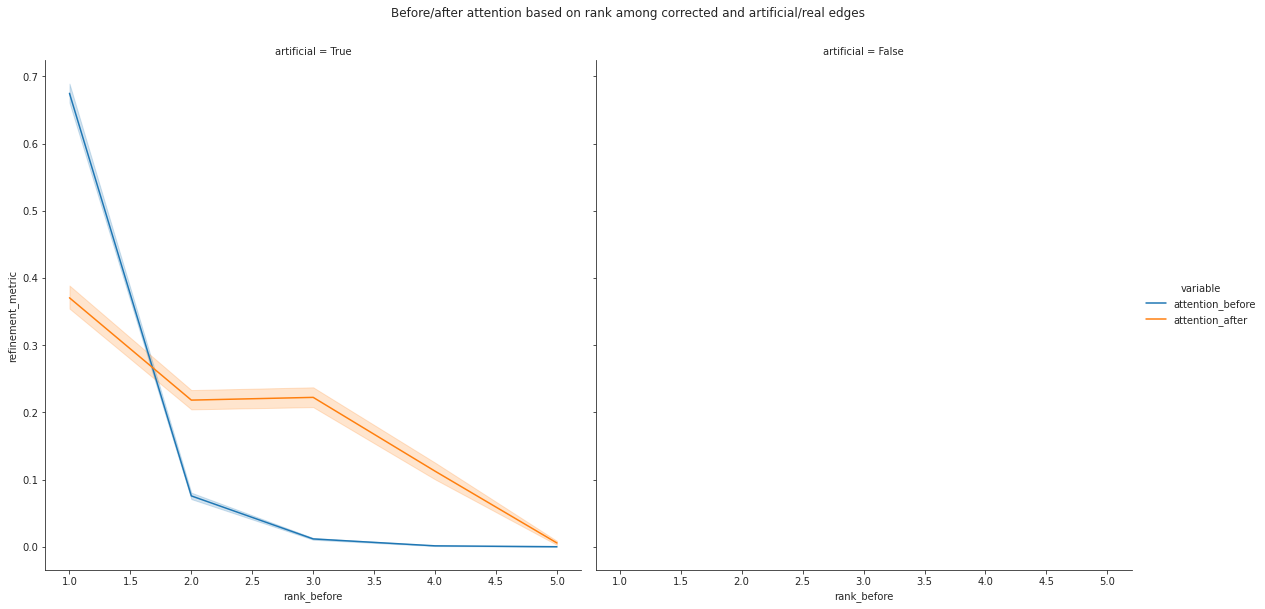

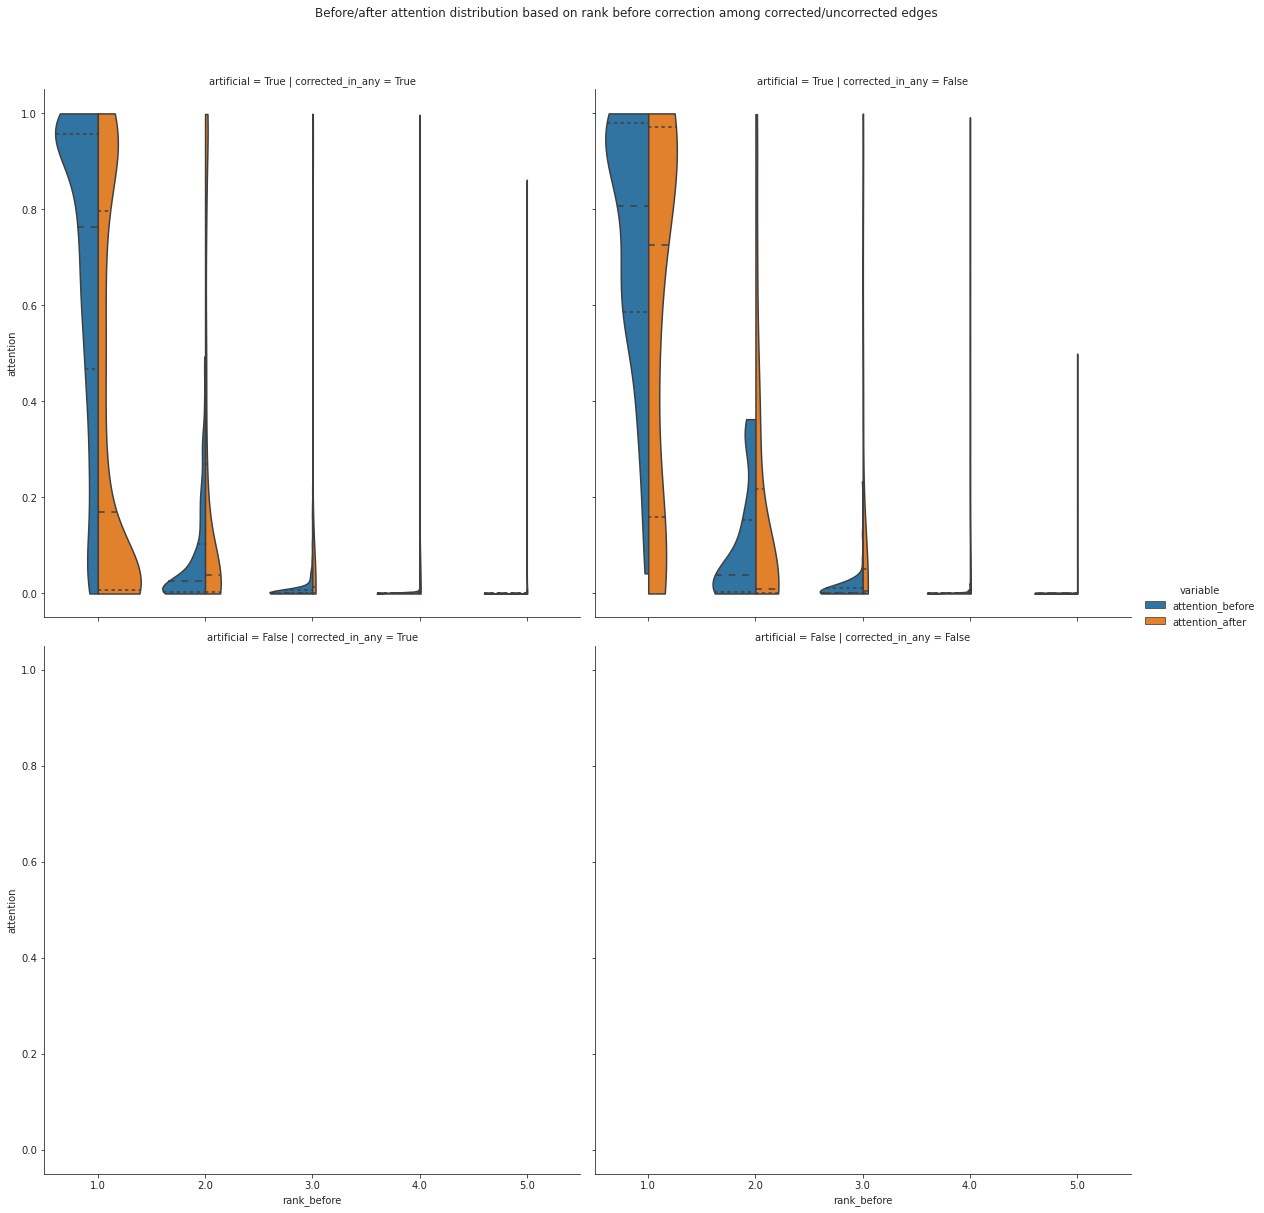

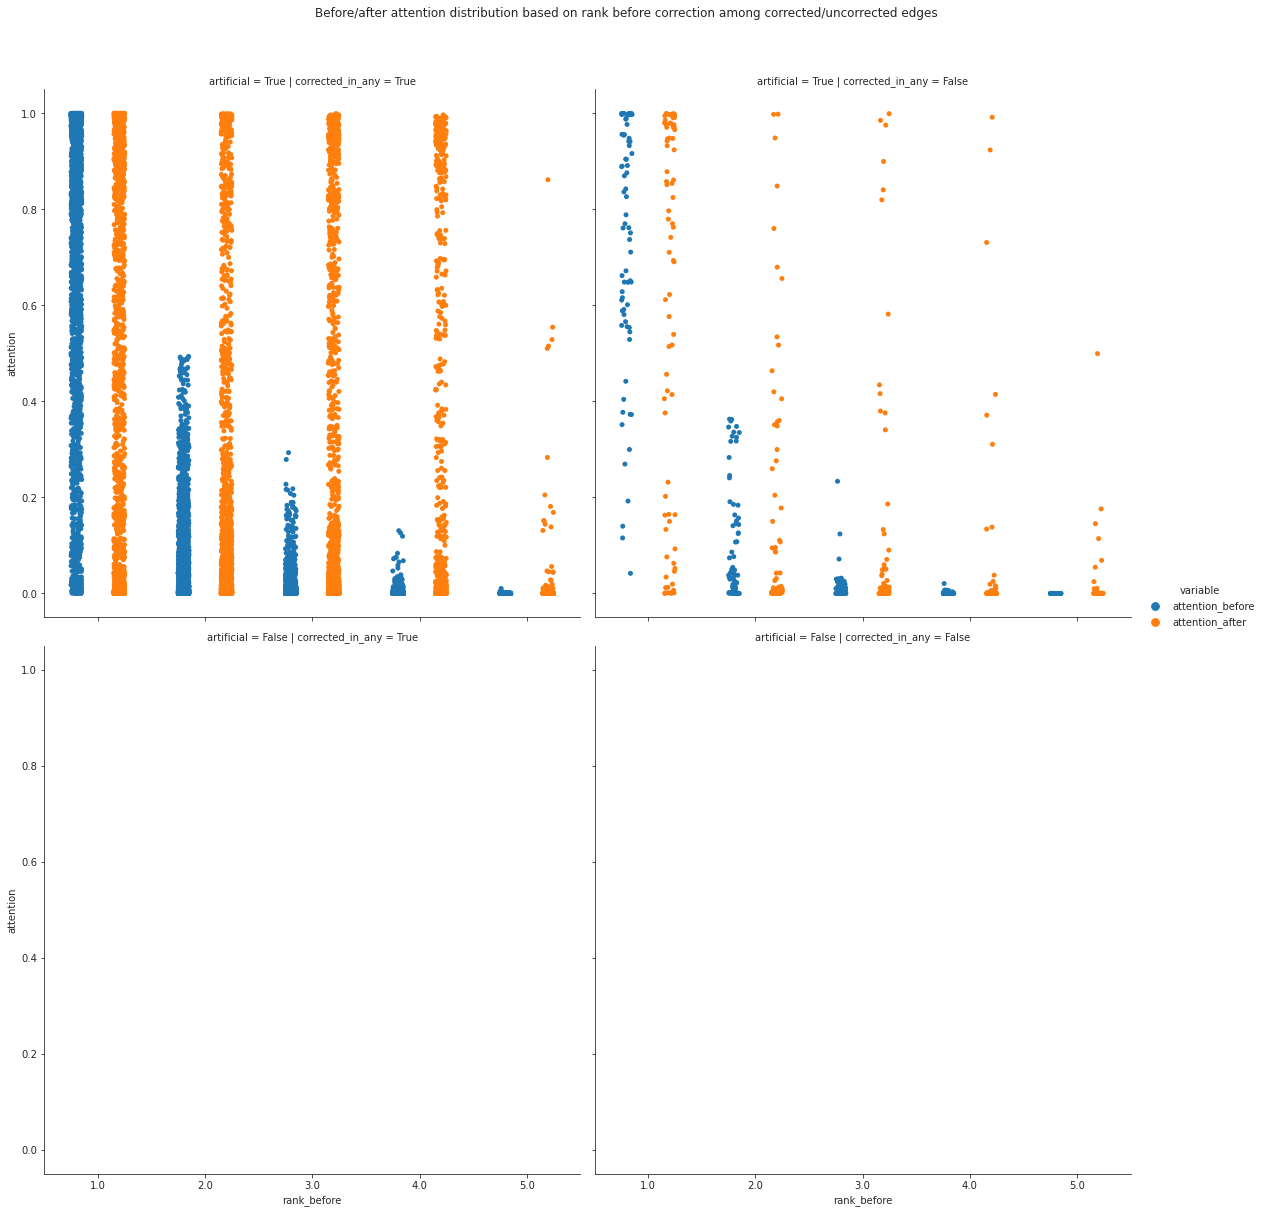

In [15]:
plot_artificial_attention_distribution(groups[66])

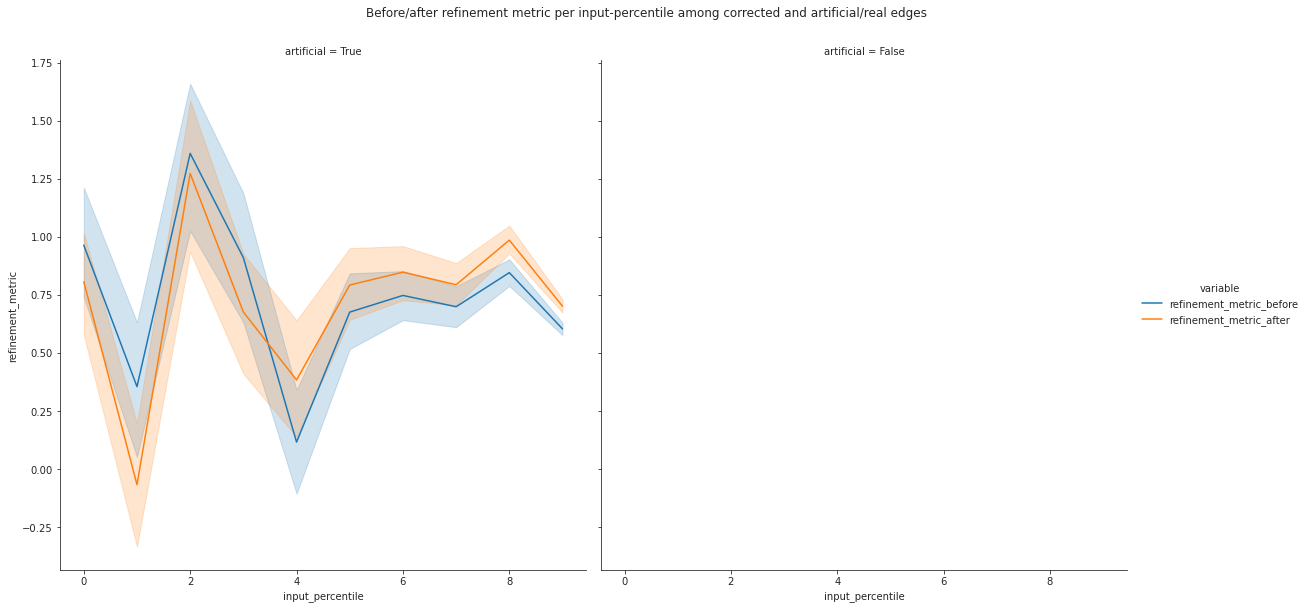

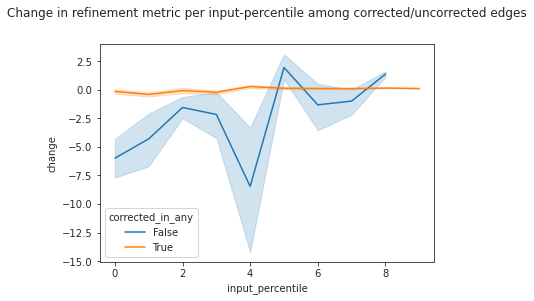

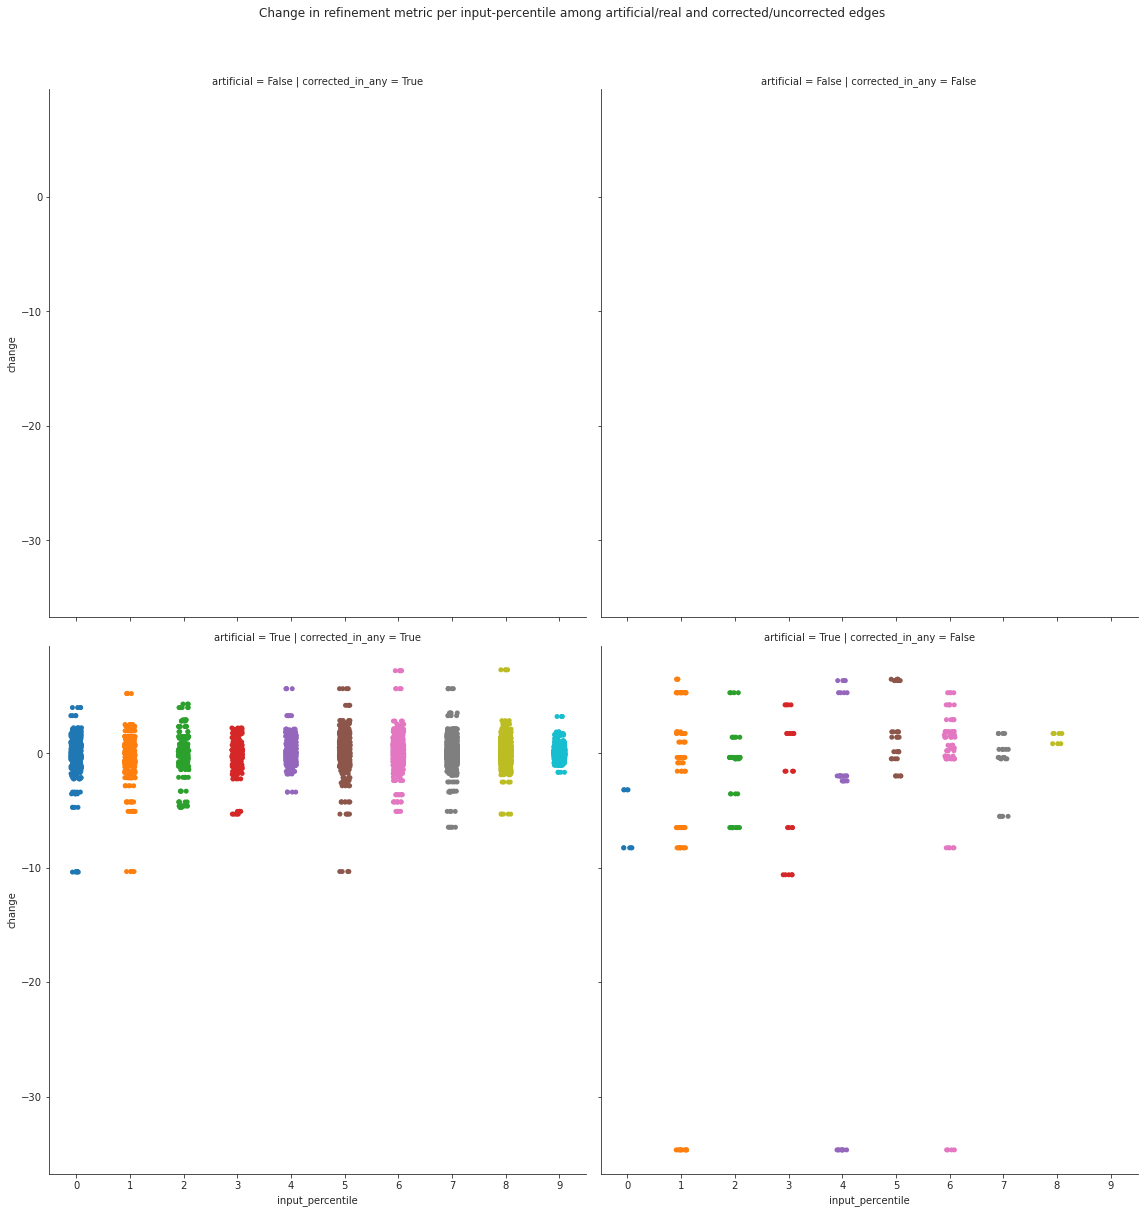

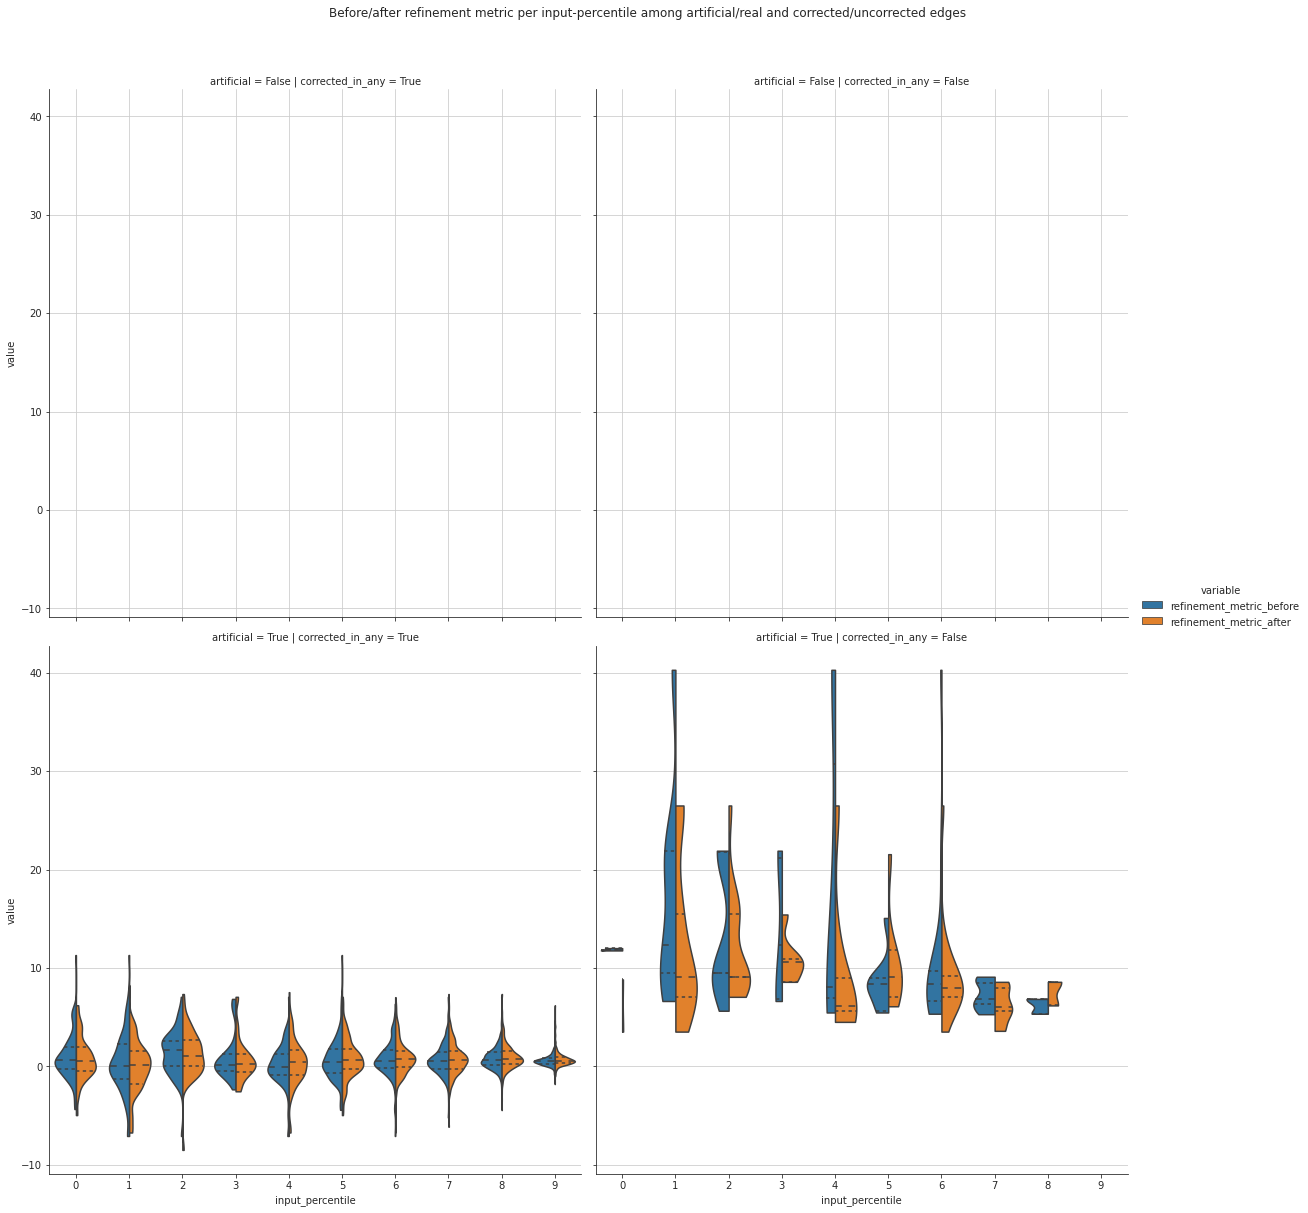

In [16]:
plot_artificial_percentile_metrics(groups[66])

# Artificially low-quality domain knowledge

In [ ]:
# This generates artificially low-quality domain knowledge (both adding and removing edges)

In [97]:
from typing import Dict, List
import random
import json

random.seed(476548684)

def add_edges(path: str, percentage: float):
    with open(path) as f:
        knowledge = json.load(f)

    all_connections = set([(child, parent) for child, parents in knowledge.items() for parent in parents])
    connections = set([(child, parent) for child, parent in all_connections if child != parent])

    children = list(set([x[0] for x in connections]))
    parents = list(set([x[1] for x in connections]))
    potential_connections = [
        (c, p) for c in children for p in parents if (c,p) not in connections and c != p
    ]
    connections_to_add = random.sample(
        potential_connections,
        k=min(len(potential_connections), int(percentage * len(connections)))
    )

    updated_knowledge: Dict[str, List[str]] = {}
    for (child, parent) in set(connections_to_add).union(all_connections):
        updated_knowledge[child] = updated_knowledge.get(child, []) + [parent]
    
    generic_file_path = path.split(".json")[0]

    with open("{}_a{}.json".format(generic_file_path, percentage), "w") as knowledge_file:
        json.dump(updated_knowledge, knowledge_file)

def remove_edges(path: str, percentage: float):
    with open(path) as f:
        knowledge = json.load(f)

    all_connections = set([(child, parent) for child, parents in knowledge.items() for parent in parents])
    connections = set([(child, parent) for child, parent in all_connections if child != parent])

    connections_to_remove = random.sample(
        connections,
        k=min(len(connections), int(percentage * len(connections)))
    )

    updated_knowledge: Dict[str, List[str]] = {}
    for (child, parent) in set(connections).difference(connections_to_remove):
        updated_knowledge[child] = updated_knowledge.get(child, []) + [parent]

    generic_file_path = path.split(".json")[0]

    with open("{}_r{}.json".format(generic_file_path, percentage), "w") as knowledge_file:
        json.dump(updated_knowledge, knowledge_file)

add_edges("../data/potential/gram_original_file_knowledge.json", 1.0)
remove_edges("../data/potential/gram_original_file_knowledge.json", 1.0)

In [109]:
import json

def remove_percentage_of_added(
    percentage: float,
    modified_path: str,
    original_path: str
):
    with open(modified_path) as f:
        modified_knowledge = json.load(f)

    flattened_knowledge = [(child, parent) for child, parents in modified_knowledge.items() for parent in parents]

    df = pd.DataFrame.from_records(flattened_knowledge, columns=["child", "parent"])

    with open(original_path) as f:
        original_knowledge = json.load(f)

    df["added"] = df.apply(lambda x: (x["child"] not in original_knowledge) or (x["parent"] not in original_knowledge[x["child"]]), axis=1)

    df["discard"] = df["added"].sample(frac=percentage, random_state=84463)
    df["discard"] = df["discard"].fillna(False)

    updated_knowledge: Dict[str, List[str]] = {}

    for _, row in df[~df["discard"]].iterrows():
        updated_knowledge[row["child"]] = updated_knowledge.get(row["child"], []) + [row["parent"]]

    generic_file_path = modified_path.split(".json")[0]

    with open("{}_r{}.json".format(generic_file_path, percentage), "w") as f:
        json.dump(updated_knowledge, f)

def add_percentage_of_removed(
    percentage: float,
    modified_path: str,
    original_path: str
):
    with open(original_path) as f:
        original_knowledge = json.load(f)

    flattened_knowledge = [(child, parent) for child, parents in original_knowledge.items() for parent in parents]

    df = pd.DataFrame.from_records(flattened_knowledge, columns=["child", "parent"])

    with open(modified_path) as f:
        modified_knowledge = json.load(f)

    df["removed"] = df.apply(lambda x: (x["child"] not in modified_knowledge) or (x["parent"] not in modified_knowledge[x["child"]]), axis=1)

    df["discard"] = df["removed"].sample(frac=1.0 - percentage, random_state=684684)
    df["discard"] = df["discard"].fillna(False)

    updated_knowledge: Dict[str, List[str]] = {}

    for _, row in df[~df["discard"]].iterrows():
        updated_knowledge[row["child"]] = updated_knowledge.get(row["child"], []) + [row["parent"]]

    generic_file_path = modified_path.split(".json")[0]

    with open("{}_a{}.json".format(generic_file_path, percentage), "w") as f:
        json.dump(updated_knowledge, f)

for percentage in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    remove_percentage_of_added(percentage, "../data/potential/gram_original_file_knowledge_a1.0.json", "../data/gram_original_file_knowledge.json")
    add_percentage_of_removed(percentage, "../data/potential/gram_original_file_knowledge_r1.0.json", "../data/gram_original_file_knowledge.json")